In [2]:
!pip install SALib

In [3]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np


## Model Bazowy

Model bazowy stworzony na pierwszych laboratoriach z użyciem Microsoft Copilot. W skrócie symuluje rywalizację firmy A (dobrze znanej rynkowi firmy) z firmą B (nowym start-up'em) przy ustalonych zasobach rynkowych. Bada dynamikę walki pomiędzy dwiema firmami oraz wpływu na zasoby. Pozwala zasymulować jakie czynniki dla danego przedsiębiorstwa są ważne aby przetrwać na rynku.

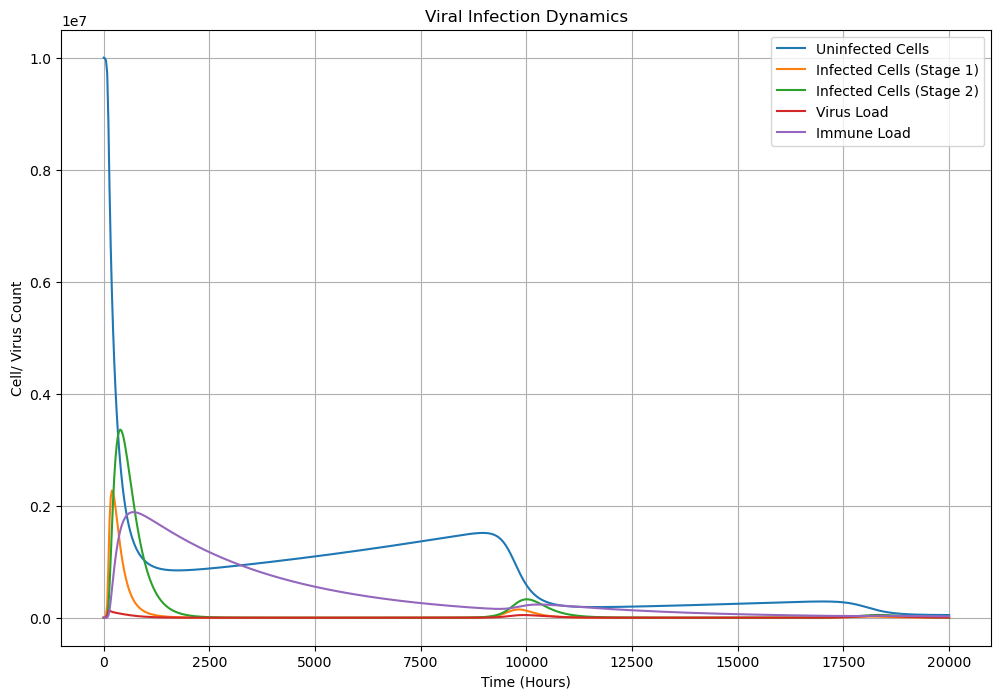

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U+I1+I2)/U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

# Parameters
beta = 7.18*600*1e-11  # infection rate
k = 1.85*600*1e-5      # infected_to_transitioning_conv_rate
d = 2.78*600*1e-6 * 2.5     # death rate
p = 3.79*600*1e-4 * .6   # virus production rate
c = 1.09*600*1e-4     # virus decay rate
cp = 1e-5 * 4
cd = 1e-4 * 3
ck = 1e-6 * 4
r = 1e-4

# Initial conditions
U0 = 1e7  # initial uninfected cells
I1_0 = 0  # initial infected cells stage 1
I2_0 = 0  # initial infected cells stage 2
A0 = 0    # initial dead cells
V0 = 1000 # initial virus load
C0 = 0

# Time points (days)
t = np.linspace(0, 20000, 720)  # simulate for 50 days

# Initial state
y0 = [U0, I1_0, I2_0, V0, C0]

# Solve ODE
solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp ,cd, ck, U0))

# Plot results
U, I1, I2, V, C = solution.T
plt.figure(figsize=(12, 8))
plt.plot(t, U, label='Uninfected Cells')
plt.plot(t, I1, label='Infected Cells (Stage 1)')
plt.plot(t, I2, label='Infected Cells (Stage 2)')
plt.plot(t, V, label='Virus Load')
plt.plot(t, C, label='Immune Load')
plt.xlabel('Time (Hours)')
plt.ylabel('Cell/ Virus Count')
plt.legend()
plt.title('Viral Infection Dynamics')
plt.grid()
plt.show()


In [5]:
min(V), min(I1), min(I2)

(2.6129251692049595, 0.0, 0.0)

In [6]:
np.save('data/solution_sample.npy', solution[::5])

## Metoda Sobola

Poniżej przeprowadzone zostanie badanie wpływu współczynników modelu na wynik przy użyciu metody Sobola. Weźmiemy pod uwagę indeks pierwszego oraz totalnego rzędu. Pierwszy rząd bada wpływ zmiany  pojedyńczego parametru na wynik modelu, gdzie totalny rząd bada zmianę uwzględniając interakcję z innymi parametrami.

In [7]:
t = np.linspace(0, 20000, 720)

In [8]:
from SALib.sample import sobol

problem = {
    'num_vars': 14,
    'names': ['U0','I1_0','I2_0', 'V0','C0', 'beta', 'k', 'd', 'p', 'c', 'cp', 'cd','ck','r'],
    'bounds': [
        [U0/2,U0*2],
        [0,1000],
        [0,1000],
        [V0/2,V0*2],
        [0,1000],
        [beta/2,beta*2],
        [k/2,k*2],
        [d/2,d*2],
        [p/2,p*2],
        [c/2,c*2],
        [cp/2,cp*2],
        [cd/2,cd*2],
        [ck/2,ck*2],
        [r/2,r*2]
    ]
}

W badaniu wyłączony zostanie drugi rząd, który bada również interackję pomiędzy parami parametrów.

In [9]:
param_values_sobol = sobol.sample(problem, 1024, calc_second_order=False)

In [10]:
def evaluate_model(params):
    U0,I1_0,I2_0, V0, C0, beta, k, d, p, c, cp, cd, ck, r = params
    y0 = [U0, I1_0, I2_0, V0, C0]
    solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0+I1_0+I2_0))
    U, I1, I2, V, C = solution.T
    return U, I1, I2, V, C

In [11]:
from tqdm import tqdm_notebook

Us, I1s, I2s, Vs, Cs = [], [], [], [], []
for params in tqdm_notebook(param_values_sobol):
  U, I1, I2, V, C = evaluate_model(params)
  Us.append(U)
  I1s.append(I1)
  I2s.append(I2)
  Vs.append(V)
  Cs.append(C)

/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_31460/3774884802.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol):


  0%|          | 0/16384 [00:00<?, ?it/s]

/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_31460/2891377574.py:13: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I1**1.3 - cd * C
/var/folders/cn/mhwmm18103sbb1kd17kd3zrw0000gn/T/ipykernel_31460/2195945000.py:4: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0+I1_0+I2_0))


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1783174050169D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1837744692214D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1894294985332D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1910243651562D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1850957601934D+05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

KeyboardInterrupt: 

In [ ]:
Us = np.array(Us)
I1s = np.array(I1s)
I2s = np.array(I2s)
Cs = np.array(Cs)
Vs = np.array(Vs)

Analizuje każdy krok czasowy pojedyńczo, aby odkryć jaki wpływ współczynników jest w czasie.

In [ ]:
from SALib.analyze import sobol

resultsU = []
resultsI1 = []
resultsI2 = []
resultsV = []
resultsC = []
for time_ in tqdm_notebook(range(1,720)):
  resultsU.append(sobol.analyze(problem, Us[:,time_], calc_second_order=False))
  resultsI1.append(sobol.analyze(problem, I1s[:,time_], calc_second_order=False))
  resultsI2.append(sobol.analyze(problem, I2s[:,time_], calc_second_order=False))
  resultsV.append(sobol.analyze(problem, Vs[:,time_], calc_second_order=False))
  resultsC.append(sobol.analyze(problem, Cs[:,time_], calc_second_order=False))

<ipython-input-12-f4b7e595e975>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for time_ in tqdm_notebook(range(1,720)):


  0%|          | 0/719 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [ ]:
S1MatrixU = np.array([result['S1'] for result in resultsU])
STMatrixU = np.array([result['ST'] for result in resultsU])
S1MatrixI1 = np.array([result['S1'] for result in resultsI1])
STMatrixI1 = np.array([result['ST'] for result in resultsI1])
S1MatrixI2 = np.array([result['S1'] for result in resultsI2])
STMatrixI2 = np.array([result['ST'] for result in resultsI2])
S1MatrixV = np.array([result['S1'] for result in resultsV])
STMatrixV = np.array([result['ST'] for result in resultsV])
S1MatrixC = np.array([result['S1'] for result in resultsC])
STMatrixC = np.array([result['ST'] for result in resultsC])

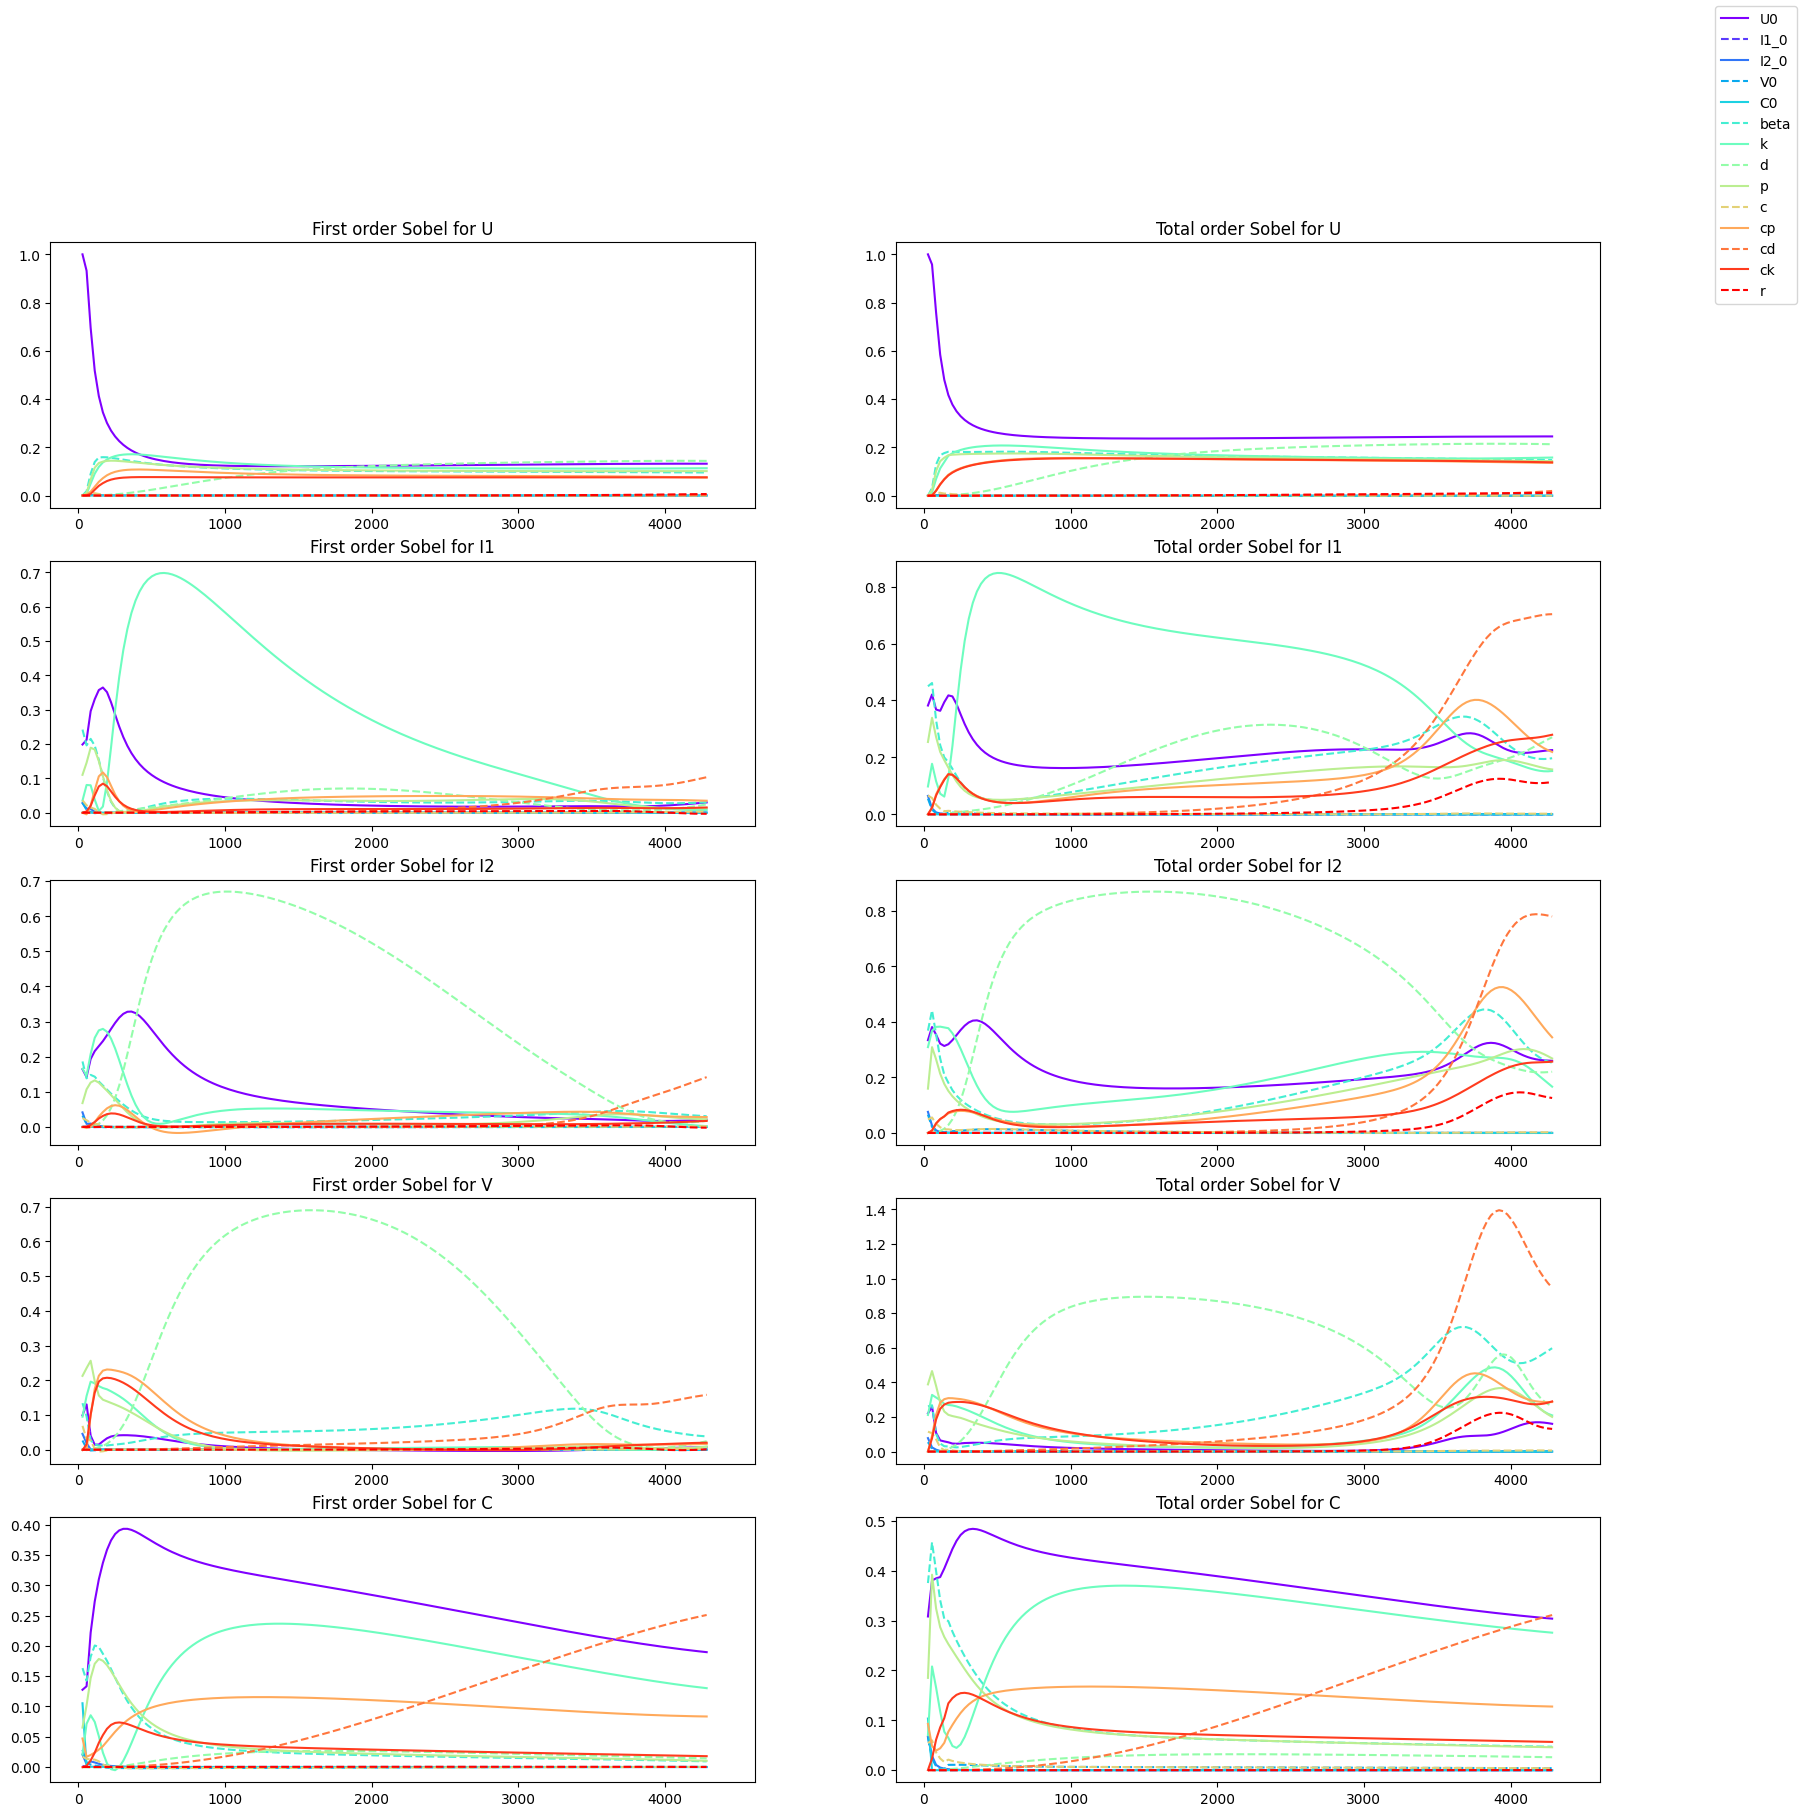

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, problem['num_vars']))
fig, axes = plt.subplots(5,2)
matrices = [[S1MatrixU,STMatrixU],
            [S1MatrixI1,STMatrixI1],
            [S1MatrixI2,STMatrixI2],
            [S1MatrixV,STMatrixV],
            [S1MatrixC,STMatrixC]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['U','I1','I2','V','C']
fig.set_size_inches(20,20)

for row in range(5):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(problem['num_vars']),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [ ]:
all_scores = np.concatenate([el for arr in matrices for el in arr])
mask = np.isnan(all_scores.mean(axis=1))
all_scores_clean = all_scores[~mask]
means = all_scores_clean.mean(axis=0)
for label, mean in zip(problem['names'],means):
  print(f"{label}: {mean}")

U0: 0.1704665704990507
I1_0: 1.7427658655274037e-05
I2_0: 0.0005409504775106586
V0: 0.0011903308984518293
C0: 0.00013720238190663265
beta: 0.11340852234993333
k: 0.19704307683899724
d: 0.24485169173356847
p: 0.08296482001047499
c: 0.0023160000590082344
cp: 0.10139324917346326
cd: 0.08735528427753866
ck: 0.06953452416848786
r: 0.009208504856990029


In [ ]:
t = np.linspace(0, 20000, 360)  # simulate for 50 days

In [ ]:
problem = {
    'num_vars': 9,
    'names': ['U0','I1_0', 'beta', 'k', 'd', 'p', 'cp', 'cd','ck'],
    'bounds': [
        [U0/1.5,U0*1.5],
        [0,200],
        [beta/1.5,beta*1.5],
        [k/1.5,k*1.5],
        [d/1.5,d*1.5],
        [p/1.5,p*1.5],
        [cp/1.5,cp*1.5],
        [cd/1.5,cd*1.5],
        [ck/1.5,ck*1.5]
    ]
}

In [ ]:
def evaluate_model2(params):
    U0,I1_0, beta, k, d, p, cp, cd, ck = params
    y0 = [U0, I1_0, 0,1000, 0]
    solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, 1.09*600*1e-4, 1e-4, cp, cd, ck, U0+I1_0))
    U, I1, I2, V, C = solution.T
    return U, I1, I2, V, C

In [ ]:
from SALib.sample import sobol as sobol_sampler
param_values_sobol2 = sobol_sampler.sample(problem, 1024, calc_second_order=False)

In [ ]:
from tqdm import tqdm_notebook

Uss, I1ss, I2ss, Vss, Css = [], [], [], [], []
for params in tqdm_notebook(param_values_sobol2):
  U, I1, I2, V, C = evaluate_model2(params)
  Uss.append(U)
  I1ss.append(I1)
  I2ss.append(I2)
  Css.append(C)
  Vss.append(V)

<ipython-input-153-49a883272dd7>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol2):


  0%|          | 0/11264 [00:00<?, ?it/s]

<ipython-input-93-0563ec450df6>:13: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I1**1.3 - cd * C
<ipython-input-151-26168b8152e4>:4: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, 1.09*600*1e-4, 1e-4, cp, cd, ck, U0+I1_0))


In [ ]:
Uss = np.array(Uss)
I1ss = np.array(I1ss)
I2ss = np.array(I2ss)
Css = np.array(Css)
Vss = np.array(Vss)

In [ ]:
from SALib.analyze import sobol

resultsUs = []
resultsI1s = []
resultsI2s = []
resultsCs = []
resultsVs = []
for time_ in tqdm_notebook(range(1,720)):
  resultsUs.append(sobol.analyze(problem, Uss[:,time_], calc_second_order=False))
  resultsI1s.append(sobol.analyze(problem, I1ss[:,time_], calc_second_order=False))
  resultsI2s.append(sobol.analyze(problem, I2ss[:,time_], calc_second_order=False))
  resultsCs.append(sobol.analyze(problem, Css[:,time_], calc_second_order=False))
  resultsVs.append(sobol.analyze(problem, Vss[:,time_], calc_second_order=False))

<ipython-input-155-42977c3f5976>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for time_ in tqdm_notebook(range(1,720)):


  0%|          | 0/719 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/sobol.py:216: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/sobol.py:229: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdi

In [ ]:
S1MatrixUs = np.array([result['S1'] for result in resultsUs])
STMatrixUs = np.array([result['ST'] for result in resultsUs])
S1MatrixI1s = np.array([result['S1'] for result in resultsI1s])
STMatrixI1s = np.array([result['ST'] for result in resultsI1s])
S1MatrixI2s = np.array([result['S1'] for result in resultsI2s])
STMatrixI2s = np.array([result['ST'] for result in resultsI2s])
S1MatrixCs = np.array([result['S1'] for result in resultsCs])
STMatrixCs = np.array([result['ST'] for result in resultsCs])
S1MatrixVs = np.array([result['S1'] for result in resultsVs])
STMatrixVs = np.array([result['ST'] for result in resultsVs])

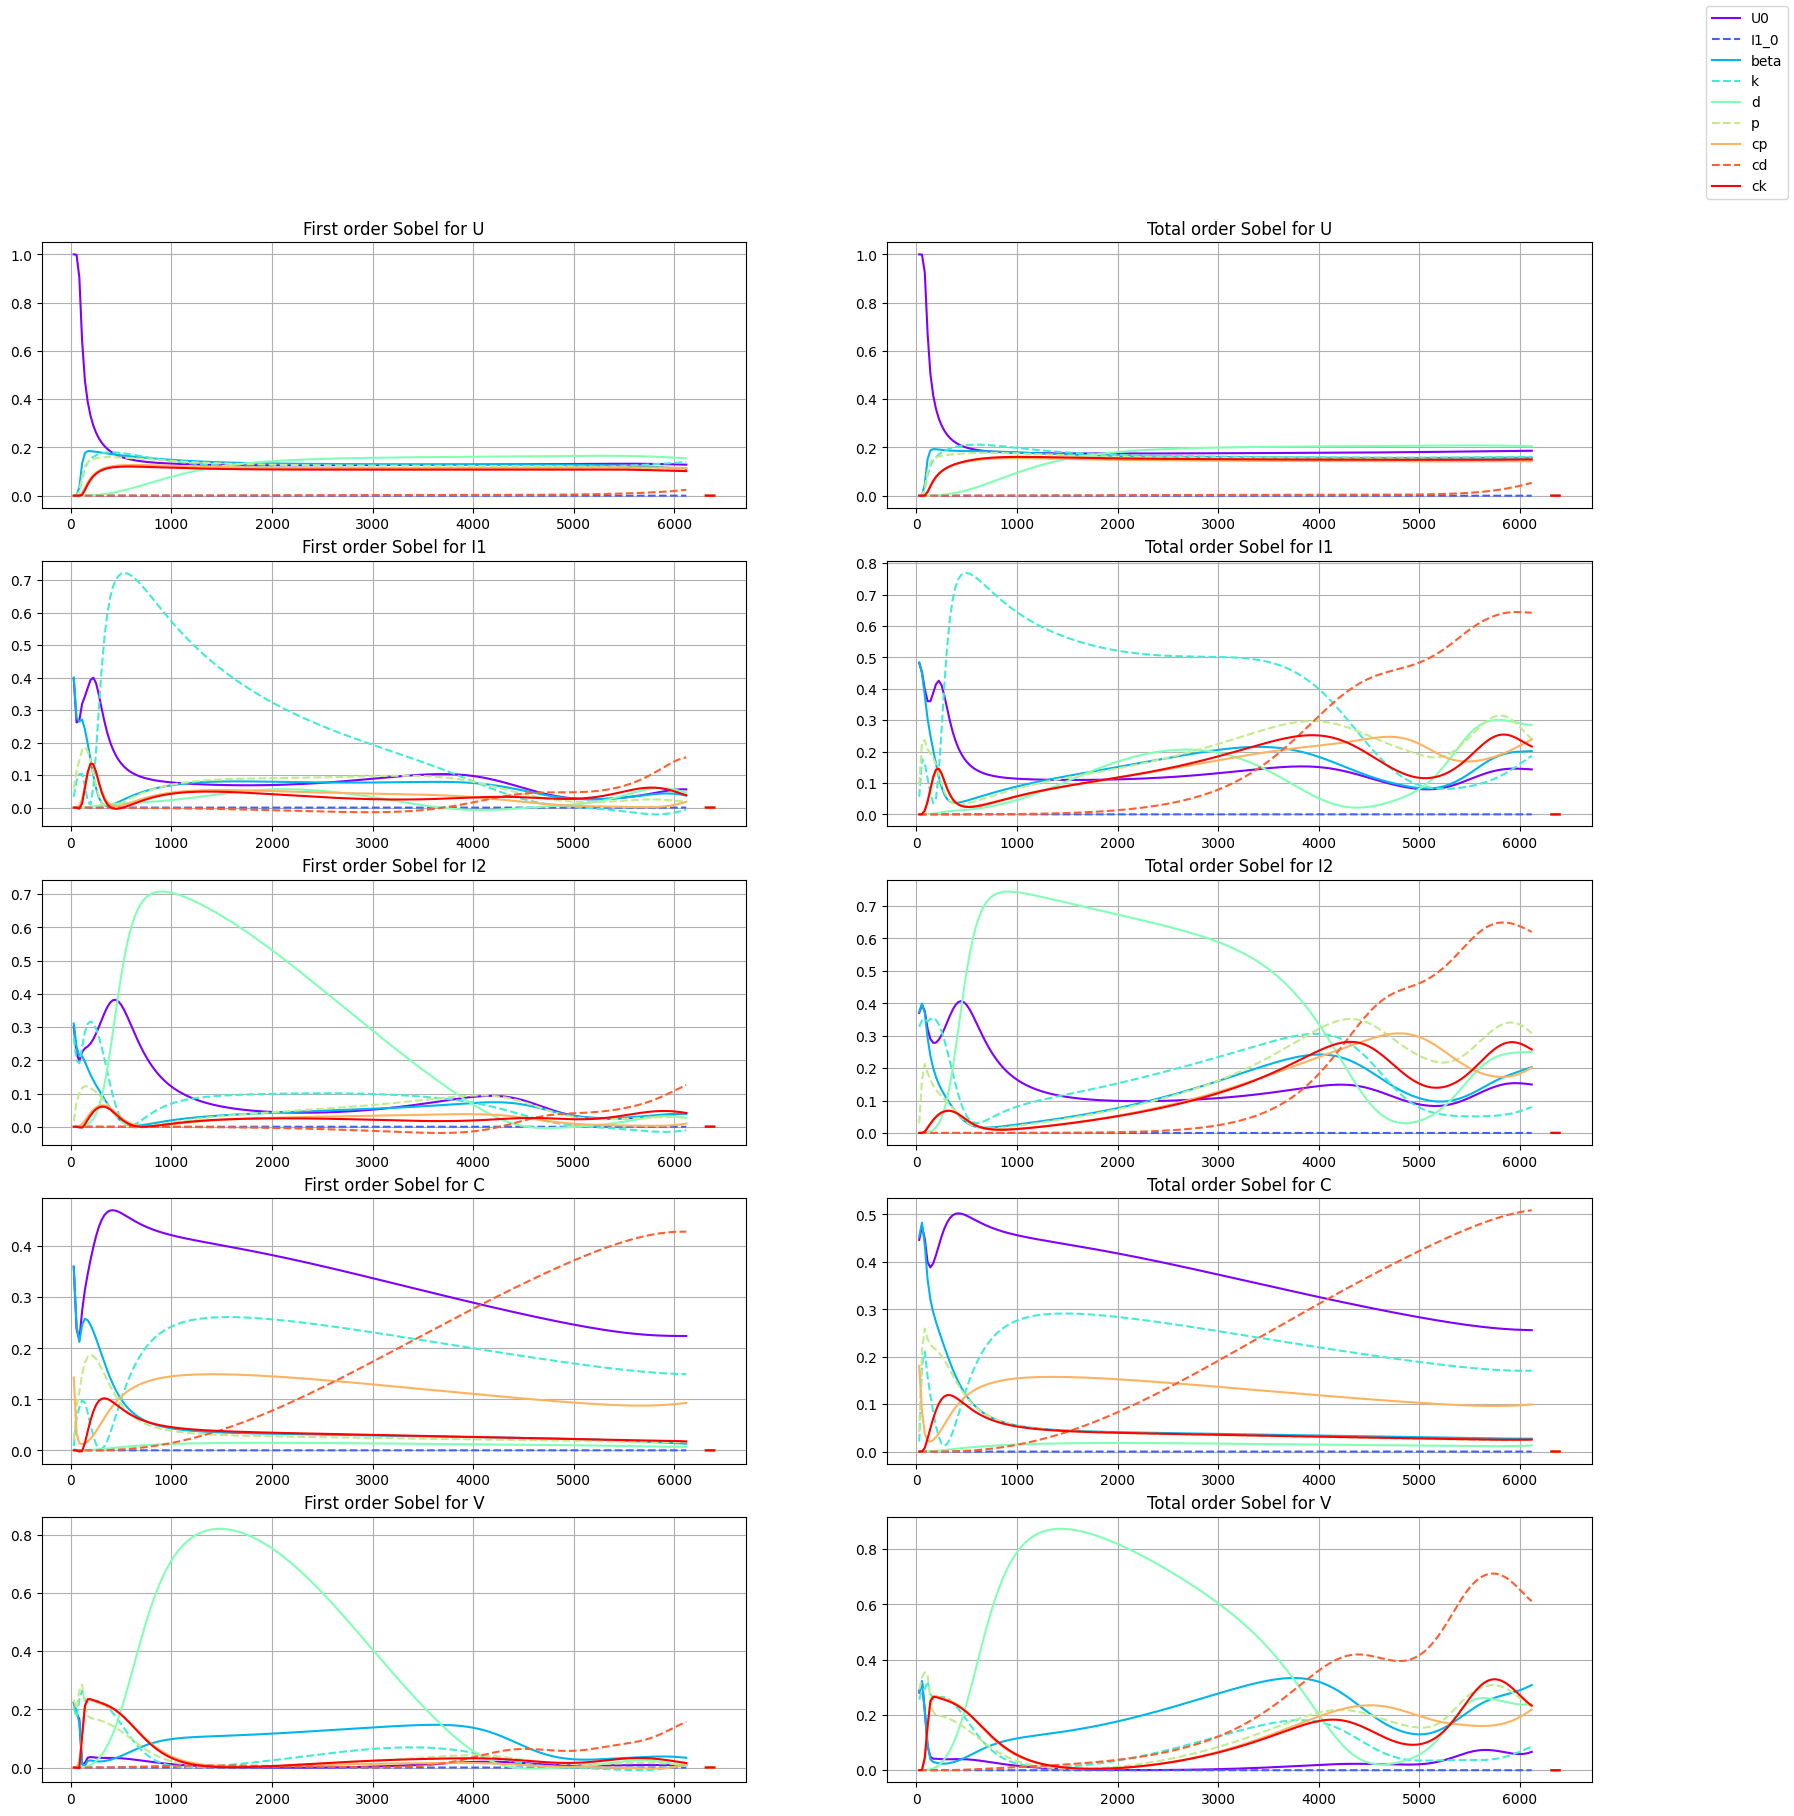

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 9))
fig, axes = plt.subplots(5,2)
matrices = [[S1MatrixUs,STMatrixUs],
            [S1MatrixI1s,STMatrixI1s],
            [S1MatrixI2s,STMatrixI2s],
            [S1MatrixCs,STMatrixCs],
            [S1MatrixVs,STMatrixVs]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['U','I1','I2','C','V']
fig.set_size_inches(20,20)

for row in range(5):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(9),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [ ]:
all_scores = np.concatenate([el for arr in matrices for el in arr])
mask = np.isnan(all_scores.mean(axis=1))
all_scores_clean = all_scores[~mask]
means = all_scores_clean.mean(axis=0)
for label, mean in zip(problem['names'],means):
  print(f"{label}: {mean}")

U0: 0.1520400457406601
I1_0: 9.772534058232996e-06
beta: 0.1065813706136371
k: 0.16653819060360522
d: 0.18572894296010983
p: 0.10006231401283051
cp: 0.09733035838186803
cd: 0.10867426463276014
ck: 0.08110418452813331


## Meroda Morrisa

Poniżej zostanie użyta metoda Morrisa, dokładnie w tym samym celu co Sobola. Będziemy używać metryki u* (wartość oczekiwana dla wartości elementarnych absolutnych), która oznacza siłę wpływu danego parametru (bez interakcji) na wynik modelu.

In [ ]:
from SALib.sample import morris as morris_sample
from SALib.analyze import morris as morris_analyze

param_values = morris_sample.sample(problem, 1024)

In [ ]:
MUs = []
for params in tqdm_notebook(param_values):
  res = evaluate_model(params)
  MUs.append(res[0])

/tmp/ipykernel_38541/4134208182.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values):


  0%|          | 0/14336 [00:00<?, ?it/s]

/tmp/ipykernel_38541/856488260.py:4: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp, cd, ck, U0))


In [ ]:
MUs = np.array(MUs)


In [ ]:
resultsMU = []
for time_ in range(1,360):
  resultsMU.append(morris_analyze.analyze(problem, param_values,MUs[:,time_]))

/home/zogfryt/Informatyka_Systemow_Zlozonych/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/zogfryt/Informatyka_Systemow_Zlozonych/.venv/lib/python3.12/site-packages/SALib/analyze/morris.py:412: RuntimeWarning: overflow encountered in divide
  elementary_effects = difference / delta


In [ ]:
MuMatrixA = np.array([result['mu_star'] for result in resultsMU])

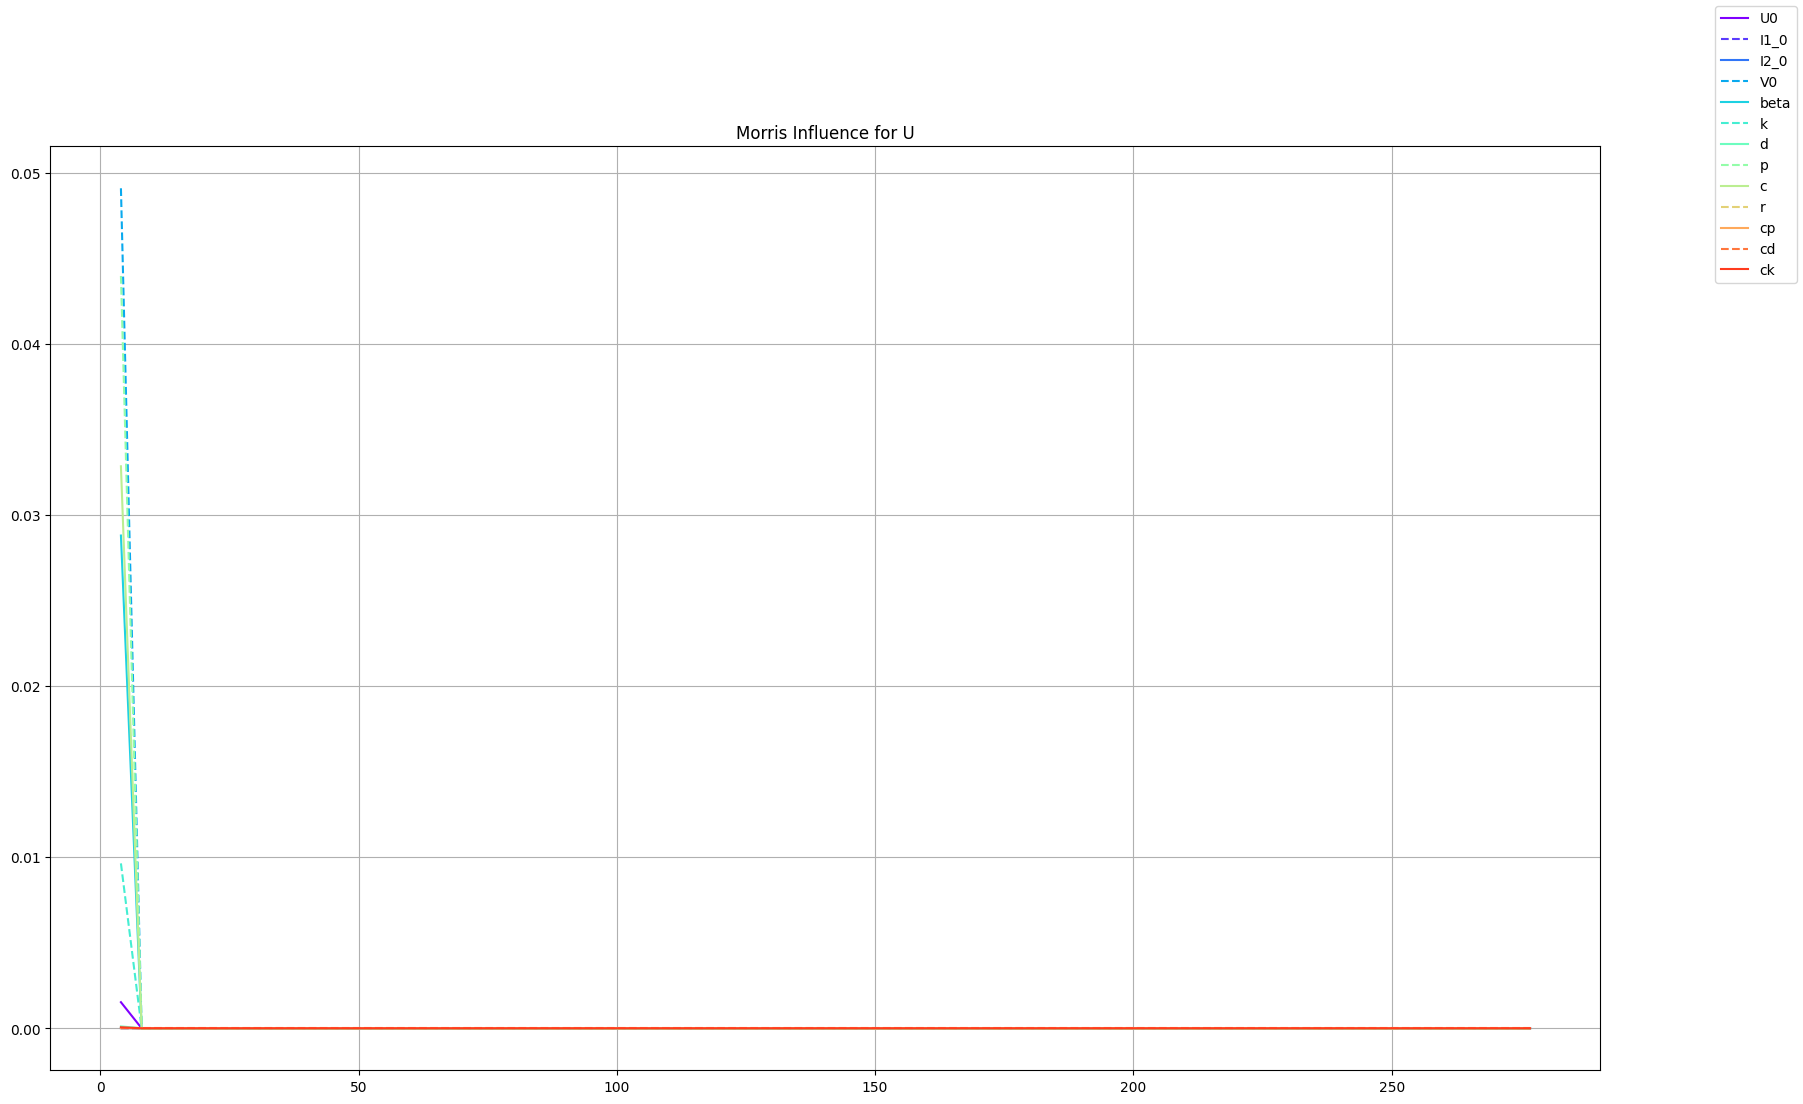

In [ ]:
fig, axes = plt.subplots(1,1)
matrices = [MuMatrixA]

color = cm.rainbow(np.linspace(0, 1, 14))
texts = ['Morris Influence for ']
variables = ['U']
fig.set_size_inches(20,12)

for col in range(1):
    for name, col_, color_ in zip(problem['names'],range(13),color):
      axes.plot(t[1:70], matrices[col][:69,col_],'-'*(1+(col_ % 2)),label=name, c=color_)
      axes.grid()
      axes.set_title(texts[0] + variables[col])


handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

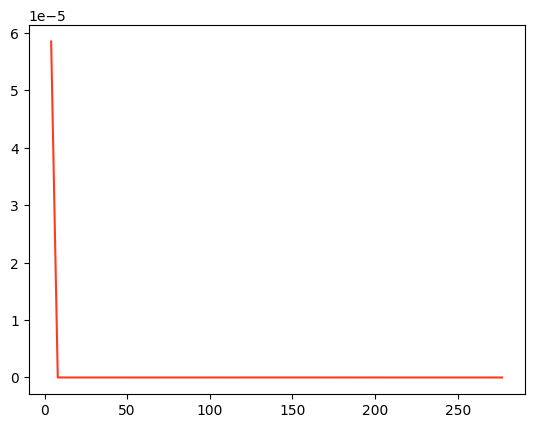

In [ ]:

plt.plot(t[1:70], matrices[col][:69,col_],'-'*(1+(col_ % 2)),label=name, c=color_)

In [ ]:
t[1:20]

array([ 4.01114206,  8.02228412, 12.03342618, 16.04456825, 20.05571031,
       24.06685237, 28.07799443, 32.08913649, 36.10027855, 40.11142061,
       44.12256267, 48.13370474, 52.1448468 , 56.15598886, 60.16713092,
       64.17827298, 68.18941504, 72.2005571 , 76.21169916])

Najmniej czułe parametry:
* L
* t_ceof
* B0
* R0
* A0
* K
* h

Według Morrisa to są najmniej wpływające parametry na nasz model. Znów powtarza się sytuacja, gdzie model jest nie reaguje zbyt mocno na zmiany wartości początkowych.

Podsumowując zbiorczo. Najmnniej oddziałujące parametry na wyniki modelu, to wszystkie wartości oraz L oraz t_ceof. Innymi słowy te dwa parametry to jest maksymalna wielkość zasobów o który biją się obie firmy (L) oraz wpływ wielkości zasobów na wzrost firmy start-up (t_ceof). Wynika to że ich zmiana nieznacznie wpływa na wyniki modelu, przez co są to parametry mniej ważne.

Najczulsze parametry w testach Morrisa oraz Sobola to u oraz v. "u" jest to szybkość w jakim tempie rośnie zasób, o który biją się firmy oraz "v" odwrotną metryką, która oznacza jak szybko zasób się kurczy (jak szybko zasoby rynkowe są spalane przez firmy). Oznacza to jak bardzo ważną kwestią jest istnienie zasobów dla obu firm. Zmiana tych parametrów, będzie wpływała bardzo mocno na wyniki symulowanego średowiska.

Zrobimy ponownie omawiane testy, lecz wyrzucając z rozważania parametry, które są najmniej czułe.

In [ ]:
from SALib.sample import sobol
problem = {
    'num_vars': 9,
    'names': ['r', 'K', 'a', 'h', 'e', 'd', 's', 'u', 'v'],
    'bounds': [
        [1.5, 2.5],
        [50, 70],
        [0.075, 0.125],
        [0.02, 0.04],
        [0.4, 0.6],
        [0.15, 0.25],
        [0.2, 0.4],
        [1.25, 1.75],
        [0.02, 0.04]
    ]
}

In [ ]:
param_values_sobol_s = sobol.sample(problem, 1024, calc_second_order=False)

W nowych testach damy wartości inne niż w bazowym modelu dla wartości początkowych. Zmiana ich nie powinna wpływać na działanie modelu znacząco. Ustawmy je trochę inaczej. Firma A zaczyna mniejsza (40 -> 35), za to rynek i firma B są większe (B0: 9 -> 11)(R0: 50 -> 55).
Parametry L oraz t_ceof zmniejszymy natomiat lekko (L: 100 -> 95) (t_ceof: 0.2 -> 0.18)

In [ ]:
def evaluate_model_smaller(params):
    r, K, a, h, e, d, s, u, v = params
    y0 = [35,11,55]
    solution = odeint(model, y0, t, args=(r, K, a, h, e, d, s, 0.18, u, 95, v))
    A, B, R = solution.T
    return A, B, R

In [ ]:
from tqdm import tqdm_notebook

As_small, Bs_small, Rs_small = [], [], []
for params in tqdm_notebook(param_values_sobol_s):
  A,B,R = evaluate_model_smaller(params)
  As_small.append(A)
  Bs_small.append(B)
  Rs_small.append(R)

<ipython-input-53-b50b46e361f5>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol_s):


  0%|          | 0/11264 [00:00<?, ?it/s]

In [ ]:
As_small = np.array(As_small)
Bs_small = np.array(Bs_small)
Rs_small = np.array(Rs_small)

In [ ]:
from SALib.analyze import sobol

resultsA_small = []
resultsB_small = []
resultsR_small = []
for time_ in range(1,50):
  resultsA_small.append(sobol.analyze(problem, As_small[:,time_], calc_second_order=False))
  resultsB_small.append(sobol.analyze(problem, Bs_small[:,time_], calc_second_order=False))
  resultsR_small.append(sobol.analyze(problem, Rs_small[:,time_], calc_second_order=False))

/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [ ]:
S1MatrixA_small = np.array([result['S1'] for result in resultsA_small])
STMatrixA_small = np.array([result['ST'] for result in resultsA_small])
S1MatrixB_small = np.array([result['S1'] for result in resultsB_small])
STMatrixB_small = np.array([result['ST'] for result in resultsB_small])
S1MatrixR_small = np.array([result['S1'] for result in resultsR_small])
STMatrixR_small = np.array([result['ST'] for result in resultsR_small])

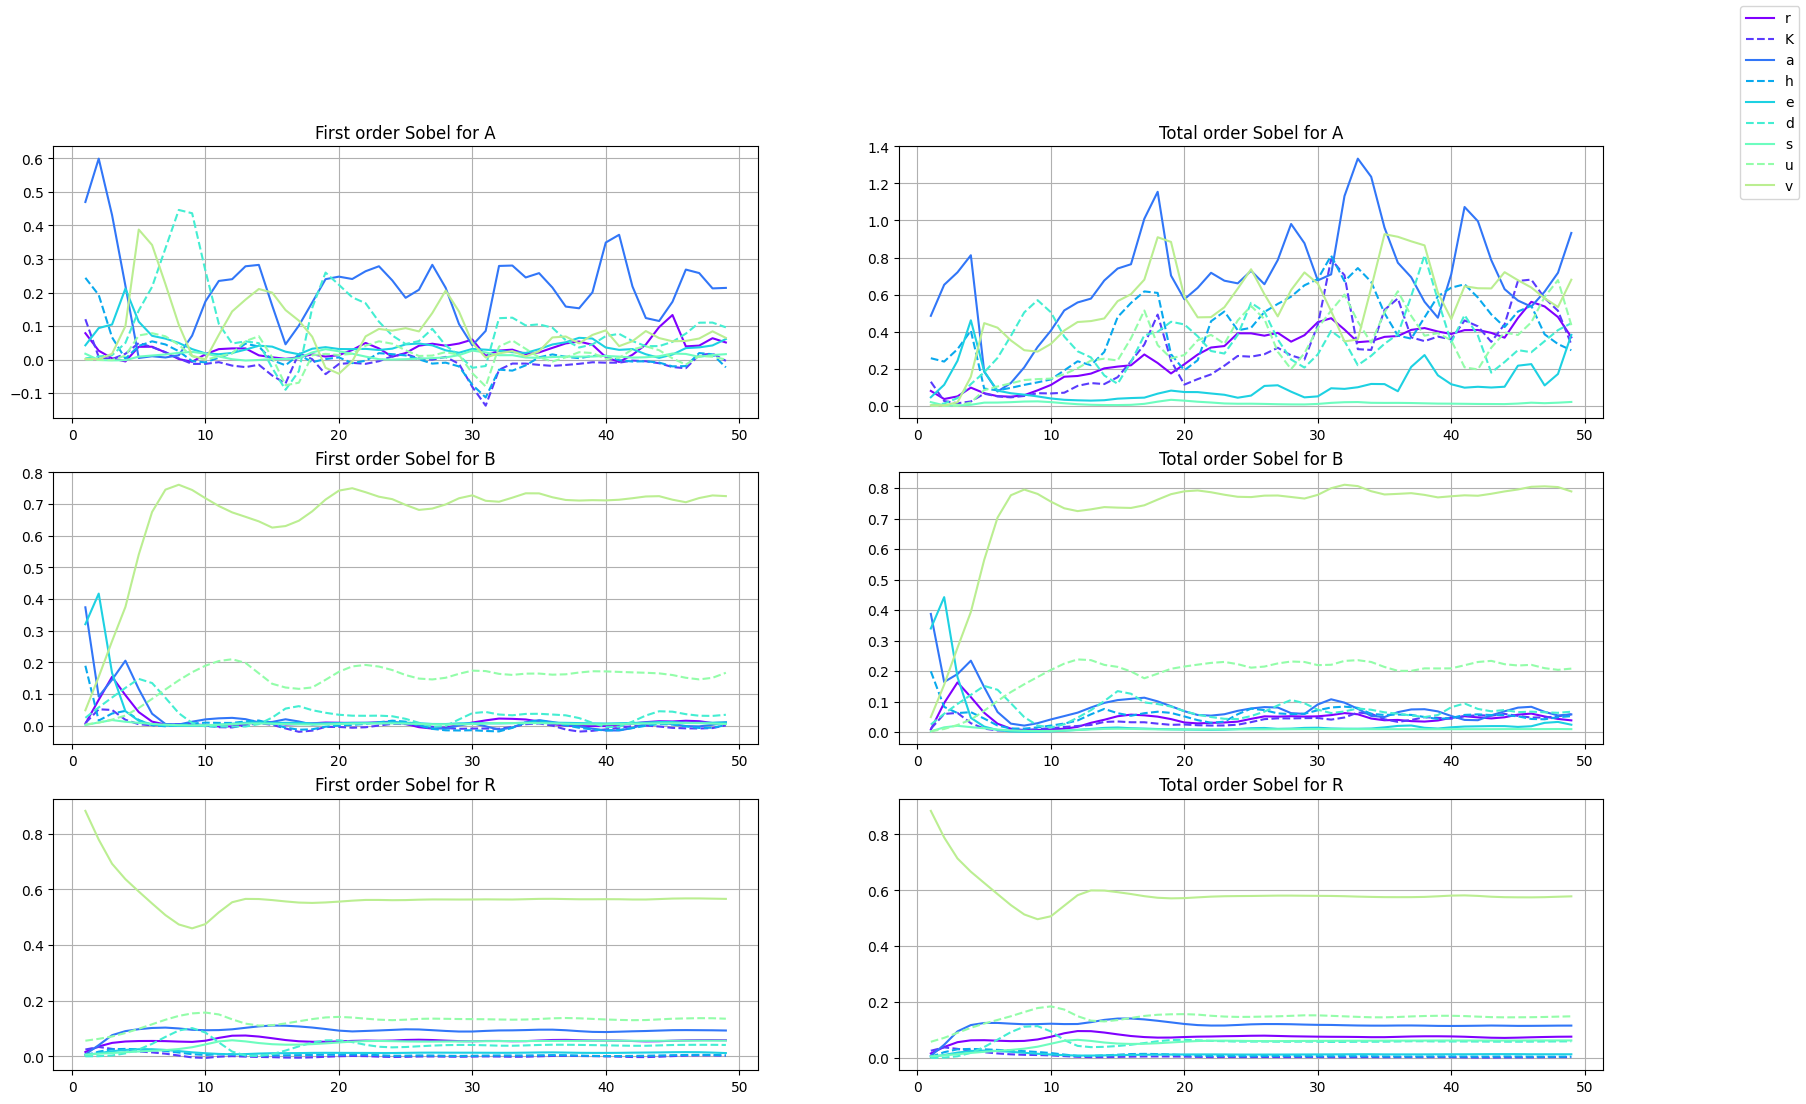

In [ ]:
color = cm.rainbow(np.linspace(0, 1, 14))
fig, axes = plt.subplots(3,2)
matrices = [[S1MatrixA_small,STMatrixA_small],
            [S1MatrixB_small,STMatrixB_small],
            [S1MatrixR_small,STMatrixR_small]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['A','B','R']
fig.set_size_inches(20,12)

for row in range(3):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(9),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

O ile wyniki dla zmiennej dynamicznej R oraz B są praktycznie takie same (gdzie wpływ parametrów najmniej czułych był praktycznie 0-wy), to dla zmiennejn dynamicznej A widać pewne zmiany. Wpływy na zmienność są lekko zwiększone. Również widać o wiele większy wpływ parametru "a". To on zwiększył skale, znacznie wybijając się swoim wpływem na tle innych parametrów w plocie totalnego Sobola. Jeśli chodzi o wykres Sobola, dla pierwszego stopnia (first order) wyniki nieznacznie odbiegają od poprzednich. Powodem może być inne samplowanie (mamy mniej próbek od poprzedniego 11k vs 16k) oraz zamrożenie zmian wartości parametrów o niskiej czułości dla tych testów (miały mały wpływ na zmienną dynamiczną A, ale nie zerowy).

In [ ]:
param_values_s = morris_sample.sample(problem, 1024)

In [ ]:
MAs_small, MBs_small, MRs_small = [], [], []
for params in tqdm_notebook(param_values_s):
  A,B,R = evaluate_model_smaller(params)
  MAs_small.append(A)
  MBs_small.append(B)
  MRs_small.append(R)

<ipython-input-88-33950fc3b3ca>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_s):


  0%|          | 0/10240 [00:00<?, ?it/s]

In [ ]:
MAs_small = np.array(MAs_small)
MBs_small = np.array(MBs_small)
MRs_small = np.array(MRs_small)

In [ ]:
resultsMA_small = []
resultsMB_small = []
resultsMR_small = []
for time_ in range(1,50):
  resultsMA_small.append(morris_analyze.analyze(problem, param_values_s,MAs_small[:,time_]))
  resultsMB_small.append(morris_analyze.analyze(problem, param_values_s,MBs_small[:,time_]))
  resultsMR_small.append(morris_analyze.analyze(problem, param_values_s,MRs_small[:,time_]))

In [ ]:
MuMatrixA_small = np.array([result['mu_star'] for result in resultsMA_small])
MuMatrixB_small = np.array([result['mu_star'] for result in resultsMB_small])
MuMatrixR_small = np.array([result['mu_star'] for result in resultsMR_small])

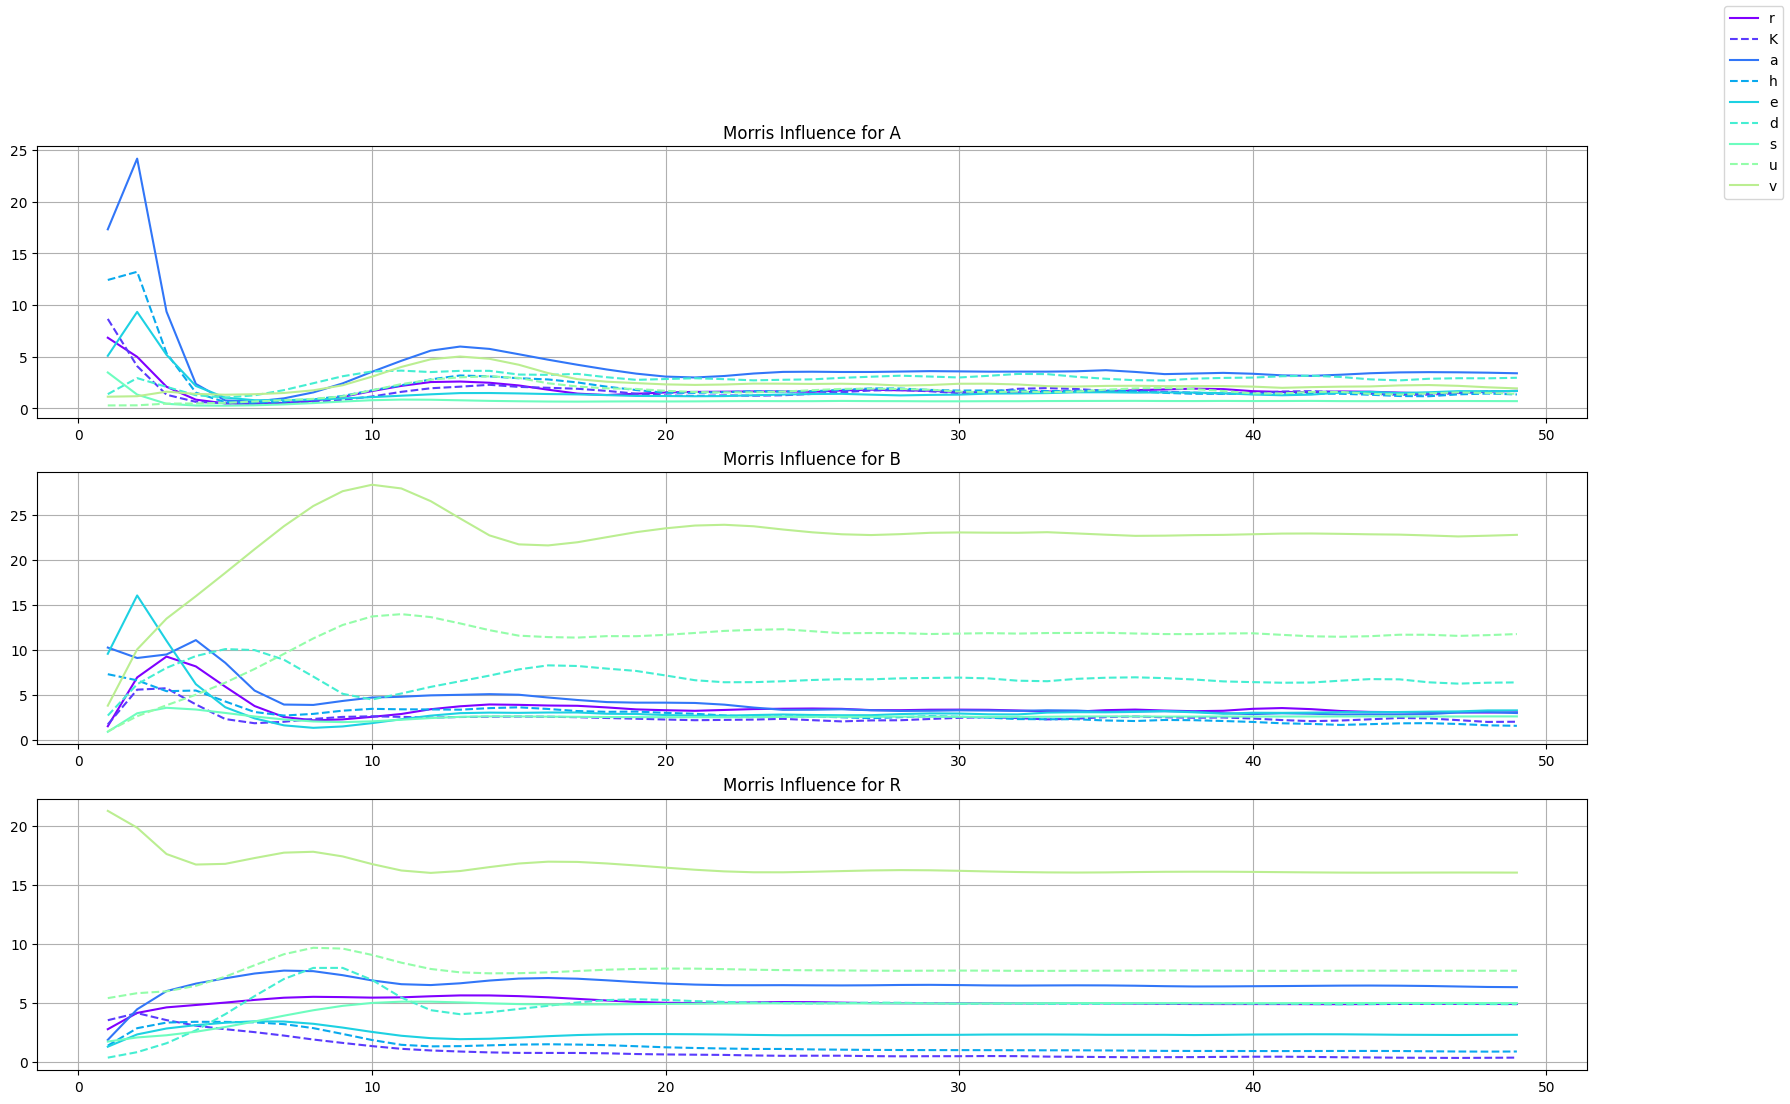

In [ ]:
fig, axes = plt.subplots(3,1)
matrices = [MuMatrixA_small,MuMatrixB_small,MuMatrixR_small]

color = cm.rainbow(np.linspace(0, 1, 14))
texts = ['Morris Influence for ']
variables = ['A','B','R']
fig.set_size_inches(20,12)

for col in range(3):
    for name, col_, color_ in zip(problem['names'],range(9),color):
      axes[col].plot(t[1:], matrices[col][:,col_],'-'*(1+(col_ % 2)),label=name, c=color_)
      axes[col].grid()
      axes[col].set_title(texts[0] + variables[col])


handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

Dla Morrisa wyniki są praktycznie take same, co w testach bez zamrażania współczynników najmniej wpływających na model. Lekkie zmiany mogą wynikać z małego wpływu tamtych czynników na wynik.

Podsumowaując, zamrażanie małych parametrów nadal wpływa (w zależności od tego jak bardzo odbiegały od 0), na wyniki wpływu innych parametrów na wynik. W przypadku Morrisa oraz Sobola pierwszego rzędu, zmiany nie były aż tak widoczne. Głównie dlatego, że badane tam jest bezpośredni wpływ zmiany jednego czynnika na wynik. Jednak w Sobolu totalnego rzędu, zmiany były bardzo odczuwalne, wybijając jeden ze wskaźników znacząco w górę. Może to być przez to, że zamrożone parametry, miały tam większy wpływ niż 0 oraz badanie wpływu wraz z interakcjami pomiędzy różnymi parametrami.

## Analiza czułości, a interpretacja wyników symulacji

Analiza czułości może być używana do przebadania wpływu poszczególnych parametrów na wyniki oraz dzięki temu, sprawdzenie które parametry są ważniejsze, a które mniej ważne. Pomaga to w wytłumaczeniu modelu oraz ułatwia dostosowanie modelu do realnej próbki danych z testów przeprowadzonych na systemie który chcemy symulować. Pozwala również wyjaśnić dynamikę środowiska symulowanego, wyjaśniając jego działanie oraz zależności.

In [ ]:
! pip install pypesto


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.4/414.4 kB 7.1 MB/s eta 0:00:00


In [ ]:
! pip install SALib

## DATA ASIMILATION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pypesto
import pypesto.optimize as optimize
from pypesto.objective import Objective

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U + I1 + I2) / U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

# Parameters
true_params = {
    "beta": 7.18 * 600 * 1e-11,
    "k": 1.85 * 600 * 1e-5,
    "d": 2.78 * 600 * 1e-6 * 2.5,
    "p": 3.79 * 600 * 1e-4 * 0.6,
    "c": 1.09 * 600 * 1e-4,
    "cp": 1e-5 * 4,
    "cd": 1e-4 * 3,
    "ck": 1e-6 * 4,
    "r": 1e-4,
}
start_params = {
    "beta": 7.18 * 550 * 1e-11,
    "k": 1.85 * 550 * 1e-5,
    "d": 2.78 * 550 * 1e-6 * 2.5,
    "p": 3.79 * 550 * 1e-4 * 0.6,
    "c": 1.09 * 550 * 1e-4,
    "cp": 1e-5 * 4.2,
    "cd": 1e-4 * 3.2,
    "ck": 1e-6 * 4.2,
    "r": 1e-4,
}

# Initial conditions and time points
y0 = [1e7, 0, 0, 1000, 0]
t = np.linspace(0, 13888, 500) # mult by 27.7

# Simulate true data
def simulate_model(params, tt):
    args = (
        params["beta"],
        params["k"],
        params["d"],
        params["p"],
        params["c"],
        params["r"],
        params["cp"],
        params["cd"],
        params["ck"],
        1e7,  # U_max
    )
    solution = odeint(viral_infection_model, y0, tt, args=args)
    return solution.T

true_solution = simulate_model(true_params, t)

# Add noise to simulate observations
np.random.seed(42)
index_values1 = [30, 50, 100, 150, 260, 360, 499]
index_values2 =  [30, 50, 70, 100, 150, 260, 340, 360, 370, 499]
index_values3 = np.random.randint(30, 500, 50)
# observations = true_solution[:, index_values1]

# # add gausian noise (small = (np.mean(observations[i]) / 1000, np.std(observations[i]) / 1000))
# for i, obs_var in enumerate(observations):
#     observations[i] += np.random.normal(np.mean(observations[i]) / 1000, np.std(observations[i]) / 1000)

# Define the residuals for the objective
def residuals(x, index, obs):
    params = {
        "beta": x[0],
        "k": x[1],
        "d": x[2],
        "p": x[3],
        "c": x[4],
        "cp": x[5],
        "cd": x[6],
        "ck": x[7],
        "r": x[8],
    }
    sim = simulate_model(params, t)
    return (sim[:, index] - obs).mean().mean()

# PyPESTO Objective
objectives = []
for ind in [index_values1, index_values2, index_values3]:
    obs = true_solution[:, ind]
    for (mu, sigma) in [(np.mean(true_solution[i]) / 1000, np.std(true_solution[i]) / 1000), (np.mean(true_solution[i]) / 500, np.std(true_solution[i]) / 500), (np.mean(true_solution[i]) / 100, np.std(true_solution[i]) / 100)]:
        for i, obs_var in enumerate(obs):
            obs[i] += np.random.normal(mu, sigma)
        obj = Objective(fun=lambda x: np.sum(residuals(x, ind, obs)**2))
        objectives.append(obj)

objectives = objectives[1:]
# Initial guess and bounds
x0 = list(true_params.values())
lb = [param * 0.5 for param in x0]
ub = [param * 1.5 for param in x0]
optimized_params_list = [optimized_params]
for (i, obj) in enumerate(objectives):
    # Create optimization problem
    problem = pypesto.Problem(objective=obj, lb=lb, ub=ub, x_guesses=[list(start_params.values())])

    # Optimize
    optimizer = optimize.ScipyOptimizer(method="L-BFGS-B")
    result = optimize.minimize(problem, optimizer, n_starts=100)

    # Extract optimized parameters and simulate
    optimized_params = {key: result.optimize_result.list[0]["x"][i] for i, key in enumerate(true_params)}
    optimized_params_list.append(optimized_params)
    print(f'optimized params {i}: {optimized_params}')
full_t = np.linspace(0, 20000, 720)
optimized_solution = simulate_model(optimized_params, full_t)

NameError: name 'i' is not defined

In [ ]:
optimized_params_list = np.array(optimized_params_list).reshape(3, 3).T

In [ ]:
import pandas as pd
pd.Series(optimized_params_list[2][2]).tolist()

[2.154e-08,
 0.01363482481734917,
 0.0026696072899521145,
 0.18935514278215035,
 0.0338476389472138,
 6.000000000000001e-05,
 0.0003819657007232067,
 6e-06,
 7.770350444920921e-05]

In [ ]:
optimized_solution = simulate_model(optimized_params_list[1][0], full_t)

In [ ]:
full_t = np.linspace(0, 20000, 720)
true_full_solution = simulate_model(true_params, full_t)

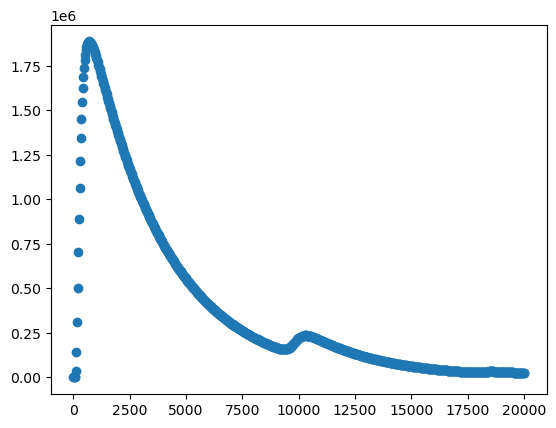

In [ ]:
plt.scatter(full_t, true_full_solution[4])

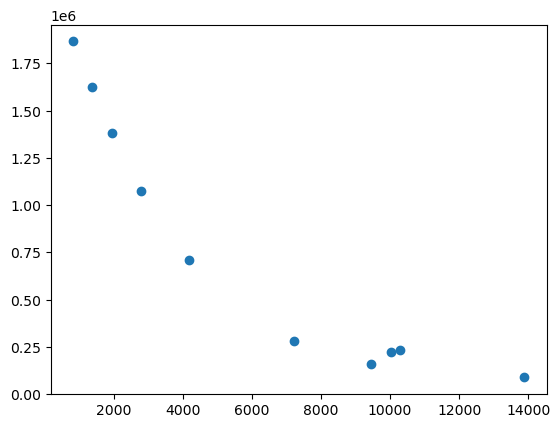

In [ ]:
index_values = index_values2
plt.scatter(full_t[index_values], true_full_solution[4][index_values])

In [ ]:
index_values

array([ 50,  51,  78,  80,  84,  88, 101, 117, 129, 132, 132, 136, 151,
       160, 179, 181, 190, 199, 204, 217, 218, 219, 221, 244, 265, 282,
       287, 300, 300, 306, 323, 338, 343, 360, 373, 374, 378, 389, 393,
       402, 415, 443, 465, 473, 475, 475, 488, 489, 493, 496])

In [ ]:
true_params

{'beta': 4.308e-08,
 'k': 0.0111,
 'd': 0.004169999999999999,
 'p': 0.13644,
 'c': 0.0654,
 'cp': 4e-05,
 'cd': 0.00030000000000000003,
 'ck': 4e-06,
 'r': 0.0001}

In [ ]:
optimized_params

{'beta': 6.462e-08,
 'k': 0.0080117498766643,
 'd': 0.0036655000654584225,
 'p': 0.09058303568451029,
 'c': 0.09229629699763017,
 'cp': 3.836257369580914e-05,
 'cd': 0.0003390405326867785,
 'ck': 2.245266306966188e-06,
 'r': 0.00011855506107480936}

In [ ]:
start_params

{'beta': 3.949e-08,
 'k': 0.010175,
 'd': 0.0038225,
 'p': 0.12507,
 'c': 0.05995,
 'cp': 4.2000000000000004e-05,
 'cd': 0.00032,
 'ck': 4.2e-06,
 'r': 0.0001}

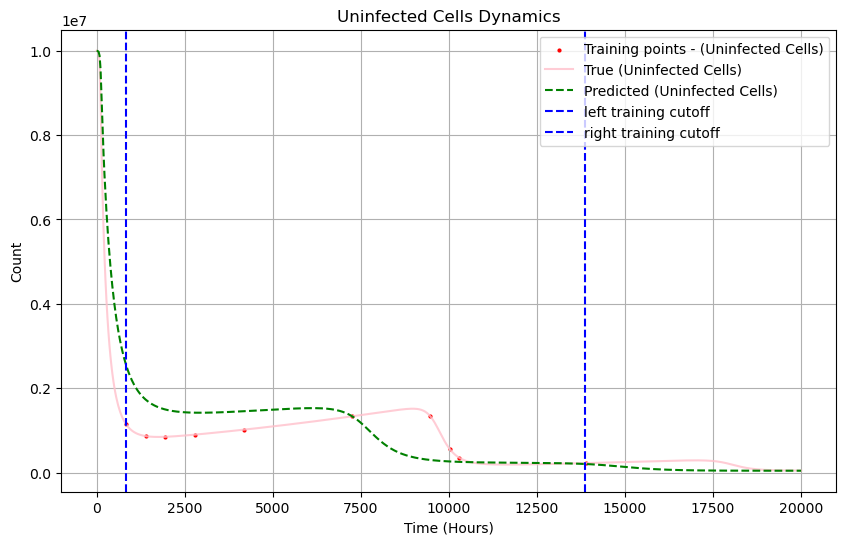

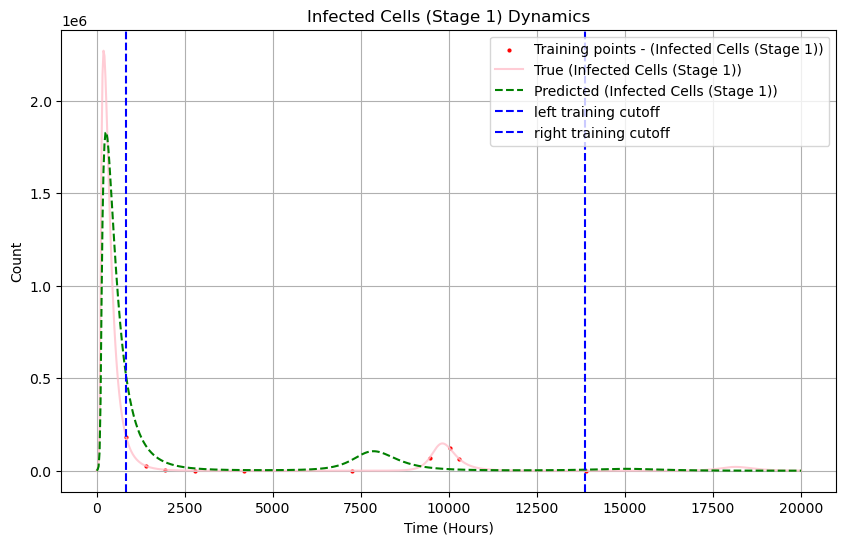

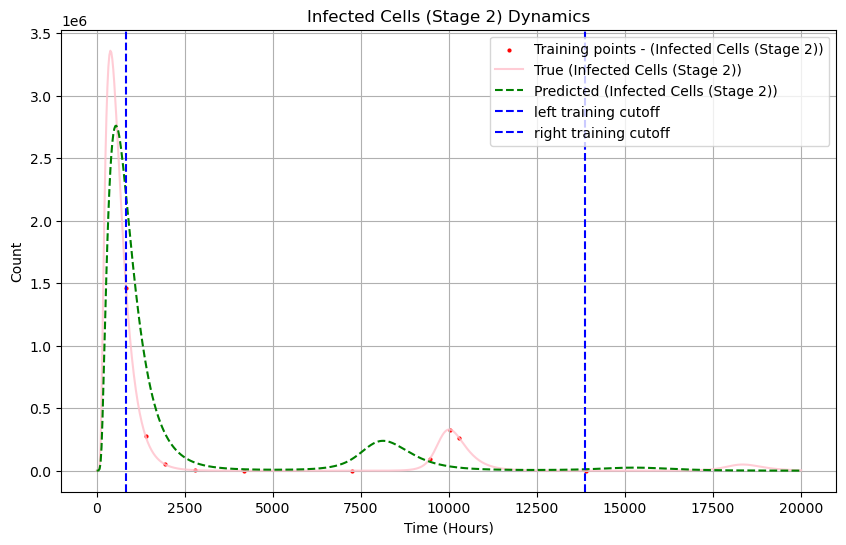

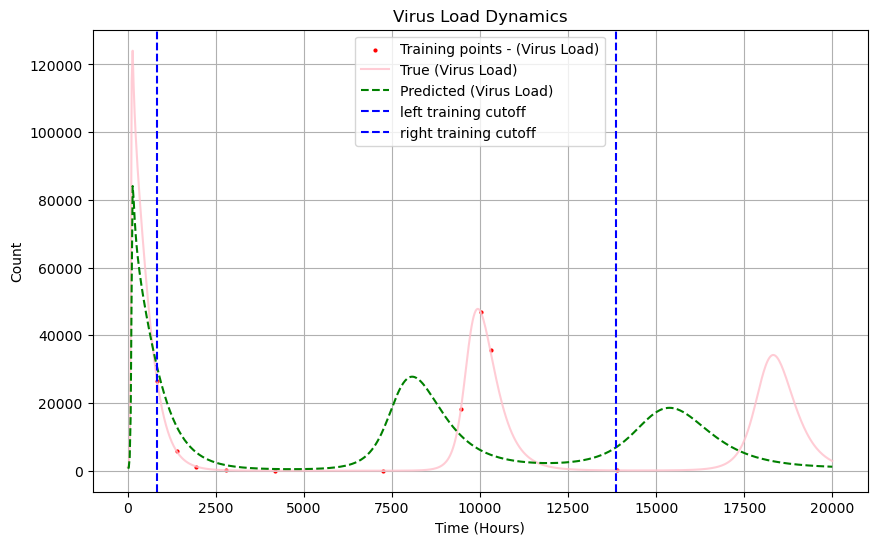

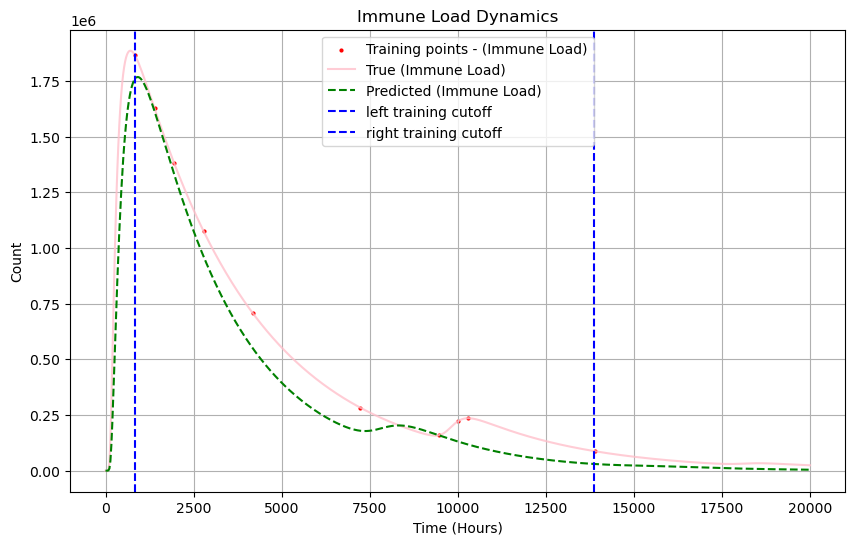

In [ ]:
# Plot results
variables = ["Uninfected Cells", "Infected Cells (Stage 1)", "Infected Cells (Stage 2)", "Virus Load", "Immune Load"]
for i, var in enumerate(variables):
    plt.figure(figsize=(10, 6))
    plt.scatter(t[index_values], true_full_solution[i, index_values], label=f"Training points - ({var})", linestyle="solid", s=4, color='red')
    plt.plot(full_t, true_full_solution[i], label=f"True ({var})", linestyle="solid", color='pink', alpha=0.8)
    plt.plot(full_t, optimized_solution[i], label=f"Predicted ({var})", linestyle="dashed", color='green')
    plt.axvline(x = index_values[0] * (20_000 / 720), color = 'b', label = 'left training cutoff', linestyle="dashed")
    plt.axvline(x = index_values[-1] * (20_000 / 720), color = 'b', label = 'right training cutoff', linestyle="dashed")

    plt.xlabel("Time (Hours)")
    plt.ylabel("Count")
    plt.title(f"{var} Dynamics")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
true_full_solution[i, ::10][:36].shape

(36,)

<Axes: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=1.000e+00)'>

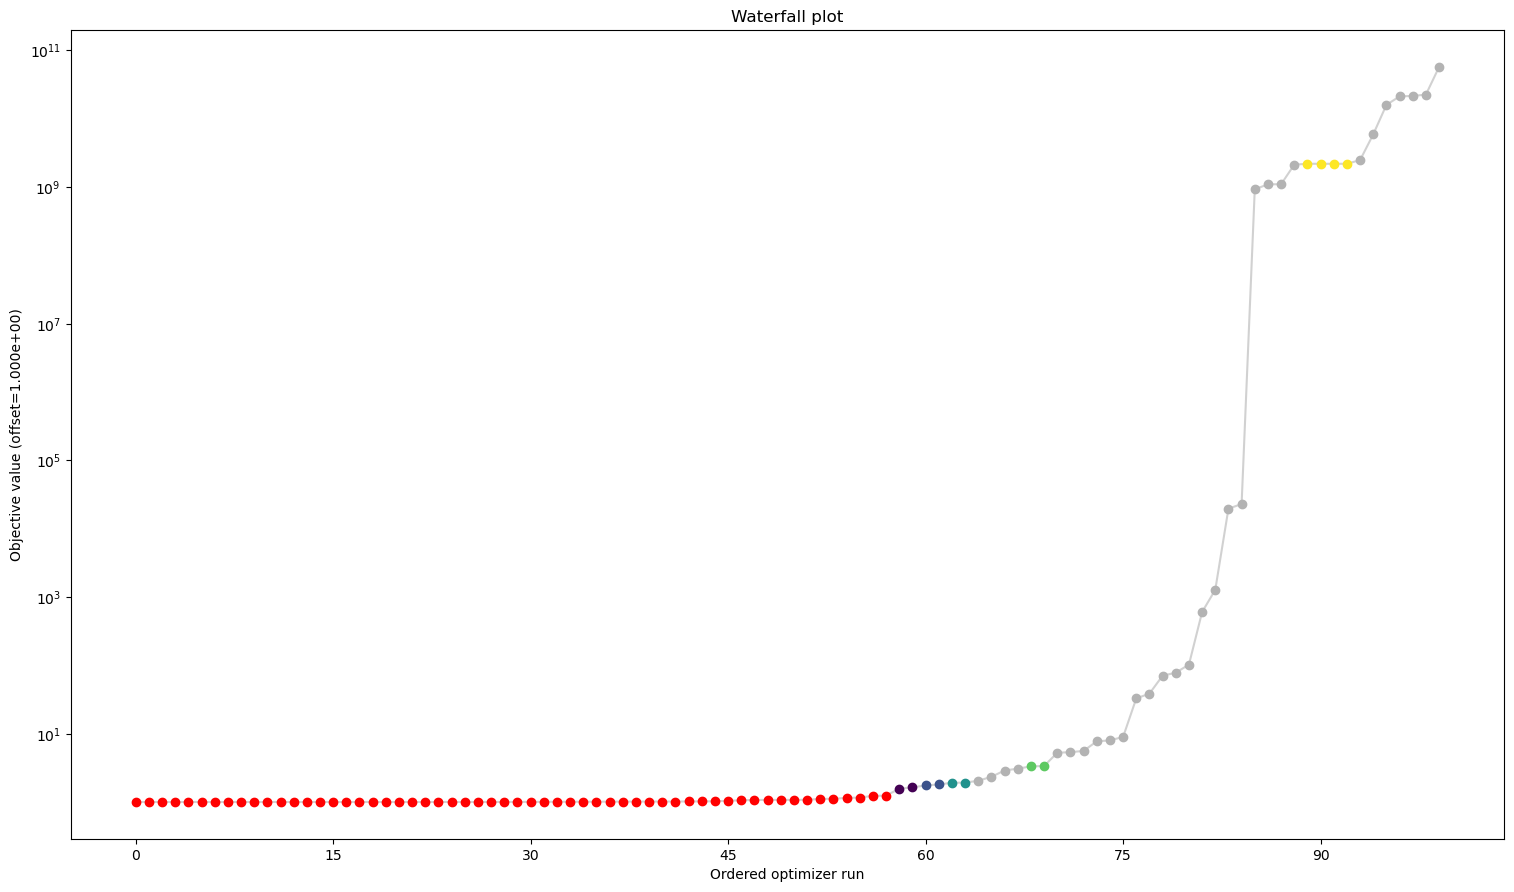

In [ ]:
pypesto.visualize.waterfall(result)


## Model MAEs

### Sigma small

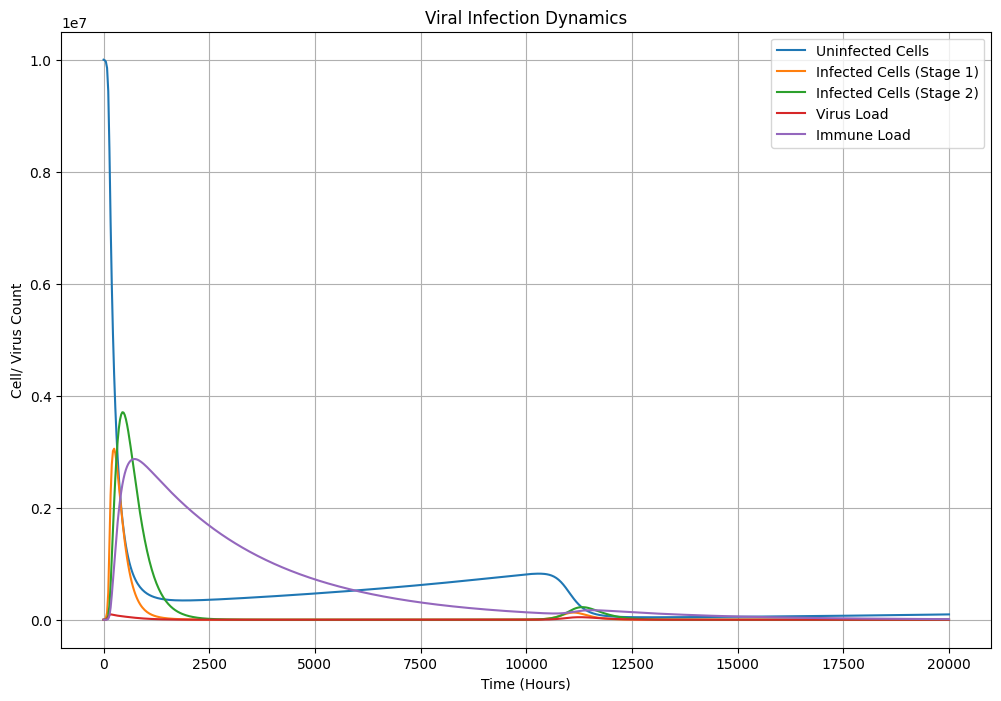

RMSE: 460728.09460919537


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# Initial conditions
U0 = 1e7  # initial uninfected cells
I1_0 = 0  # initial infected cells stage 1
I2_0 = 0  # initial infected cells stage 2
A0 = 0    # initial dead cells
V0 = 1000 # initial virus load
C0 = 0

# Time points (days)
t = np.linspace(0, 20000, 720)  # simulate for 50 days

# Initial state
y0 = [U0, I1_0, I2_0, V0, C0]

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U+I1+I2)/U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

def generate_result(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
  U, I1, I2, V, C = y  # simulate for 50 days
  return odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp ,cd, ck, U0))


results1 = generate_result(y0,t,6.462e-08,0.0080117498766643,0.0036655000654584225,0.09058303568451029,0.09229629699763017,0.00011855506107480936,3.836257369580914e-05,0.0003390405326867785,2.245266306966188e-06, U0)
# Plot results

def plot_result(result):
  U, I1, I2, V, C = result.T
  plt.figure(figsize=(12, 8))
  plt.plot(t, U, label='Uninfected Cells')
  plt.plot(t, I1, label='Infected Cells (Stage 1)')
  plt.plot(t, I2, label='Infected Cells (Stage 2)')
  plt.plot(t, V, label='Virus Load')
  plt.plot(t, C, label='Immune Load')
  plt.xlabel('Time (Hours)')
  plt.ylabel('Cell/ Virus Count')
  plt.legend()
  plt.title('Viral Infection Dynamics')
  plt.grid()
  plt.show()

plot_result(results1)

def calculate_dif(res1, res2):
  U1, _, _, _, _ = res1.T
  U2, _, _, _, _ = res2.T

  print(f"RMSE: {np.sqrt(np.mean((U1-U2)**2))}")

calculate_dif(solution, results1)

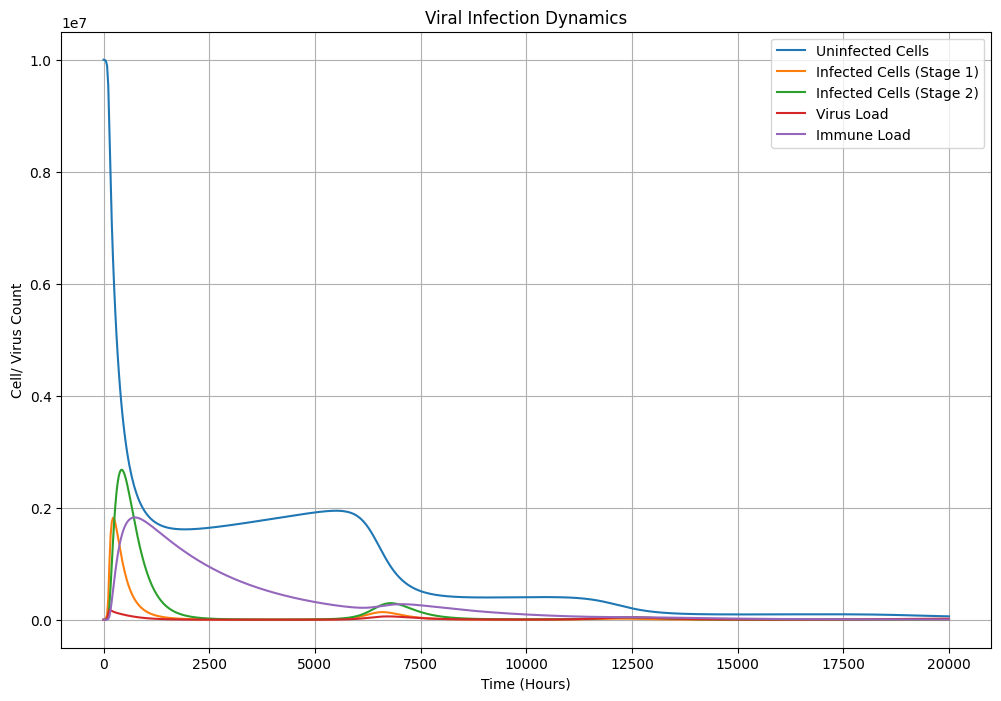

RMSE: 602412.6766165664


In [ ]:
results2 = generate_result(y0,t,2.154e-08,0.01084377061649434,0.00447800880801295,0.20371237173878093,0.05301844084910261,8.98434653583887e-05,4.814110220944816e-05,0.0004400422832274877,3.64749824021482e-06, U0)
plot_result(results2)
calculate_dif(solution, results2)


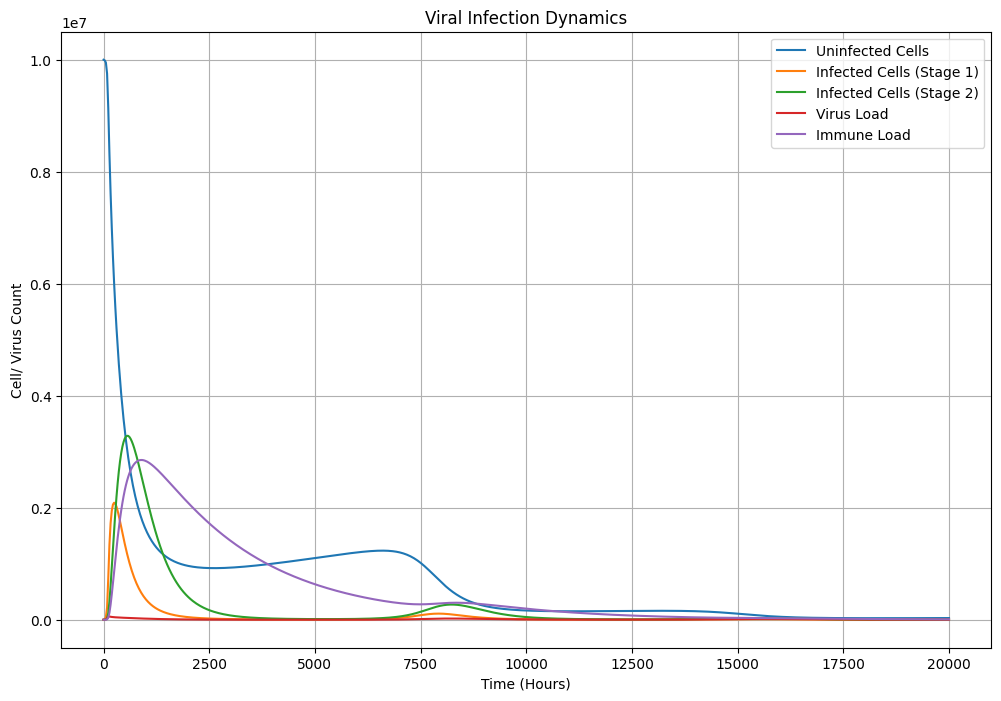

RMSE: 443329.6808469602


In [ ]:
results3 = generate_result(y0,t,5.8785362216307296e-08,0.007523508500248229,0.0026320355084279907,0.11379237849055118,0.06632660938434062,0.00013667317541879323,4.7927265184393525e-05,0.00040423646663344395,4.629640939159198e-06, U0)
plot_result(results3)
calculate_dif(solution, results3)

### Sigmal Medium

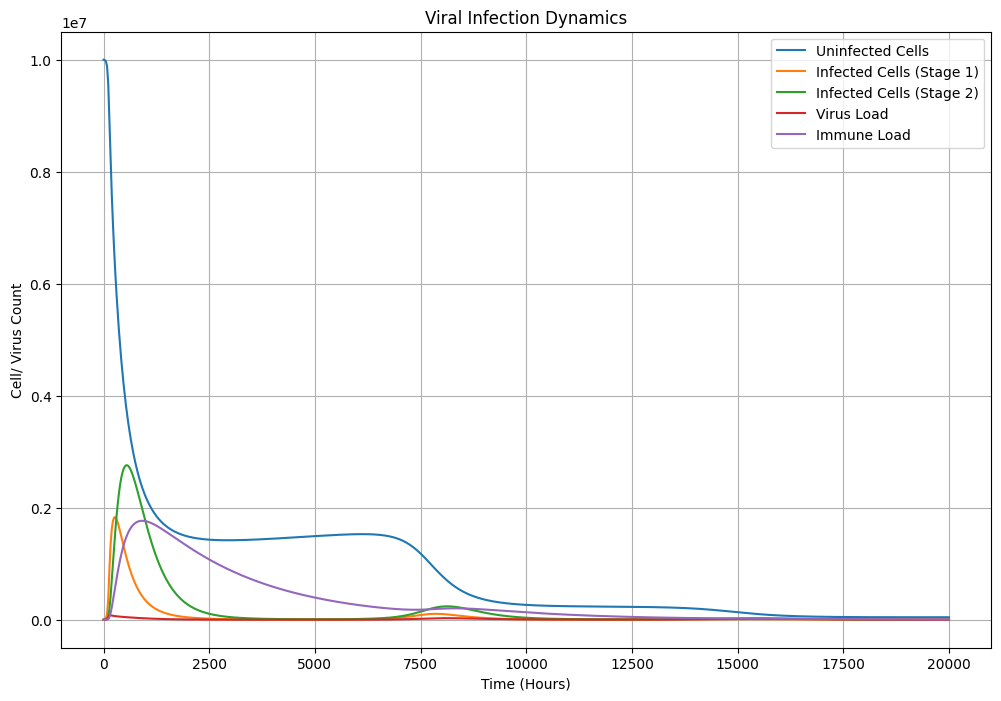

RMSE: 565817.5619179987


In [ ]:
results4 = generate_result(y0,t,3.5535494123623875e-08,0.007982750388969511,0.0031655467861197253,0.13688228435247357,0.05850838263139818,5.679912249923055e-05,3.523557153638079e-05,0.0004048869421043719,5.58997804794434e-06, U0)
plot_result(results4)
calculate_dif(solution, results4)

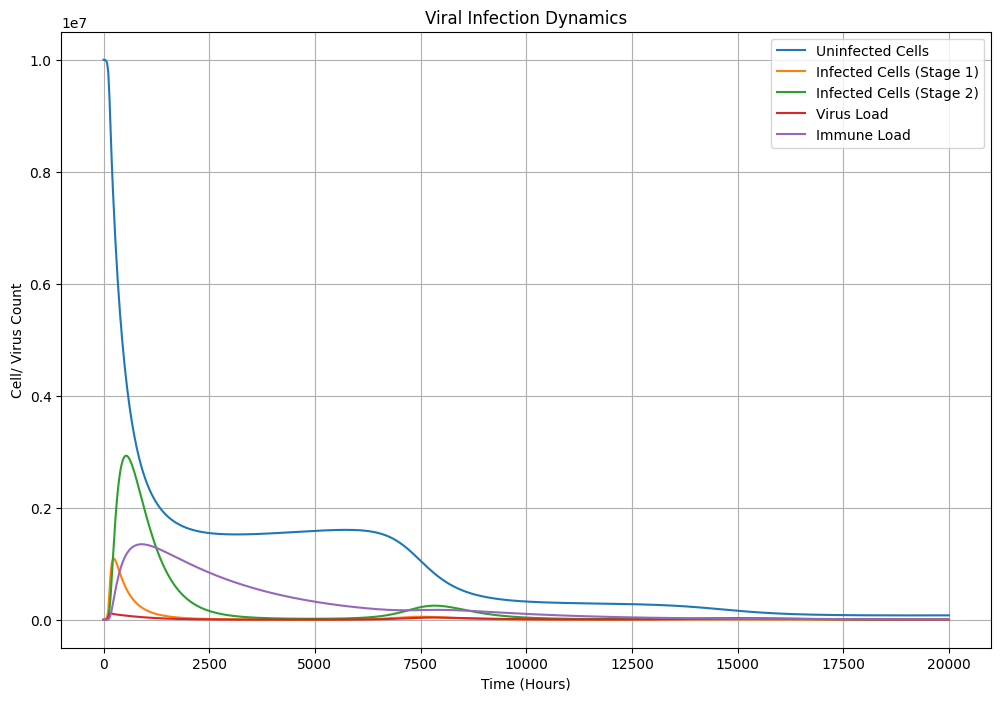

RMSE: 662789.9817197312


In [ ]:
results5 = generate_result(y0,t,2.154e-08,0.01470856645464355,0.002811814962492854,0.17508858467097202,0.09614484705068763,6.857743581049868e-05,6.000000000000001e-05,0.00039170342873431284,6.0e-06, U0)
plot_result(results5)
calculate_dif(solution, results5)

### Sigma big

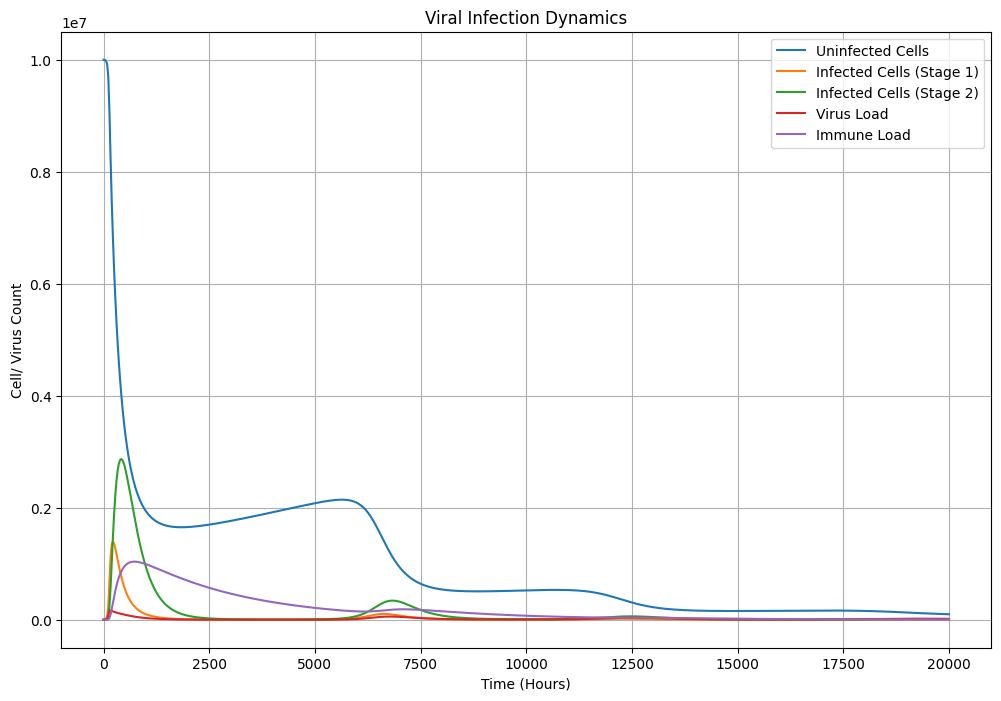

RMSE: 633816.880688436


In [ ]:
results6 = generate_result(y0,t,2.154e-08,0.015671321513850055,0.004236816594035311,0.13021886651669187,0.059127819889072515,0.00011513955735782672,4.237850020095245e-05,0.0003985058672576522,4.097536038398761e-06, U0)
plot_result(results6)
calculate_dif(solution, results6)

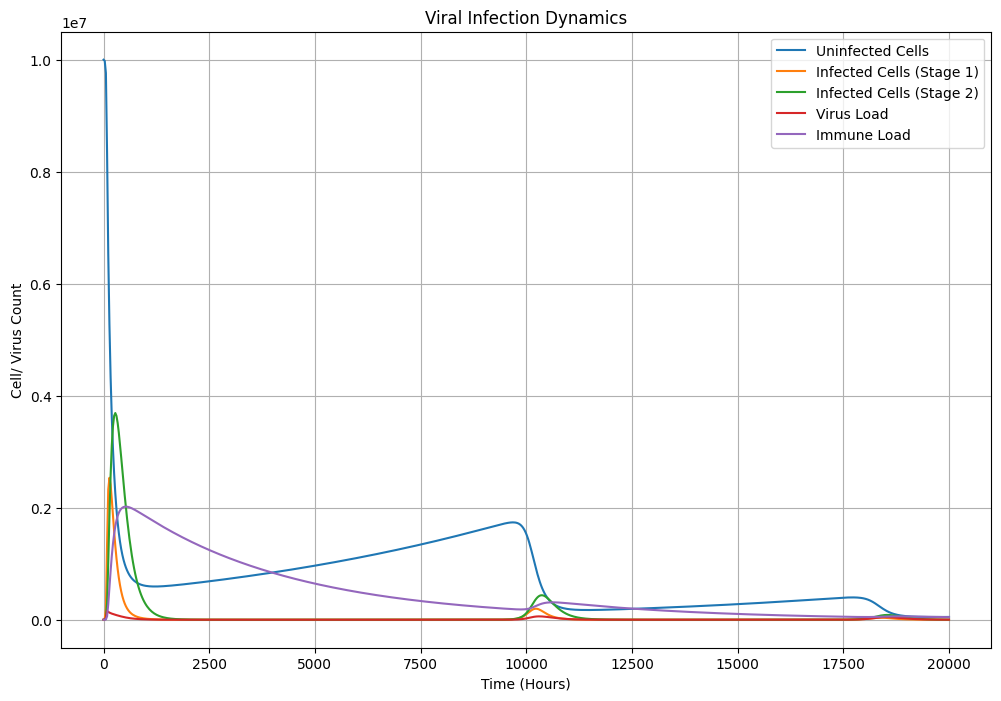

RMSE: 338604.6937180517


In [ ]:
results7 = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,0.005531607325236635,0.18882178337606947,0.0693554120596835,0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,4.687055800442963e-06, U0)
plot_result(results7)
calculate_dif(solution, results7)

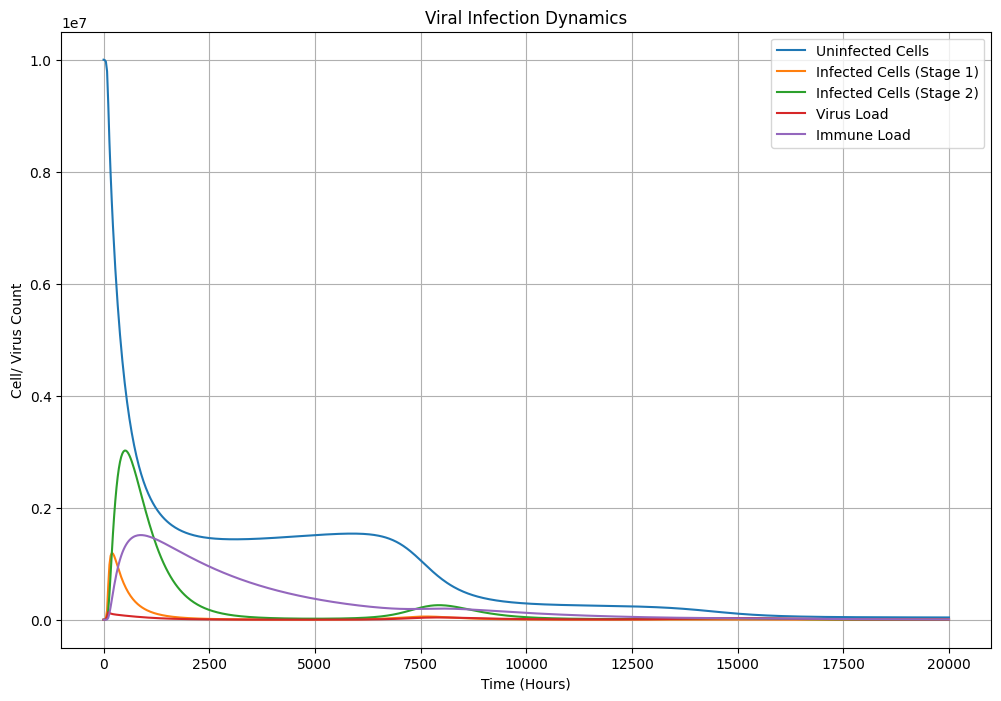

RMSE: 596943.2893526038


In [ ]:
results8 = generate_result(y0,t,2.154e-08,0.01363482481734917,0.0026696072899521145,0.18935514278215035,0.0338476389472138,7.770350444920921e-05,6.000000000000001e-05,0.0003819657007232067,6.0e-06, U0)
plot_result(results8)
calculate_dif(solution, results8)

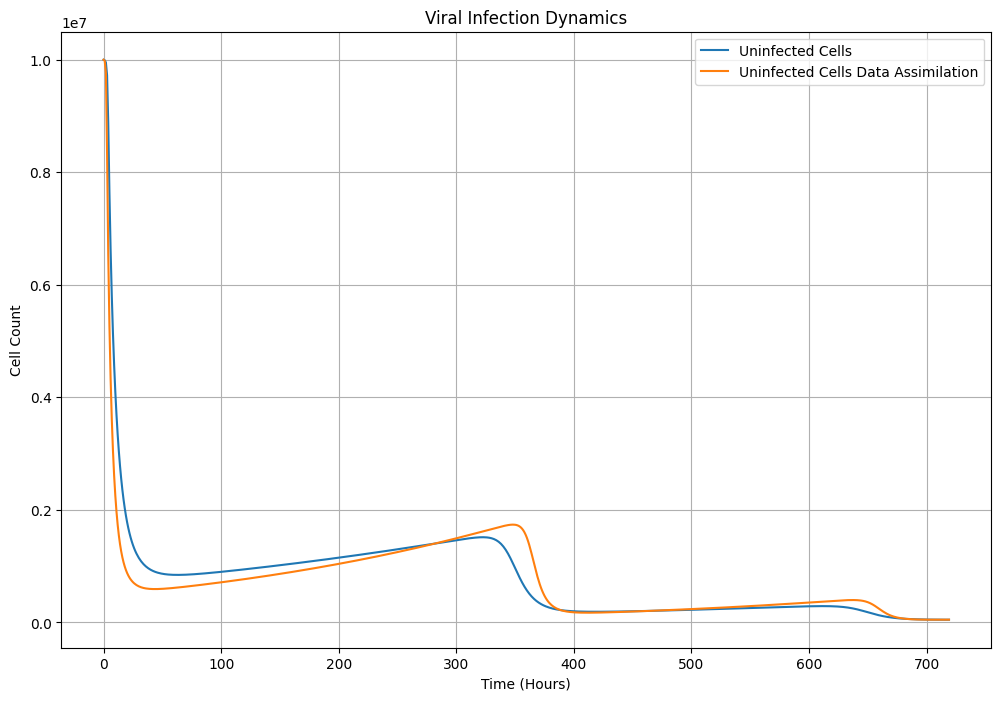

In [ ]:
U, _, _, _, _ = solution.T
U_r, _, _, _, _ = results7.T
t = np.arange(0,U.shape[0])
plt.figure(figsize=(12, 8))
plt.plot(t, U, label='Uninfected Cells')
plt.plot(t, U_r, label='Uninfected Cells Data Assimilation')
plt.xlabel('Time (Hours)')
plt.ylabel('Cell Count')
plt.legend()
plt.title('Viral Infection Dynamics')
plt.grid()
plt.show()

## Surogate Model

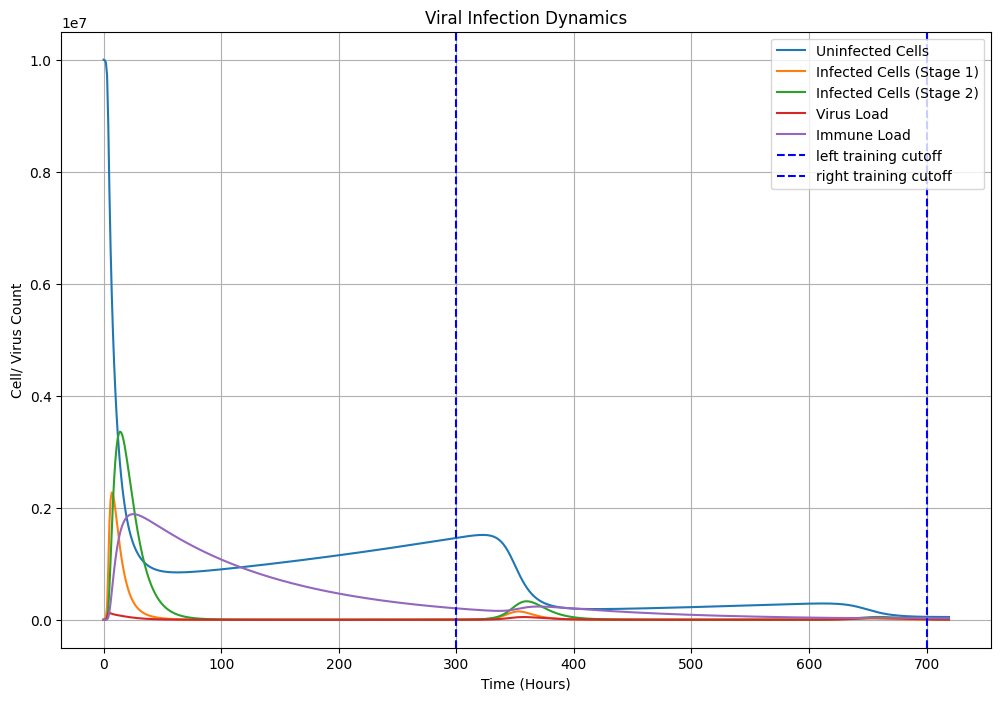

In [ ]:
def plot_accurate(result, start, stop):
  U, I1, I2, V, C = result.T
  t = np.arange(0,U.shape[0])
  plt.figure(figsize=(12, 8))
  plt.plot(t, U, label='Uninfected Cells')
  plt.plot(t, I1, label='Infected Cells (Stage 1)')
  plt.plot(t, I2, label='Infected Cells (Stage 2)')
  plt.plot(t, V, label='Virus Load')
  plt.plot(t, C, label='Immune Load')
  plt.axvline(x = start, color = 'b', label = 'left training cutoff', linestyle="dashed")
  plt.axvline(x = stop, color = 'b', label = 'right training cutoff', linestyle="dashed")
  plt.xlabel('Time (Hours)')
  plt.ylabel('Cell/ Virus Count')
  plt.legend()
  plt.title('Viral Infection Dynamics')
  plt.grid()
  plt.show()

plot_accurate(solution,300,700)

In [ ]:
def viral_infection_model(y, t, beta, k, d, p, c, r, cp, cd, ck, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U+I1+I2)/U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

In [ ]:
def viral_infection_surrogate_model(y, t, beta, k, d, c, p, U_max):
    U, I1, I2, V = y
    dU_dt = -beta * U * V + 1e-4* (1 - (U+I1+I2)/U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V
    return [dU_dt, dI1_dt, dI2_dt, dV_dt]

In [75]:
import pypesto
import pypesto.optimize as optimize

def simulate_model(params):
    beta, k, d, c, p, V0 = params
    solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
    return solution

def objective_function(x):
    simulated = simulate_model(x)
    residuals = observed_data_ - simulated[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]
    return np.sum(residuals**2)

ModuleNotFoundError: No module named 'pypesto'

In [ ]:
solution.shape

(720, 5)

In [ ]:

# Define the objective function for pyPESTO


paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 10
UPPER_TIME_BOUND = 110
STEP = 3

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 2* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 2* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*4
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params = result.optimize_result.list[0]['x']
optimized_solution = simulate_model(optimized_params)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-12-55065e204268>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
  2%|▏         | 2/100 [00:12<10:59,  6.73s/it]<ipython-input-8-c4f4eb01a59a>:3: RuntimeWarning: invalid value encountered in scalar multiply
  dU_dt = -beta * U * V + 1e-4* (1 - (U+I1+I2)/U_max) * U
<ipython-input-8-c4f4eb01a59a>:4: RuntimeWarning: invalid value encountered in scalar multiply
  dI1_dt = beta * U * V - k * I1
<ipython-input-12-55065e204268>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-12-55065e204268>:6: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run w

KeyboardInterrupt: 

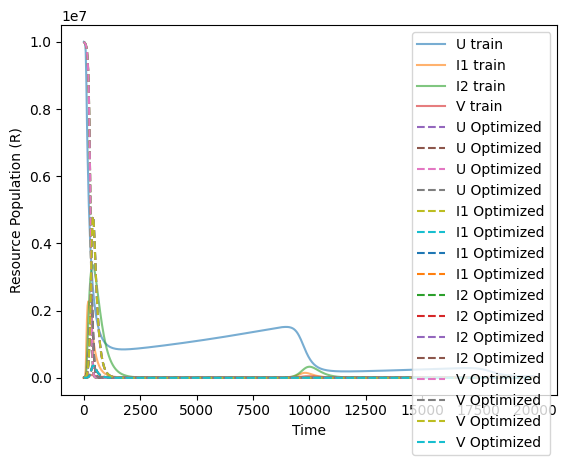

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution, label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution, label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution, label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution, label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Optimized Parameters:
[3.15400000e-08 6.74717124e-03 2.08500000e-03 8.75632686e-02
 7.26301863e-02 2.32064028e+03]


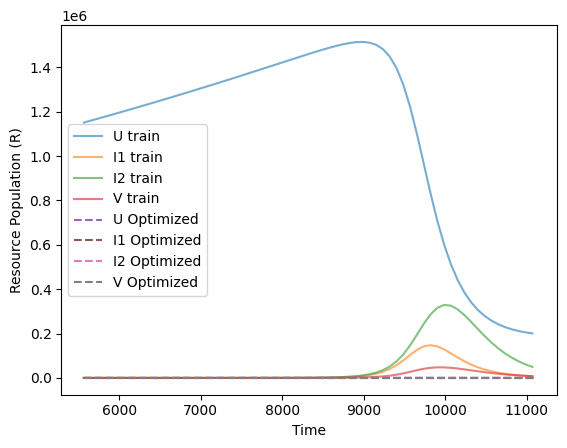

In [ ]:
paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 400
STEP = 3

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - .5* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + .5* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*4
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params2 = result.optimize_result.list[0]['x']
optimized_solution2 = simulate_model(optimized_params2)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution2[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution2[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution2[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution2[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

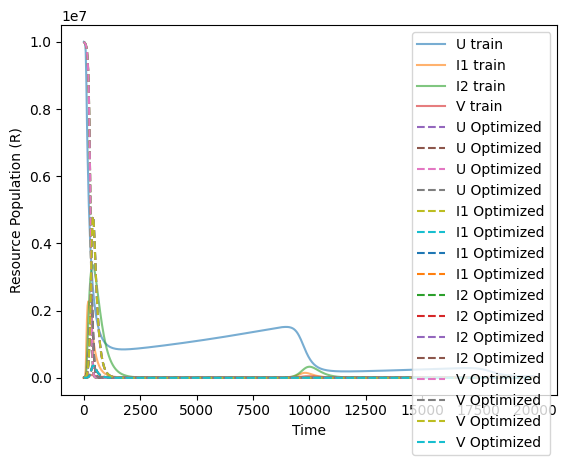

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution2, label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution2, label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution2, label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution2, label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


Optimized Parameters:
[2.1540000e-08 5.5500000e-03 2.0850000e-03 3.2700000e-02 2.0465999e-01
 5.0000000e+02]


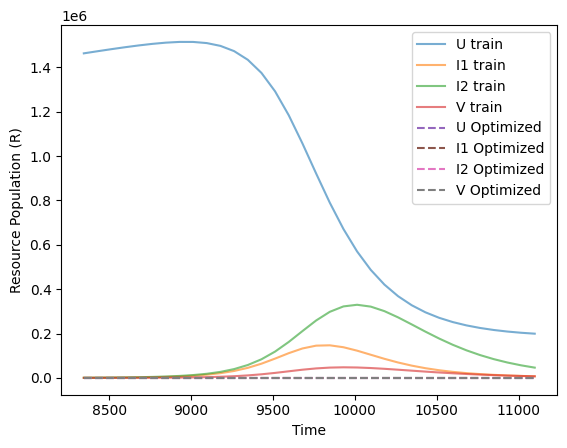

In [ ]:
paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 3

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - .5* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + .5* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*4
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params2 = result.optimize_result.list[0]['x']
optimized_solution2 = simulate_model(optimized_params2)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution2[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution2[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution2[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution2[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

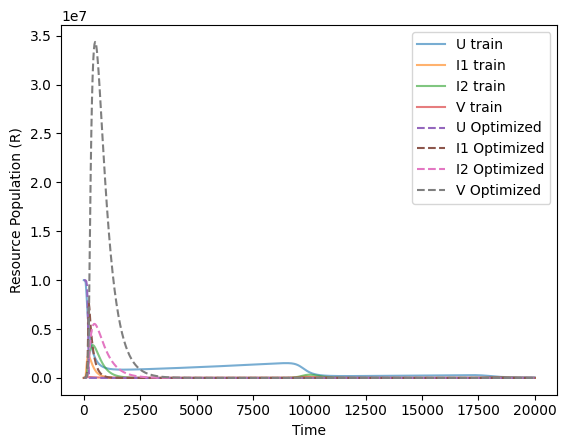

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution2[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution2[:,1], label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution2[:,2], label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution2[:,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Optimized Parameters:
[2.1540000e-08 5.5500000e-03 2.0850000e-03 3.2700000e-02 2.0465999e-01
 5.0000000e+02]


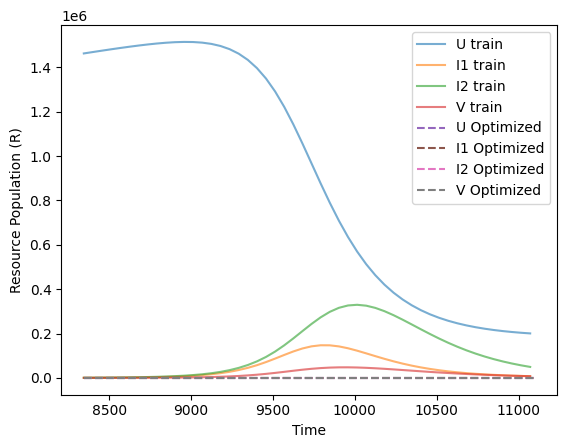

In [ ]:
paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 2

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - .5* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + .5* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*4
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params3 = result.optimize_result.list[0]['x']
optimized_solution3 = simulate_model(optimized_params3)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution3[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution3[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution3[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution3[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:12: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2)
  1%|          | 1/100 [00:00<00:36,  2.70it/s]<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-11-c4f4eb01a59a>:3: RuntimeWarning: invalid value encountered in scalar multiply
  dU_dt = -beta * U * V + 1e-4* (1 - (U+I1+I2)/U_max) * U
<ipython-input-11-c4f4eb01a59a>:4: RuntimeWarning: invalid value encountered in scalar multiply
  dI1_dt = bet

Optimized Parameters:
[1.21609923e-07 1.02320655e-02 1.12608937e-02 2.82625333e-01
 8.44369743e-03 5.53080865e+05]


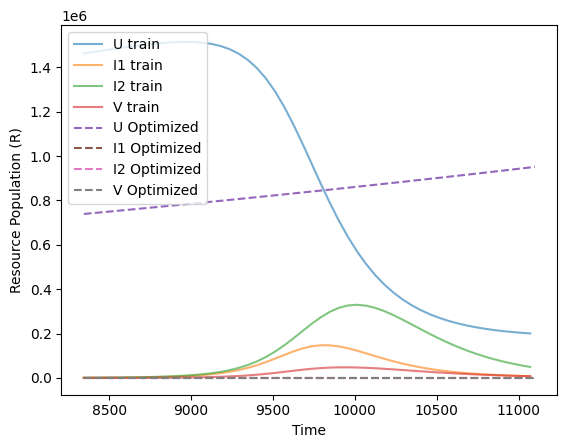

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 2

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params4 = result.optimize_result.list[0]['x']
optimized_solution4 = simulate_model(optimized_params4)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

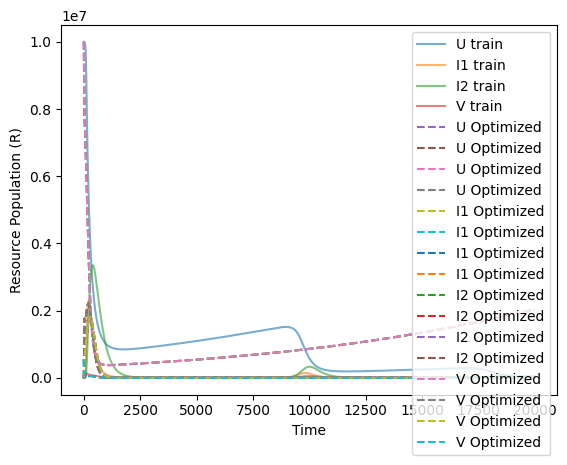

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution4, label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution4, label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution4, label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution4, label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

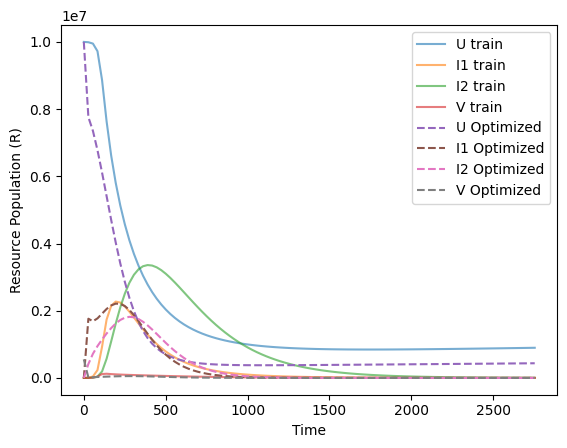

In [ ]:
LOWER_TIME_BOUND =  0
UPPER_TIME_BOUND = 100

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  1%|          | 1/100 [00:00<00:11,  8.32it/s]<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
  2%|▏         | 2/100 [00:28<26:55, 16.49s/it]<ipython-input-10-a751ebb1b858>:12: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quanti

Optimized Parameters:
[1.02374036e-07 2.59015929e-02 1.83818523e-02 9.69203030e-02
 1.32685341e-02 8.90814673e+05]


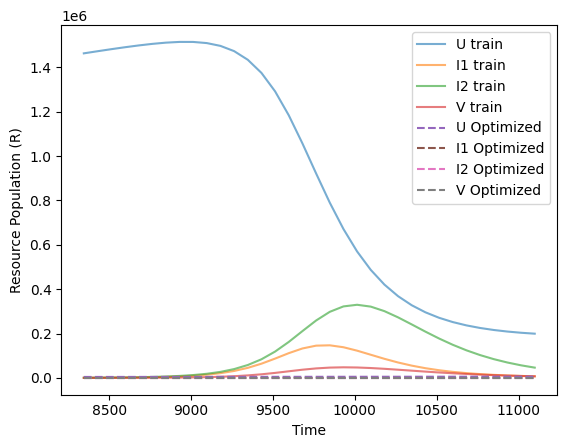

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 3

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params5 = result.optimize_result.list[0]['x']
optimized_solution5 = simulate_model(optimized_params5)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution5[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution5[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution5[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution5[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  1%|          | 1/100 [00:03<05:10,  3.14s/it]<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:12: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py

Optimized Parameters:
[5.91750439e-08 4.98533426e-02 1.80278190e-02 1.94084497e-01
 1.04083415e-01 4.29336958e+05]


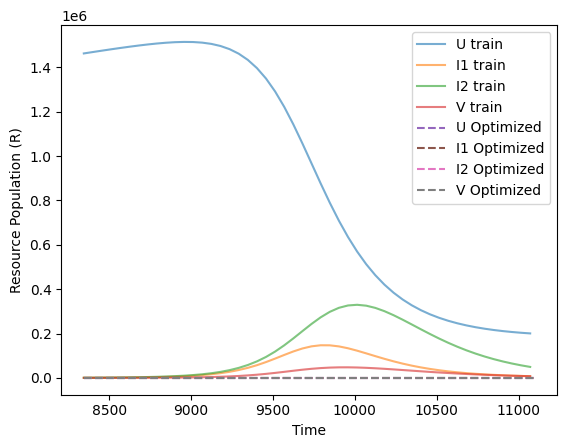

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 2

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(method='tnc'))

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params4 = result.optimize_result.list[0]['x']
optimized_solution4 = simulate_model(optimized_params4)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution4[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 2

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ESSOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params7 = result.optimize_result.list[0]['x']
optimized_solution7 = simulate_model(optimized_params7)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution7[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution7[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution7[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution7[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

ValueError: Either `max_iter`, `max_eval` or `max_walltime_s` have to be provided.

In [ ]:
def objective_function(x):
    simulated = simulate_model(x)
    residuals = observed_data_[:,0] - simulated[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0]
    return np.sum(residuals**2)

  1%|          | 1/100 [00:00<00:13,  7.61it/s]<ipython-input-11-c4f4eb01a59a>:3: RuntimeWarning: invalid value encountered in scalar multiply
  dU_dt = -beta * U * V + 1e-4* (1 - (U+I1+I2)/U_max) * U
<ipython-input-11-c4f4eb01a59a>:4: RuntimeWarning: invalid value encountered in scalar multiply
  dI1_dt = beta * U * V - k * I1
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitati

Optimized Parameters:
[2.15666459e-08 2.27115356e-03 9.40524450e-03 2.33891438e-01
 3.20501893e-02 6.33154982e+05]


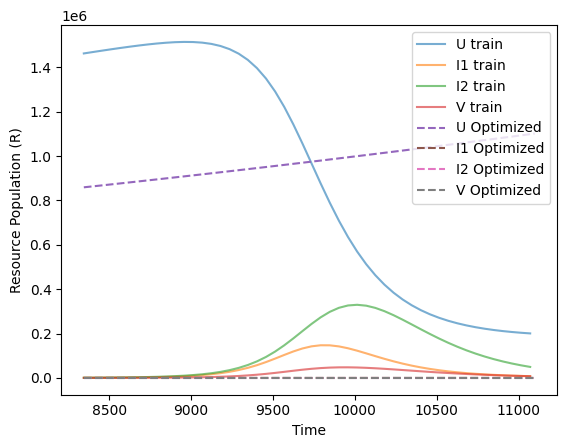

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 2

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:, :4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params7 = result.optimize_result.list[0]['x']
optimized_solution7 = simulate_model(optimized_params7)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution7[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution7[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution7[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution7[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 2

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]

optimized_solution7 = simulate_model((2.15666459e-08, 2.27115356e-03, 9.40524450e-03, 2.33891438e-01,
 3.20501893e-02, 6.33154982e+05))

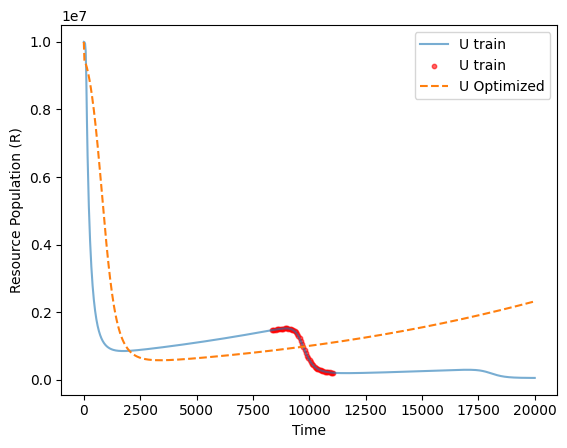

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.scatter(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6, s=10, c='r')
plt.plot(t, optimized_solution7[:,0], label="U Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

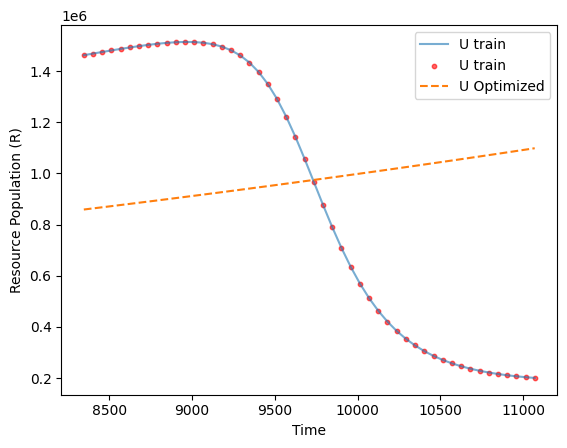

In [ ]:
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6)
plt.scatter(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6, s=10, c='r')
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], optimized_solution7[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

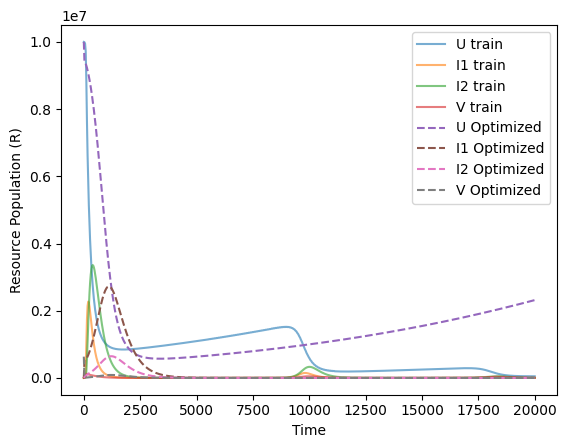

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution7[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution7[:,1], label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution7[:,2], label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution7[:,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  1%|          | 1/100 [00:00<00:10,  9.05it/s]<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
  5%|▌         | 5/100 [00:00<00:11,  8.48it/s]<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
  8%|▊         | 8/100 [00:10<03:11,  2.08s/it]<ipython-input-11-c4f4eb01a59a>:3: RuntimeWarning: invalid value encountered in scalar multip

Optimized Parameters:
[2.61439079e-08 8.00237621e-03 1.44186675e-02 1.99337899e-01
 3.66318414e-02 4.93356699e+05]


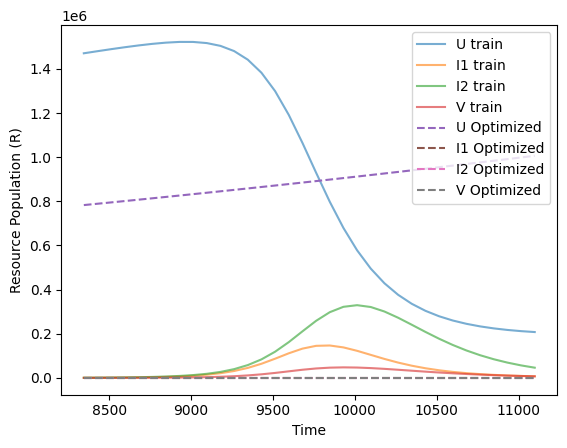

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 3

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100)

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params8 = result.optimize_result.list[0]['x']
optimized_solution8 = simulate_model(optimized_params8)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution8[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution8[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution8[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution8[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 3

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]

optimized_solution8 = simulate_model((2.61439079e-08, 8.00237621e-03, 1.44186675e-02, 1.99337899e-01,
 3.66318414e-02, 4.93356699e+05))

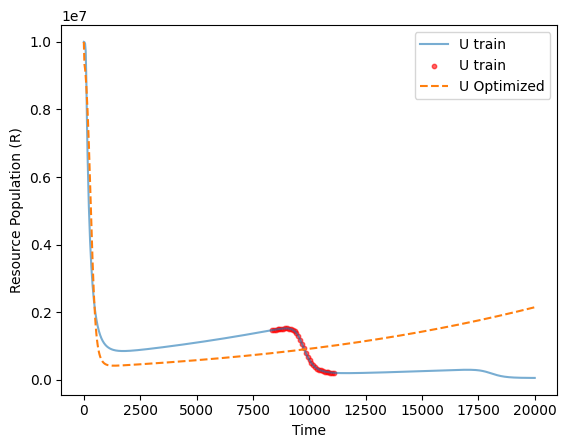

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.scatter(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6, s=10, c='r')
plt.plot(t, optimized_solution8[:,0], label="U Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

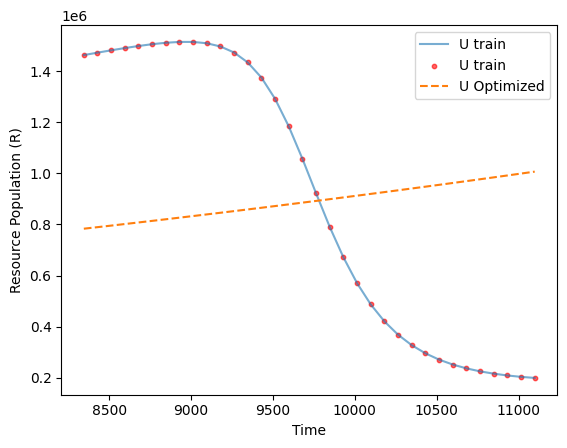

In [ ]:
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6)
plt.scatter(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6, s=10, c='r')
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], optimized_solution8[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

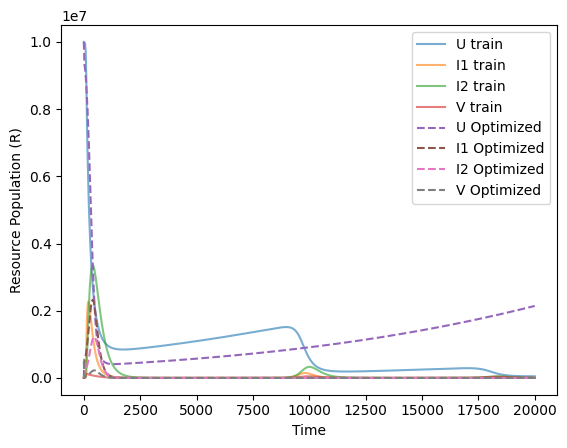

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution8[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution8[:,1], label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution8[:,2], label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution8[:,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

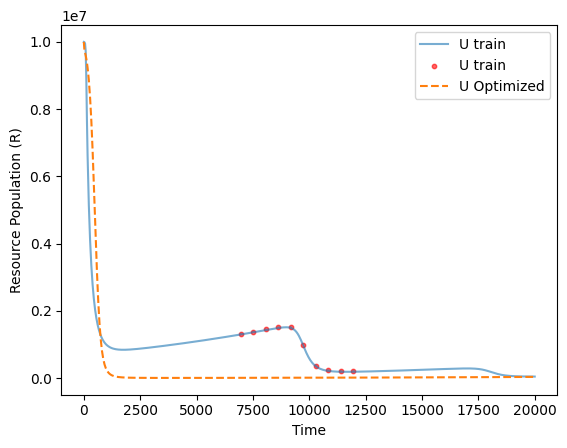

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.scatter(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6, s=10, c='r')
plt.plot(t, optimized_solution12[:,0], label="U Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-6-c4f4eb01a59a>:3: RuntimeWarning: invalid value encountered in scalar multiply
  dU_dt = -beta * U * V + 1e-4* (1 - (U+I1+I2)/U_max) * U
<ipython-input-6-c4f4eb01a59a>:4: RuntimeWarning: invalid value encountered in scalar multiply
  dI1_dt = beta * U * V - k * I1
<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
  2%|▏         | 2/100 [00:04<03:42,  2.27s/it]<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with

Optimized Parameters:
[1.17968983e-08 4.38365579e-02 1.51254848e-03 1.38678123e-01
 1.31366495e-02 3.10379732e+05]


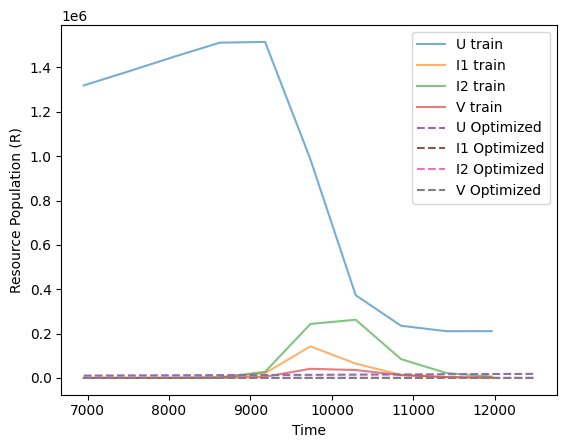

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 250
UPPER_TIME_BOUND = 450
STEP = 20

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100)

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params12 = result.optimize_result.list[0]['x']
optimized_solution12 = simulate_model(optimized_params12)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution12[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution12[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution12[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution12[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

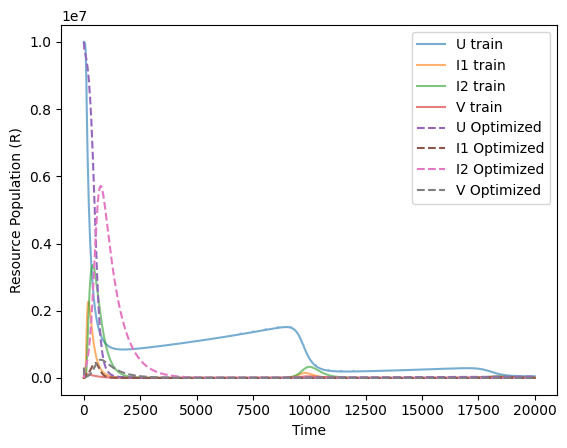

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution12[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution12[:,1], label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution12[:,2], label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution12[:,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

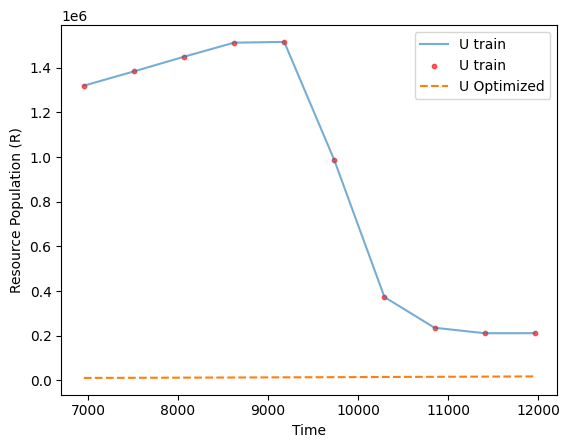

In [ ]:
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6)
plt.scatter(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6, s=10, c='r')
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], optimized_solution12[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
def viral_infection_surrogate_model(y, t, beta, k, d, c, p, U_max):
    U, I1, I2, V = y
    dU_dt = -beta * U * V + 1e-4* (1 - (U+I1+I2)/U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V ** 1.3
    return [dU_dt, dI1_dt, dI2_dt, dV_dt]

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-32-f61e317edbc3>:6: RuntimeWarning: invalid value encountered in scalar power
  dV_dt = p * I2 - c * V ** 1.3
<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
  1%|          | 1/100 [00:02<04:52,  2.96s/it]<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
  3%|▎         

Optimized Parameters:
[1.57154039e-07 3.36721301e-02 1.81797688e-02 2.55619172e-01
 1.99725640e-01 2.44704017e+05]


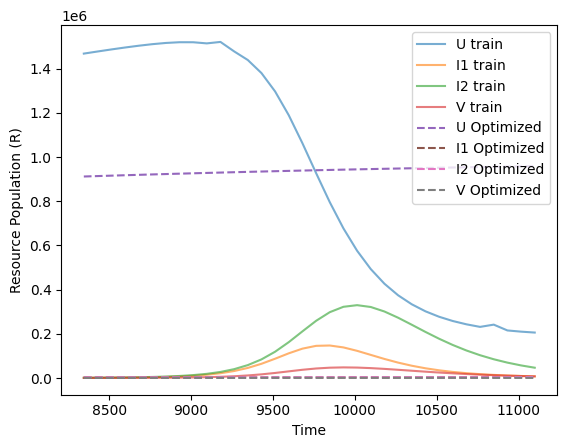

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 3

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100)

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params13 = result.optimize_result.list[0]['x']
optimized_solution13 = simulate_model(optimized_params13)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution13[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution13[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution13[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution13[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

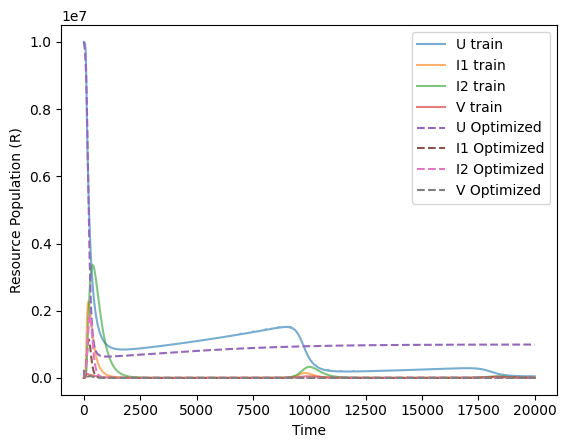

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution13[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution13[:,1], label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution13[:,2], label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution13[:,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-32-f61e317edbc3>:6: RuntimeWarning: invalid value encountered in scalar power
  dV_dt = p * I2 - c * V ** 1.3
<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
  2%|▏         | 2/100 [00:25<17:55, 10.97s/it]<ipython-input-7-a751ebb1b

Optimized Parameters:
[3.36886413e-08 3.01371823e-02 2.00219886e-02 8.77459658e-02
 6.50957614e-01 1.62656173e+05]


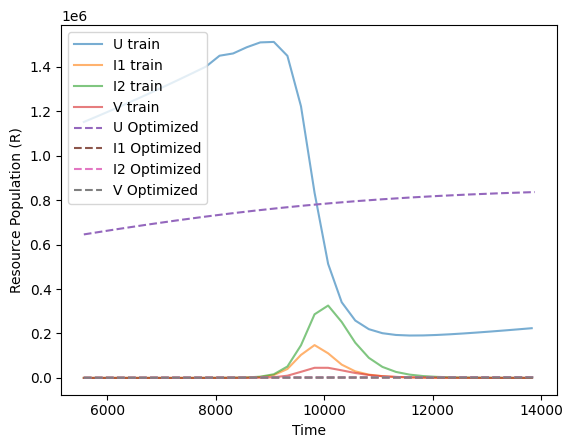

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 9

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100)

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params14 = result.optimize_result.list[0]['x']
optimized_solution14 = simulate_model(optimized_params14)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

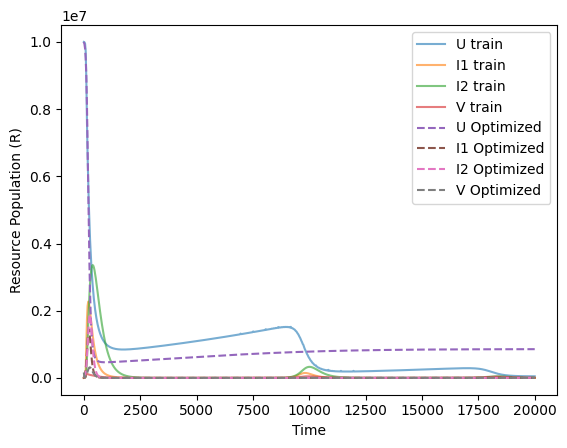

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution14[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,1], label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,2], label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 9

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]

optimized_solution14 = simulate_model((3.36886413e-08, 3.01371823e-02, 2.00219886e-02, 8.77459658e-02
 ,6.50957614e-01, 1.62656173e+05))

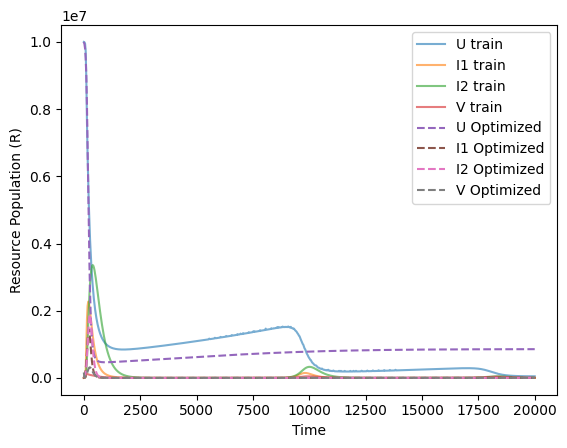

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution14[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,1], label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,2], label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

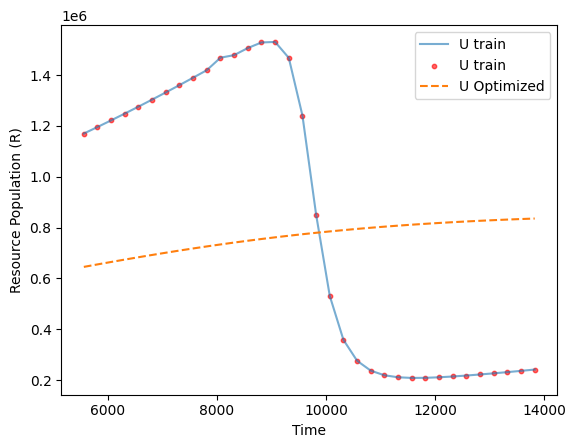

In [ ]:
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6)
plt.scatter(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6, s=10, c='r')
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

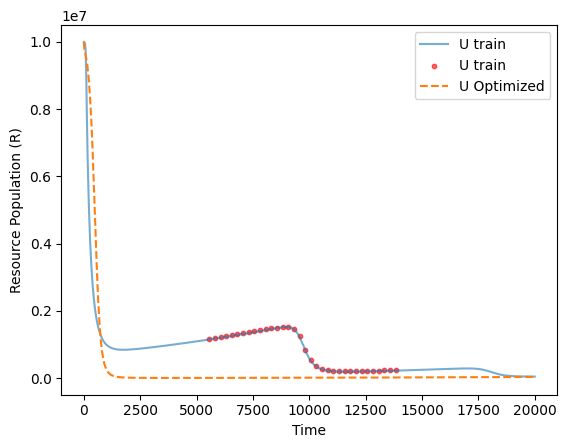

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.scatter(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0], label="U train", alpha=0.6, s=10, c='r')
plt.plot(t, optimized_solution12[:,0], label="U Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
def objective_function(x):
    simulated = simulate_model(x)
    residuals = observed_data_ - simulated[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]
    return np.sum(residuals**2)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-32-f61e317edbc3>:6: RuntimeWarning: invalid value encountered in scalar power
  dV_dt = p * I2 - c * V ** 1.3
<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-38-8e086c7fc641>:4: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  2%|▏         | 2/100 [00:09<08:41,  5.33s/it]<ipython-input-7-a751ebb1b858>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
  9%|▉         

Optimized Parameters:
[1.28888253e-07 5.03469842e-02 2.07886004e-02 3.08699113e-01
 3.88262944e-01 9.83960811e+05]


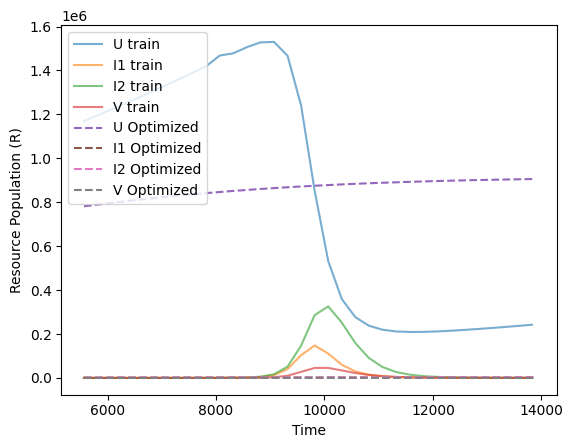

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 9

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100)

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params14 = result.optimize_result.list[0]['x']
optimized_solution14 = simulate_model(optimized_params14)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

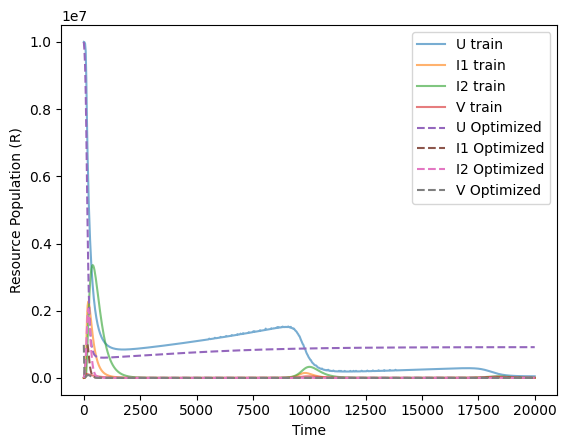

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="I1 train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="I2 train", alpha=0.6)
plt.plot(t, observed_data[:,3], label="V train", alpha=0.6)
plt.plot(t, optimized_solution14[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,1], label="I1 Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,2], label="I2 Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

## Data Distilation

In [ ]:
def objective_function(x):
    simulated = simulate_model(x)
    residuals = observed_data_[:,0] - simulated[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0]
    residuals_gen = observed_data_gen_[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0] - simulated[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0]
    return np.sum(residuals**2 + residuals_gen**2) / 2

  2%|▏         | 2/100 [00:00<00:20,  4.78it/s]<ipython-input-11-c4f4eb01a59a>:3: RuntimeWarning: invalid value encountered in scalar multiply
  dU_dt = -beta * U * V + 1e-4* (1 - (U+I1+I2)/U_max) * U
<ipython-input-11-c4f4eb01a59a>:4: RuntimeWarning: invalid value encountered in scalar multiply
  dI1_dt = beta * U * V - k * I1
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-11-c4f4eb01a59a>:6: RuntimeWarning: invalid value encountered in scalar subtract
  dV_dt = p * I2 - c * V
  5%|▌         | 5/100 [00:03<00:57,  1

Optimized Parameters:
[1.04883349e-07 3.39111299e-04 1.98392711e-02 2.77742067e-01
 1.39838196e-02 9.65017985e+05]


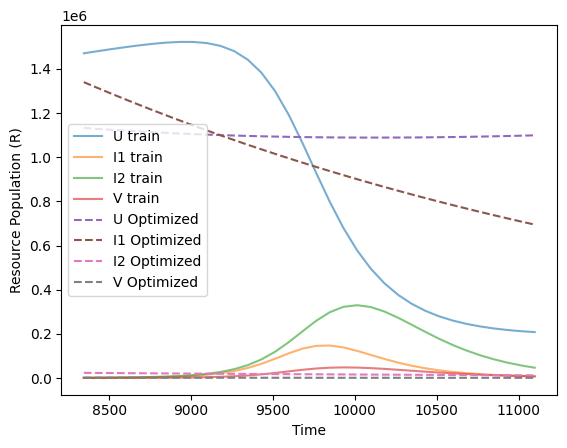

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 400
STEP = 3

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100)
observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,0.005531607325236635,0.18882178337606947,0.0693554120596835,0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,4.687055800442963e-06, U0)

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params8 = result.optimize_result.list[0]['x']
optimized_solution8 = simulate_model(optimized_params8)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution8[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution8[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution8[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution8[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

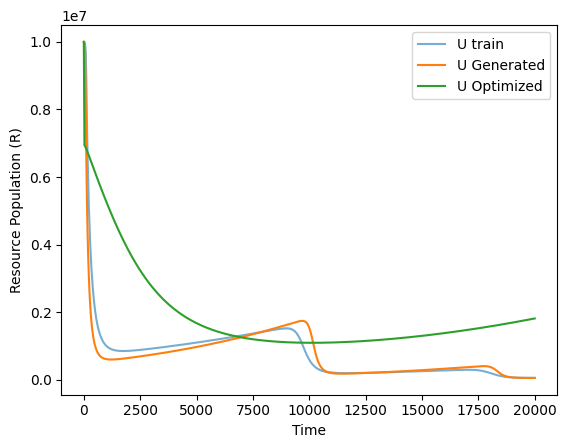

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data_gen_[:,0], label="U Generated")
plt.plot(t, optimized_solution8[:,0], label="U Optimized")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
  2%|▏         | 2/100 [00:27<22:12, 13.60s/it]<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get q

Optimized Parameters:
[1.86920499e-09 2.50292534e-02 1.75239155e-02 1.44603903e-01
 4.16187465e-01 3.08085733e+05]


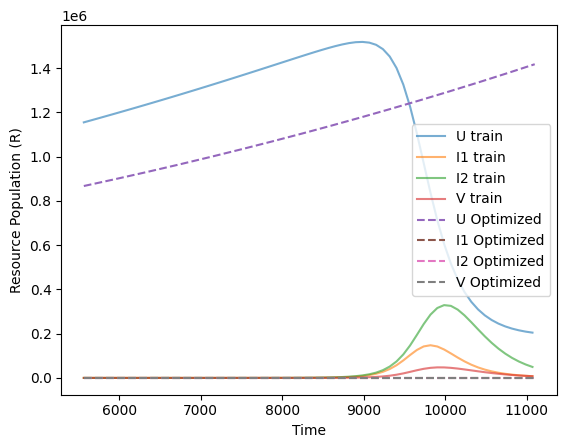

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 400
STEP = 3

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100)
observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,0.005531607325236635,0.18882178337606947,0.0693554120596835,0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,4.687055800442963e-06, U0)

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params9 = result.optimize_result.list[0]['x']
optimized_solution9 = simulate_model(optimized_params9)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution9[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution9[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution9[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution9[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

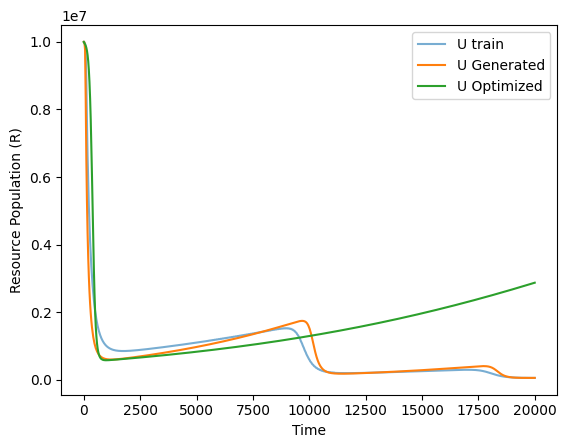

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data_gen_[:,0], label="U Generated")
plt.plot(t, optimized_solution9[:,0], label="U Optimized")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-39-5602f636da31>:5: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2 + residuals_gen**2) / 2
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  2%|▏         | 2/100 [00:02<01:38,  1.01s/it]<ipython-input-10-a751ebb1b858>:6: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,0,V0], t, args=(beta, k, d,c,p, 1e7))
<ipython-input-11-c4f4eb01a59a>:3: RuntimeWarning: invalid value encountered in scalar multiply
  dU_dt = -beta * U * V + 1e

Optimized Parameters:
[4.59020735e-08 4.41417967e-02 1.98812549e-02 2.74194694e-01
 6.69817823e-02 5.15618425e+05]


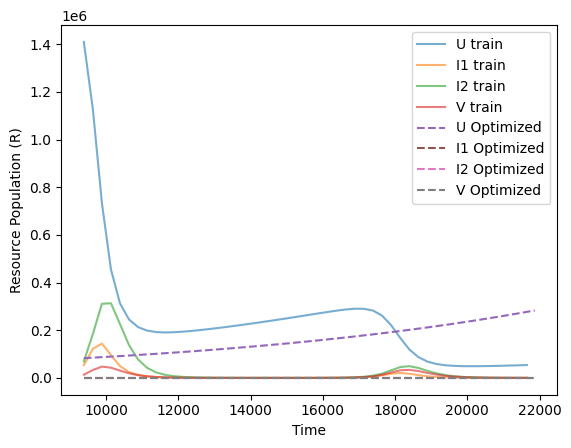

In [ ]:
import matplotlib.pyplot as plt

paramss = np.array([beta,k,d,c,p,1000])
LOWER_TIME_BOUND = 300
UPPER_TIME_BOUND = 700
STEP = 8

# Time points
t = np.linspace(0, 30000, 960)

# Simulate synthetic "observed" data
observed_data = odeint(viral_infection_model, y0, t, args=(beta, k, d, p, c, r, cp ,cd, ck, U0))[:,:4]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100)
observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,0.005531607325236635,0.18882178337606947,0.0693554120596835,0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,4.687055800442963e-06, U0)

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss - 4* np.abs(paramss)  # Lower bounds
lb[-1] = paramss[-1] / 2
ub = paramss + 4* np.abs(paramss) # Upper bounds
ub[-1] = paramss[-1]*1e3
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer())

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params9 = result.optimize_result.list[0]['x']
optimized_solution9 = simulate_model(optimized_params9)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="I1 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="I2 train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,3], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution9[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution9[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I1 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution9[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="I2 Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution9[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="V Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

## New Surrogate Model

In [ ]:
def viral_infection_surrogate_model(y, t, beta, d, p, cp, cd, ck, U_max):
    U, I, V, C = y
    dU_dt = -beta * U * V + 1e-4 * (1 - (U+I)/U_max) * U
    dI_dt = beta * U * V - d * I
    dV_dt = p * I - 1.09*600*1e-4 * V - ck * C * V
    dC_dt = cp * I**1.3 - cd * C
    return [dU_dt, dI_dt, dV_dt, dC_dt]

def simulate_model(params):
    beta, d, p, cp, cd, ck = params
    solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
    return solution

def objective_function(x):
    simulated = simulate_model(x)
    residuals = observed_data_[:,0] - simulated[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0]
    return np.sum(residuals**2)

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
<ipython-input-34-f433853b3cbf>:17: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  1%|          | 2/200 [00:04<08:36,  2.61s/it]<ipython-input-34-f433853b3cbf>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 

Optimized Parameters:
[1.07700000e-08 2.52025242e-03 1.93411275e-01 1.26535473e-05
 4.38697930e-04 3.37085292e-06]


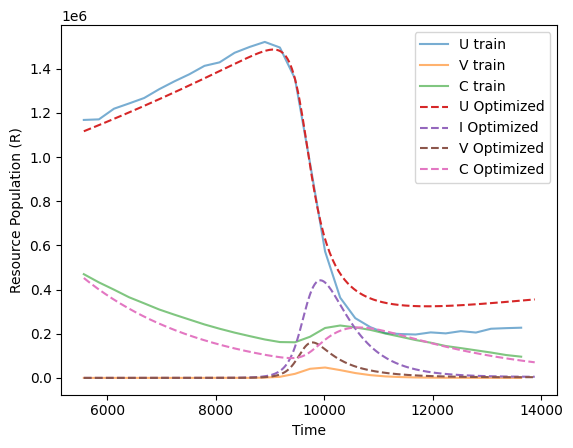

In [ ]:
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize

paramss = np.array([beta, d, p, cp, cd, ck])
LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 10

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,[0,3,4]]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100, observed_data_.shape[0])
observed_data_[:,1] += np.random.normal(np.mean(observed_data_[:,1]) / 100, np.std(observed_data_[:,1]) / 100,observed_data_.shape[0])
observed_data_[:,2] += np.random.normal(np.mean(observed_data_[:,2]) / 100, np.std(observed_data_[:,2]) / 100,observed_data_.shape[0])

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss/4   # Lower bounds
ub = paramss*4 # Upper bounds
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(),n_starts=200)

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params14 = result.optimize_result.list[0]['x']
optimized_solution14 = simulate_model(optimized_params14)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="C train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="V Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
model_teacher = [1.07700000e-08, 2.52025242e-03, 1.93411275e-01, 1.26535473e-05,
 4.38697930e-04, 3.37085292e-06]

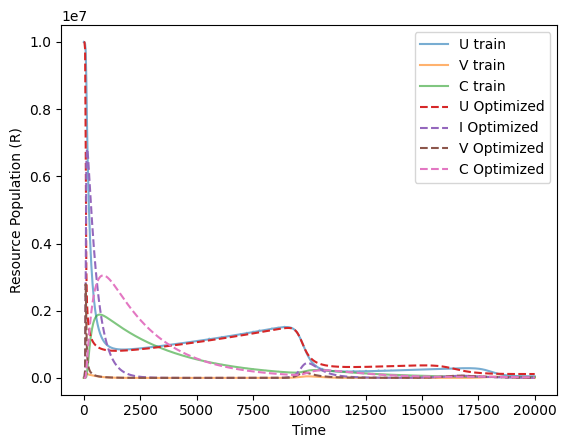

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, optimized_solution14[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,1], label="I Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,2], label="V Optimized", linestyle="--")
plt.plot(t, optimized_solution14[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
for index, row in enumerate(optimized_solution14):
  if any(row < 0):
    print(index, row)

In [ ]:
!pip install pypesto[cma]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
def objective_function(x):
    simulated = simulate_model(x)
    residuals = observed_data_ - simulated[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,[0,2,3]]
    return np.sum(residuals**2)

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  0%|          | 1/200 [00:00<00:53,  3.75it/s]<ipython-input-34-f433853b3cbf>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  1%|          | 2/200 [00:00<00:42,  4.63it/s]<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model,

Optimized Parameters:
[1.98523362e-08 4.66671957e-03 1.36377383e-01 2.33116998e-05
 6.90761463e-04 4.57901801e-06]


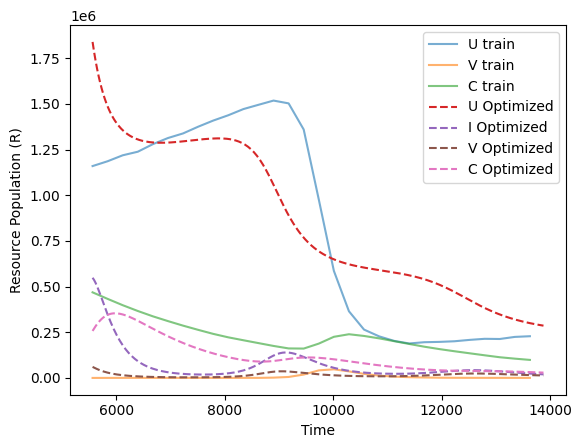

In [ ]:
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize
from pypesto.optimize import FidesOptimizer
from pypesto.optimize import PyswarmOptimizer
from pypesto.optimize import CmaOptimizer

paramss = np.array([beta, d, p, cp, cd, ck])
LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 10

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,[0,3,4]]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100, observed_data_.shape[0])
observed_data_[:,1] += np.random.normal(np.mean(observed_data_[:,1]) / 100, np.std(observed_data_[:,1]) / 100,observed_data_.shape[0])
observed_data_[:,2] += np.random.normal(np.mean(observed_data_[:,2]) / 100, np.std(observed_data_[:,2]) / 100,observed_data_.shape[0])

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss/4   # Lower bounds
ub = paramss*4 # Upper bounds
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(),n_starts=200)

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params15 = result.optimize_result.list[0]['x']
optimized_solution15 = simulate_model(optimized_params15)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="C train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="V Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

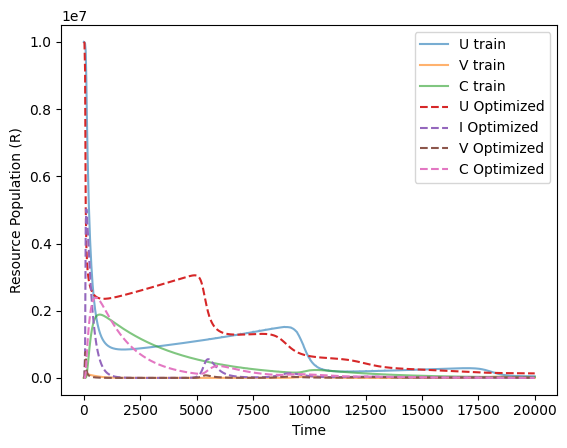

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, optimized_solution15[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution15[:,1], label="I Optimized", linestyle="--")
plt.plot(t, optimized_solution15[:,2], label="V Optimized", linestyle="--")
plt.plot(t, optimized_solution15[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
def objective_function(x):
    simulated = simulate_model(x)
    residuals = observed_data_[:,0] - simulated[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP,0]
    return np.sum(residuals**2)

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  1%|          | 2/200 [00:00<00:52,  3.77it/s]<ipython-input-34-f433853b3cbf>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  5%|▌         | 10/200 [00:03<00:45,  4.14it/s]<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model

Optimized Parameters:
[1.39759838e-08 5.30030255e-03 1.21816613e-01 1.52921365e-05
 6.85845613e-04 4.23241272e-06]


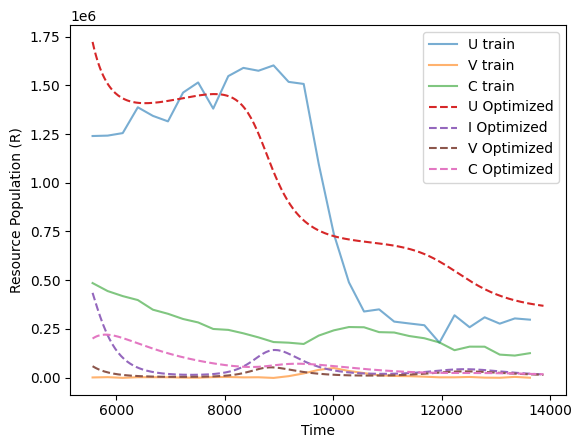

In [ ]:
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize
from pypesto.optimize import FidesOptimizer
from pypesto.optimize import PyswarmOptimizer
from pypesto.optimize import CmaOptimizer

paramss = np.array([beta, d, p, cp, cd, ck])
LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 10

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,[0,3,4]]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 10, np.std(observed_data_[:,0]) / 10, observed_data_.shape[0])
observed_data_[:,1] += np.random.normal(np.mean(observed_data_[:,1]) / 10, np.std(observed_data_[:,1]) / 10,observed_data_.shape[0])
observed_data_[:,2] += np.random.normal(np.mean(observed_data_[:,2]) / 10, np.std(observed_data_[:,2]) / 10,observed_data_.shape[0])

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss/4   # Lower bounds
ub = paramss*4 # Upper bounds
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(),n_starts=200)

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params15 = result.optimize_result.list[0]['x']
optimized_solution15 = simulate_model(optimized_params15)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="C train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="V Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

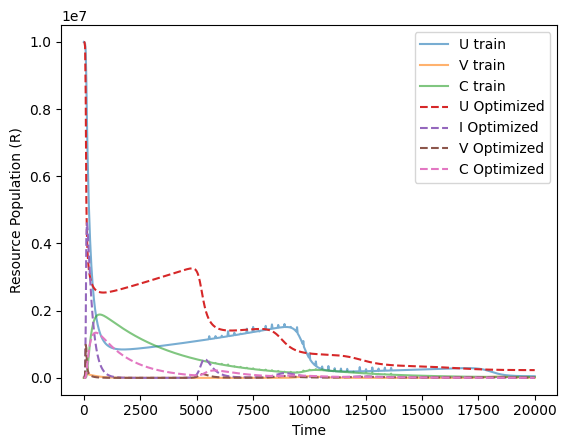

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, optimized_solution15[:,0], label="U Optimized", linestyle="--")
plt.plot(t, optimized_solution15[:,1], label="I Optimized", linestyle="--")
plt.plot(t, optimized_solution15[:,2], label="V Optimized", linestyle="--")
plt.plot(t, optimized_solution15[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  4%|▎         | 7/200 [00:00<00:13, 13.82it/s]<ipython-input-34-f433853b3cbf>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  4%|▍         | 9/200 [00:00<00:16, 11.73it/s]<ipython-input-45-1e40e78f428a>:4: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2)
<ipython-input-34-f433853b3cbf>:11: ODEintWarning: Excess accuracy requested (tolerances too small)

Optimized Parameters:
[6.87552939e-08 1.16240651e-02 1.03986258e-01 2.94716182e-05
 6.70719541e-04 9.29875820e-06]


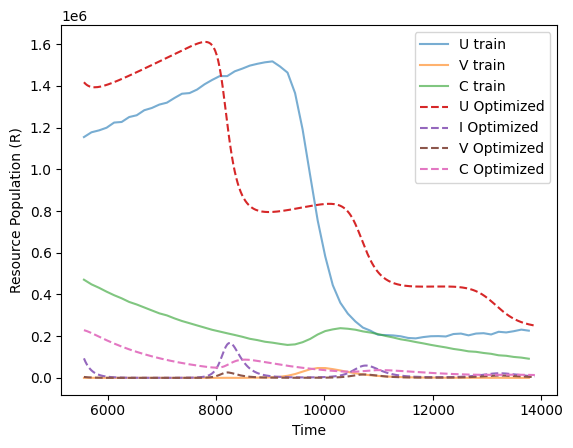

In [ ]:
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize
from pypesto.optimize import FidesOptimizer
from pypesto.optimize import PyswarmOptimizer
from pypesto.optimize import CmaOptimizer

paramss = np.array([beta, d, p, cp, cd, ck])
LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 5

# Time points
t = np.linspace(0, 20000, 720)

# Simulate synthetic "observed" data
observed_data = solution[:,[0,3,4]]
observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100, observed_data_.shape[0])
observed_data_[:,1] += np.random.normal(np.mean(observed_data_[:,1]) / 100, np.std(observed_data_[:,1]) / 100,observed_data_.shape[0])
observed_data_[:,2] += np.random.normal(np.mean(observed_data_[:,2]) / 100, np.std(observed_data_[:,2]) / 100,observed_data_.shape[0])

# Create a pyPESTO objective
objective = pypesto.Objective(fun=objective_function)

# Define the parameter bounds and initial guess
lb = paramss/4   # Lower bounds
ub = paramss*4 # Upper bounds
x0 = paramss  # Initial guess

# Create a pyPESTO problem
problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

# Run the optimizer
result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(),n_starts=200)

# Extract and print the optimized parameters
print("Optimized Parameters:")
print(result.optimize_result.list[0]['x'])

# Plot observed vs simulated data
optimized_params15 = result.optimize_result.list[0]['x']
optimized_solution15 = simulate_model(optimized_params15)

plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="V train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="C train", alpha=0.6)
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="V Optimized", linestyle="--")
plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution15[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

## NEW Knowledge Destilation

In [ ]:
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize
from pypesto.optimize import FidesOptimizer
from pypesto.optimize import PyswarmOptimizer
from pypesto.optimize import CmaOptimizer


def viral_infection_surrogate_model(y, t, beta, d, p, cp, cd, ck, U_max):
    U, I, V, C = y
    dU_dt = -beta * U * V + 1e-4 * (1 - (U+I)/U_max) * U
    dI_dt = beta * U * V - d * I
    dV_dt = p * I - 1.09*600*1e-4 * V - ck * C * V
    dC_dt = cp * I**1.3 - cd * C
    return [dU_dt, dI_dt, dV_dt, dC_dt]

def simulate_model(params):
    beta, d, p, cp, cd, ck = params
    solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
    return solution

def objective_function(x,ltb,utb,step,observed_data_,observed_data_gen_):
    simulated = simulate_model(x)
    residuals = observed_data_ - simulated[ltb:utb:step*2,0]
    residuals_gen = observed_data_gen_ - simulated[ltb+step:utb+step:step*2,0]
    return np.sqrt(np.sum(residuals**2)) + np.sqrt(np.sum(residuals_gen**2))

In [ ]:
import matplotlib.pyplot as plt
from functools import partial

LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 10

def knowledge_distilation(n_steps,optimizer, ltb,utb,step):
  paramss = np.array([beta, d, p, cp, cd, ck])
  t = np.linspace(0, 20000, 720)

  # Simulate synthetic "observed" data
  observed_data = solution[:,[0,2,3]]
  observed_data_ = observed_data[ltb:utb:step*2,0]
  observed_data_ += np.random.normal(np.mean(observed_data_) / 100, np.std(observed_data_) / 100, observed_data_.shape[0])
  observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,
                                       0.005531607325236635,0.18882178337606947,0.0693554120596835,
                                       0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,
                                       4.687055800442963e-06, U0)[ltb+step:utb+step:step*2,0]

  # Create a pyPESTO objective
  objective = pypesto.Objective(fun=partial(objective_function,ltb=ltb,utb=utb,step=step,observed_data_=observed_data_,observed_data_gen_=observed_data_gen_))

  # Define the parameter bounds and initial guess
  lb = paramss/4   # Lower bounds
  ub = paramss*4 # Upper bounds
  x0 = paramss  # Initial guess

  # Create a pyPESTO problem
  problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

  # Run the optimizer
  result = optimize.minimize(problem, optimizer=optimizer,n_starts=n_steps)

  # Extract and print the optimized parameters
  print("Optimized Parameters:")
  print(result.optimize_result.list[0]['x'])

  # Plot observed vs simulated data
  optimized_params8 = result.optimize_result.list[0]['x']
  optimized_solution8 = simulate_model(optimized_params8)

  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,0], label="U train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,1], label="V train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,2], label="C train", alpha=0.6)
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,0], label="U Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,1], label="I Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,2], label="V Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,3], label="C Optimized", linestyle="--")
  plt.xlabel("Time")
  plt.ylabel("Resource Population (R)")
  plt.legend()
  plt.show()

  return optimized_params8 ,optimized_solution8

In [ ]:
[i for i in range(200,500,20)], [i for i in range(210,510,20)]

([200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480],
 [210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490])

In [ ]:
opt_params, opt_solution = knowledge_distilation(200,optimize.ScipyOptimizer(method="slsqp"))

TypeError: knowledge_distilation() missing 3 required positional arguments: 'ltb', 'utb', and 'step'

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-62-1106ecf810b1>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
<ipython-input-62-1106ecf810b1>:18: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2 + residuals_gen**2) / 2
  0%|          | 1/500 [00:00<00:57,  8.72it/s]<ipython-input-62-1106ecf810b1>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-62-1106ecf810b1>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 18%|█▊        | 89/500 [00:10<00:45,  8.95it/s]/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: R

Optimized Parameters:
[1.06985731e-07 9.43977246e-03 4.09593661e-02 2.54832350e-05
 9.98626493e-04 1.13896021e-05]


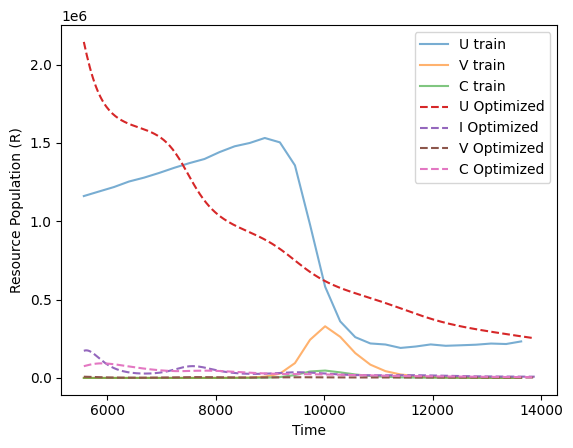

In [ ]:
opt_params2, opt_solution2 = knowledge_distilation(500,optimize.ScipyOptimizer(method="slsqp"))

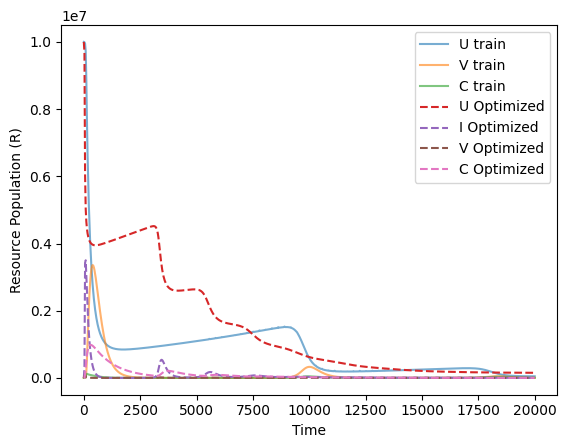

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, opt_solution2[:,0], label="U Optimized", linestyle="--")
plt.plot(t, opt_solution2[:,1], label="I Optimized", linestyle="--")
plt.plot(t, opt_solution2[:,2], label="V Optimized", linestyle="--")
plt.plot(t, opt_solution2[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-139-3889a757dce7>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  1%|          | 2/200 [00:00<00:28,  6.92it/s]<ipython-input-139-3889a757dce7>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-139-3889a757dce7>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
<ipython-input-139-3889a757dce7>:18: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum(residuals**2)) + np.sqrt(np.sum(residuals_gen**2))
  2%|▏         | 3/200 [00:01<01:25,  2.31it/s]<ipython-input-139-3889a757dce7>:11: ODEintWarnin

Optimized Parameters:
[1.07700000e-08 8.32851137e-03 1.00924252e-01 1.00000000e-05
 8.97240157e-04 1.01000000e-06]


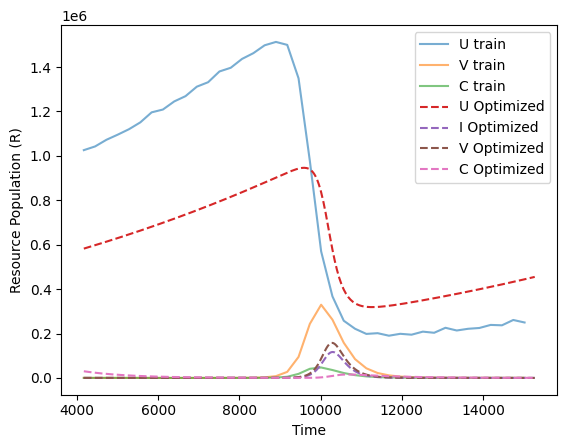

In [ ]:
opt_params3, opt_solution3 = knowledge_distilation(200,optimize.ScipyOptimizer(),150,550,10)

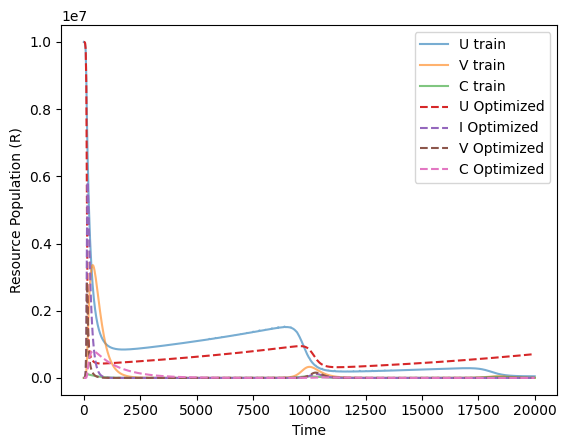

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, opt_solution3[:,0], label="U Optimized", linestyle="--")
plt.plot(t, opt_solution3[:,1], label="I Optimized", linestyle="--")
plt.plot(t, opt_solution3[:,2], label="V Optimized", linestyle="--")
plt.plot(t, opt_solution3[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
def objective_function(x,ltb,utb,step,observed_data_,observed_data_gen_):
    simulated = simulate_model(x)
    residuals = observed_data_ - simulated[ltb:utb:step*2,0]
    residuals_gen = observed_data_gen_ - simulated[ltb+step:utb+step:step*2,0]
    return np.sqrt(np.mean(residuals**2)) + np.sqrt(np.mean(residuals_gen**2))

In [ ]:
import matplotlib.pyplot as plt
from functools import partial

LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 10

def knowledge_distilation(n_steps,optimizer, ltb,utb,step):
  paramss = np.array([beta, d, p, cp, cd, ck])
  t = np.linspace(0, 20000, 720)

  # Simulate synthetic "observed" data
  observed_data = solution[:,[0,2,3]]
  observed_data_ = observed_data[ltb:utb:step*2,0]
  observed_data_ += np.random.normal(np.mean(observed_data_) / 100, np.std(observed_data_) / 100, observed_data_.shape[0])
  observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,
                                       0.005531607325236635,0.18882178337606947,0.0693554120596835,
                                       0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,
                                       4.687055800442963e-06, U0)[ltb+step:utb+step:step*2,0]

  # Create a pyPESTO objective
  objective = pypesto.Objective(fun=partial(objective_function,ltb=ltb,utb=utb,step=step,observed_data_=observed_data_,observed_data_gen_=observed_data_gen_))

  # Define the parameter bounds and initial guess
  lb = paramss/4   # Lower bounds
  ub = paramss*4 # Upper bounds
  x0 = paramss  # Initial guess

  # Create a pyPESTO problem
  problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

  # Run the optimizer
  result = optimize.minimize(problem, optimizer=optimizer,n_starts=n_steps)

  # Extract and print the optimized parameters
  print("Optimized Parameters:")
  print(result.optimize_result.list[0]['x'])

  # Plot observed vs simulated data
  optimized_params8 = result.optimize_result.list[0]['x']
  optimized_solution8 = simulate_model(optimized_params8)

  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,0], label="U train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,1], label="V train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,2], label="C train", alpha=0.6)
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,0], label="U Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,1], label="I Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,2], label="V Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,3], label="C Optimized", linestyle="--")
  plt.xlabel("Time")
  plt.ylabel("Resource Population (R)")
  plt.legend()
  plt.show()

  return optimized_params8 ,optimized_solution8

In [ ]:
opt_params4, opt_solution4 = knowledge_distilation(200,optimize.ScipyOptimizer(),150,550,10)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/scipy/optimize/_lbfgsb_py.py", line 347, in _minimize_lbfgsb
    sf = _prepare_scalar_function(fun, x0, jac=jac, args=args, epsilon=eps,
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py", line 288, in _prepare_scalar_function
    sf = ScalarFunction(fun, x0, args, grad, hess,
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py", line 166, in __init__
    self._update_fun()

  File "/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py", line 262, in _update_fun
    self._update_fun_impl()

  File "/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py", line 163, in upd

Optimized Parameters:
None


TypeError: cannot unpack non-iterable NoneType object

Done:
* Add noise to generated data

In [ ]:
def objective_function(x,ltb,utb,step,observed_data_,observed_data_gen_,indexes, gen_indexes):
    simulated = simulate_model(x)[:,[0,2,3]]
    residuals = observed_data_ - simulated[indexes]
    residuals_gen = observed_data_gen_ - simulated[gen_indexes]
    return np.sum(residuals**2) + np.sum(residuals_gen**2)

def simulate_model(params):
    beta, d, p, cp, cd, ck = params
    solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
    return solution

In [ ]:
import matplotlib.pyplot as plt
from functools import partial

def knowledge_distilation(n_steps,optimizer, ltb,utb,step):
  paramss = np.array([beta, d, p, cp, cd, ck])
  t = np.linspace(0, 20000, 720)

  # Simulate synthetic "observed" data
  observed_data = solution[:,[0,3,4]]
  length = utb - ltb
  #indexes = [i for i in range(ltb,utb - (length // 3) * 2,step*2)] + [i for i in range(ltb + (length // 3),utb - (length // 3),step)] + [i for i in range(ltb + (length // 3) * 2,utb,step*2)]
  indexes = [i for i in range(ltb,340,30)] + [i for i in range(340,380,5)] + [i for i in range(380,utb,30)]
  #gen_indexes = [i for i in range(ltb+step//2,utb - (length // 3) * 2 + step//2,step*4)] + [i for i in range(ltb +step//2 + (length // 3),utb +step//2 - (length // 3),step*2)] + [i for i in range(ltb + step//2 + (length // 3) * 2,utb+step//2,step*4)]
  # gen_indexes = [i for i in range(ltb,350,70)] + [i for i in range(350,380,7)] + [i for i in range(420,utb,60)]
  gen_indexes = indexes
  observed_data_ = observed_data[indexes]
  observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100, observed_data_.shape[0])
  observed_data_[:,1] += np.random.normal(np.mean(observed_data_[:,1]) / 100, np.std(observed_data_[:,1]) / 100, observed_data_.shape[0])
  observed_data_[:,2] += np.random.normal(np.mean(observed_data_[:,2]) / 100, np.std(observed_data_[:,2]) / 100, observed_data_.shape[0])
  observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,
                                        0.005531607325236635,0.18882178337606947,0.0693554120596835,
                                        0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,
                                        4.687055800442963e-06, U0)[:,[0,3,4]]
  observed_data_gen_ = observed_data_gen_[gen_indexes]
  observed_data_gen_[:,0] += np.random.normal(np.mean(observed_data_gen_[:,0]) / 100, np.std(observed_data_gen_[:,0]) / 100, observed_data_gen_.shape[0])
  observed_data_gen_[:,1] += np.random.normal(np.mean(observed_data_gen_[:,1]) / 100, np.std(observed_data_gen_[:,1]) / 100, observed_data_gen_.shape[0])
  observed_data_gen_[:,2] += np.random.normal(np.mean(observed_data_gen_[:,2]) / 100, np.std(observed_data_gen_[:,2]) / 100, observed_data_gen_.shape[0])

  # Create a pyPESTO objective
  objective = pypesto.Objective(fun=partial(objective_function,ltb=ltb,utb=utb,step=step,observed_data_=observed_data_,observed_data_gen_=observed_data_gen_,indexes=indexes,gen_indexes=gen_indexes))

  # Define the parameter bounds and initial guess
  lb = paramss/4   # Lower bounds
  ub = paramss*4 # Upper bounds
  x0 = paramss  # Initial guess

  # Create a pyPESTO problem
  problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

  # Run the optimizer
  result = optimize.minimize(problem, optimizer=optimizer,n_starts=n_steps)

  # Extract and print the optimized parameters
  print("Optimized Parameters:")
  print(result.optimize_result.list[0]['x'])

  # Plot observed vs simulated data
  optimized_params8 = result.optimize_result.list[0]['x']
  optimized_solution8 = simulate_model(optimized_params8)

  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,0], label="U train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,1], label="V train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,2], label="C train", alpha=0.6)
  plt.plot(t[gen_indexes], observed_data_gen_, '*', label="U train gen", alpha=0.6)
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,0], label="U Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,1], label="I Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,2], label="V Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,3], label="C Optimized", linestyle="--")
  plt.xlabel("Time")
  plt.ylabel("Resource Population (R)")
  plt.legend()
  plt.show()

  return optimized_params8 ,optimized_solution8

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  2%|▏         | 4/200 [00:00<00:22,  8.90it/s]<ipython-input-11-db0a1c805da4>:14: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  9%|▉         | 18/200 [00:12<00:45,  4.02it/s]<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, 

Optimized Parameters:
[2.42468232e-08 1.13649903e-02 2.96158263e-01 9.07231590e-05
 5.61055062e-04 2.47265978e-06]


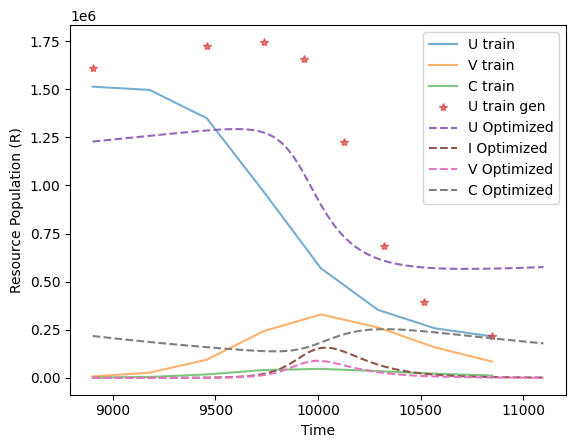

In [ ]:
opt_params4, opt_solution4 = knowledge_distilation(200,optimize.ScipyOptimizer(),320,400,10)

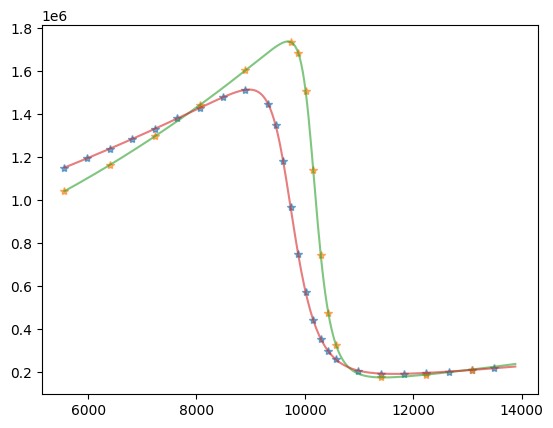

In [ ]:
data = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,
                                       0.005531607325236635,0.18882178337606947,0.0693554120596835,
                                       0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,
                                       4.687055800442963e-06, U0)[:,[0,2,3]]

index = [i for i in range(200,340,15)] + [i for i in range(340,380,5)] + [i for i in range(380,500,15)]
index_gen = [i for i in range(200,340,30)] + [i for i in range(350,380,5)] + [i for i in range(380,500,30)]
plt.plot(t[index], observed_data[index,0], '*',label="U train points", alpha=0.6)
plt.plot(t[index_gen], data[index_gen,0], '*',label="U train points", alpha=0.6)
plt.plot(t[200:500], data[200:500,0], label="U train", alpha=0.6)
plt.plot(t[200:500], observed_data[200:500,0], label="U train", alpha=0.6)

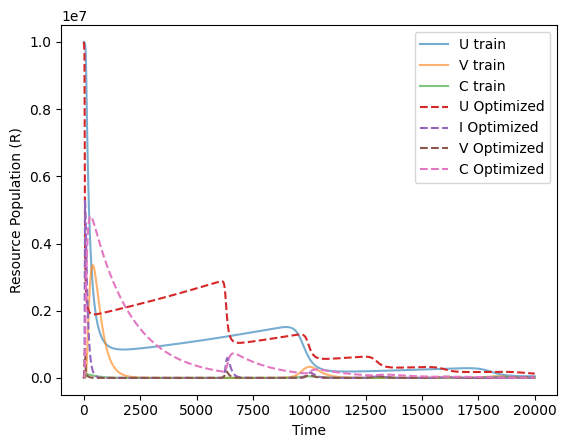

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, opt_solution4[:,0], label="U Optimized", linestyle="--")
plt.plot(t, opt_solution4[:,1], label="I Optimized", linestyle="--")
plt.plot(t, opt_solution4[:,2], label="V Optimized", linestyle="--")
plt.plot(t, opt_solution4[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  3%|▎         | 6/200 [00:00<00:22,  8.60it/s]<ipython-input-11-db0a1c805da4>:14: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 14%|█▍        | 29/200 [00:04<00:21,  7.79it/s]<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, 

Optimized Parameters:
[2.92666655e-08 1.29901348e-02 1.29280141e-01 2.77062109e-05
 1.01189511e-03 1.10007379e-05]


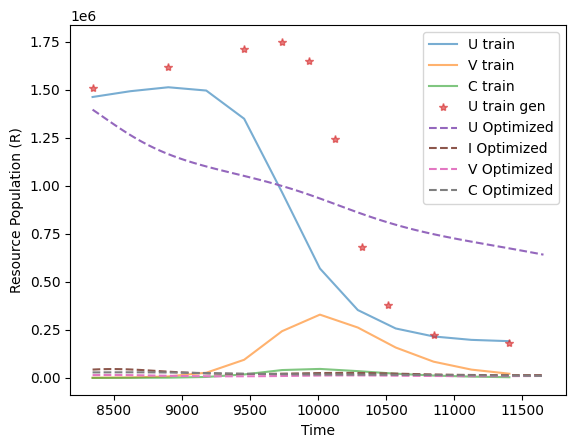

In [ ]:
opt_params5, opt_solution5 = knowledge_distilation(200,optimize.ScipyOptimizer(),300,420,10)

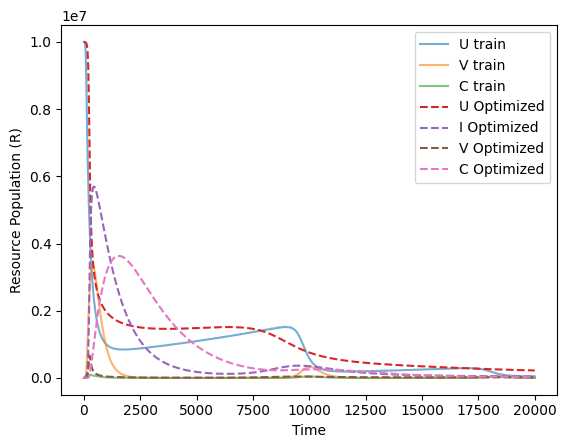

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, opt_solution4[:,0], label="U Optimized", linestyle="--")
plt.plot(t, opt_solution4[:,1], label="I Optimized", linestyle="--")
plt.plot(t, opt_solution4[:,2], label="V Optimized", linestyle="--")
plt.plot(t, opt_solution4[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

Zwiększyłem odstępy na krańcach

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  1%|          | 1/100 [00:00<00:11,  8.81it/s]<ipython-input-11-db0a1c805da4>:14: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 13%|█▎        | 13/100 [00:05<00:31,  2.77it/s]<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, 

Optimized Parameters:
[1.07700000e-08 7.59277725e-03 3.47300121e-01 5.41901185e-05
 7.53085318e-04 3.70078661e-06]


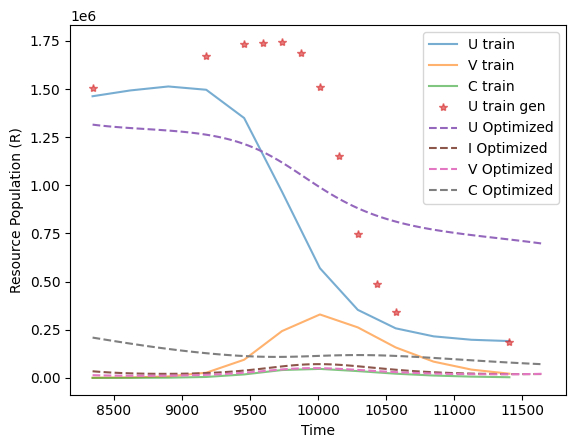

In [ ]:
opt_params6, opt_solution6 = knowledge_distilation(100,optimize.ScipyOptimizer(),300,420,10)

Generacja punktóœ w tych samych miejscach

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
<ipython-input-11-db0a1c805da4>:14: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  9%|▉         | 18/200 [00:04<01:34,  1.93it/s]<ipython-input-82-8a8d2cf13f42>:9: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck

Optimized Parameters:
[1.15954668e-08 1.18034730e-02 4.46223979e-01 1.89994720e-05
 6.93904636e-04 1.10223175e-05]


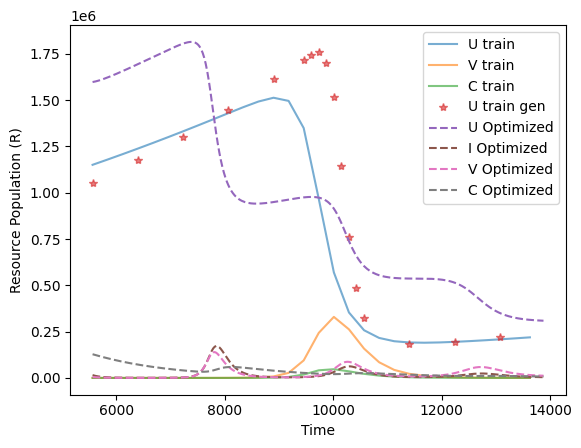

In [ ]:
opt_params7, opt_solution7 = knowledge_distilation(200,optimize.ScipyOptimizer(),200,500,10)

Zmiana funkcji kosztu na wszystkie zmienne

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-126-5f57597cd36c>:9: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  1%|          | 2/200 [00:00<00:29,  6.68it/s]<ipython-input-11-db0a1c805da4>:14: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-126-5f57597cd36c>:9: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 13%|█▎        | 26/200 [00:03<00:17, 10.07it/s]<ipython-input-126-5f57597cd36c>:9: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_mode

Optimized Parameters:
[1.25150194e-08 4.89491195e-03 2.63823357e-01 2.12216836e-05
 4.01238789e-04 2.99396714e-06]


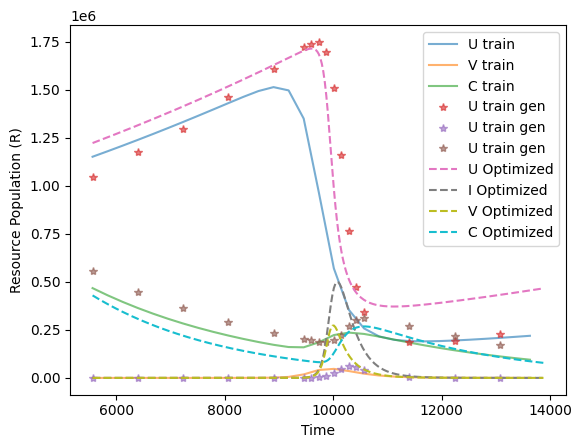

In [ ]:
opt_params8, opt_solution8 = knowledge_distilation(200,optimize.ScipyOptimizer(),200,500,10)

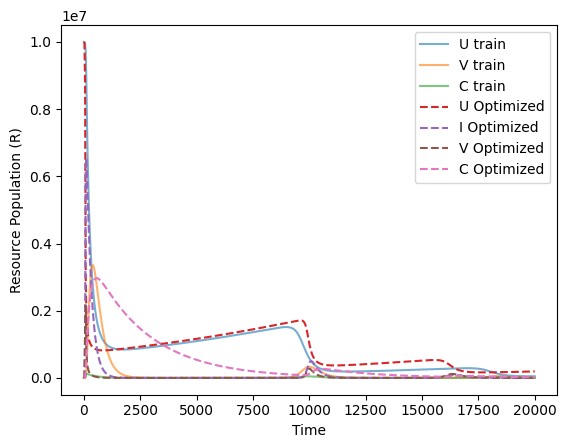

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, opt_solution8[:,0], label="U Optimized", linestyle="--")
plt.plot(t, opt_solution8[:,1], label="I Optimized", linestyle="--")
plt.plot(t, opt_solution8[:,2], label="V Optimized", linestyle="--")
plt.plot(t, opt_solution8[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

In [ ]:
model_surogate_final = [1.25150194e-08, 4.89491195e-03, 2.63823357e-01, 2.12216836e-05,
 4.01238789e-04, 2.99396714e-06]

  0%|          | 0/800 [00:00<?, ?it/s]<ipython-input-139-3889a757dce7>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
<ipython-input-139-3889a757dce7>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  0%|          | 2/800 [00:00<05:29,  2.43it/s]<ipython-input-139-3889a757dce7>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-139-3889a757dce7>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, c

Optimized Parameters:
[1.15360358e-07 9.78201904e-03 4.88162791e-01 1.01852905e-05
 1.00480615e-03 4.05613545e-06]


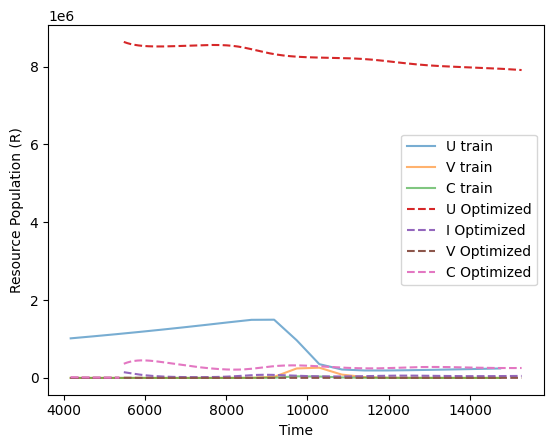

In [ ]:
opt_params5, opt_solution5 = knowledge_distilation(800,optimize.ScipyOptimizer(),150,550,20)

In [ ]:
import matplotlib.pyplot as plt
from functools import partial

LOWER_TIME_BOUND = 200
UPPER_TIME_BOUND = 500
STEP = 10

def objective_function_all(x,ltb,utb,step,observed_data_,observed_data_gen_):
    simulated = simulate_model(x)
    residuals = observed_data_ - simulated[ltb:utb:step,[0,2,3]]
    residuals_gen = observed_data_gen_ - simulated[ltb:utb:step,[0,2,3]]
    return (np.sqrt(np.sum(residuals**2)) + np.sqrt(np.sum(residuals_gen**2))) / 2

def knowledge_distilation_all(n_steps,optimizer, ltb,utb,step):
  paramss = np.array([beta, d, p, cp, cd, ck])
  t = np.linspace(0, 20000, 720)

  # Simulate synthetic "observed" data
  observed_data = solution[:,[0,2,3]]
  observed_data_ = observed_data[ltb:utb:step]
  observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100, observed_data_.shape[0])
  observed_data_[:,1] += np.random.normal(np.mean(observed_data_[:,1]) / 100, np.std(observed_data_[:,1]) / 100, observed_data_.shape[0])
  observed_data_[:,2] += np.random.normal(np.mean(observed_data_[:,2]) / 100, np.std(observed_data_[:,2]) / 100, observed_data_.shape[0])
  observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,
                                       0.005531607325236635,0.18882178337606947,0.0693554120596835,
                                       0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,
                                       4.687055800442963e-06, U0)[ltb:utb:step,[0,2,3]]
  # Create a pyPESTO objective
  objective = pypesto.Objective(fun=partial(objective_function_all,ltb=ltb,utb=utb,step=step,observed_data_=observed_data_,observed_data_gen_=observed_data_gen_))

  # Define the parameter bounds and initial guess
  lb = paramss/4   # Lower bounds
  ub = paramss*4 # Upper bounds
  x0 = paramss  # Initial guess

  # Create a pyPESTO problem
  problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

  # Run the optimizer
  result = optimize.minimize(problem, optimizer=optimizer,n_starts=n_steps)

  # Extract and print the optimized parameters
  print("Optimized Parameters:")
  print(result.optimize_result.list[0]['x'])

  # Plot observed vs simulated data
  optimized_params8 = result.optimize_result.list[0]['x']
  optimized_solution8 = simulate_model(optimized_params8)

  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,0], label="U train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,1], label="V train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[ltb:utb:step,2], label="C train", alpha=0.6)
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,0], label="U Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,1], label="I Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,2], label="V Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution8[ltb:utb,3], label="C Optimized", linestyle="--")
  plt.xlabel("Time")
  plt.ylabel("Resource Population (R)")
  plt.legend()
  plt.show()

  return optimized_params8 ,optimized_solution8

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-112-8599c2a1e5a5>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  2%|▏         | 3/200 [00:00<00:13, 14.75it/s]<ipython-input-112-8599c2a1e5a5>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-112-8599c2a1e5a5>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
<ipython-input-112-8599c2a1e5a5>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, c

Optimized Parameters:
[2.46096731e-08 9.61486378e-03 1.05061892e-01 1.39454727e-05
 7.08505937e-04 5.74368562e-06]


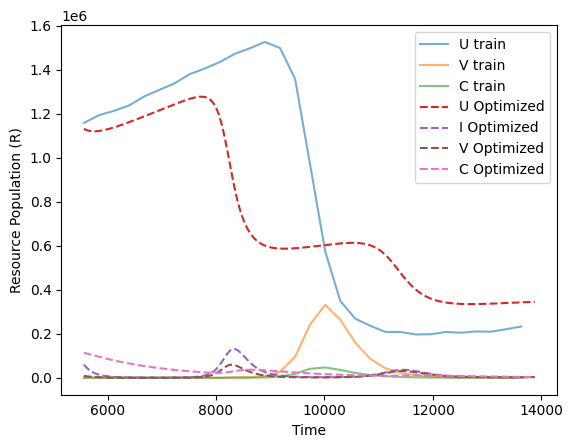

In [ ]:
opt_params4, opt_solution4 = knowledge_distilation_all(200,optimize.ScipyOptimizer(),200,500,10)

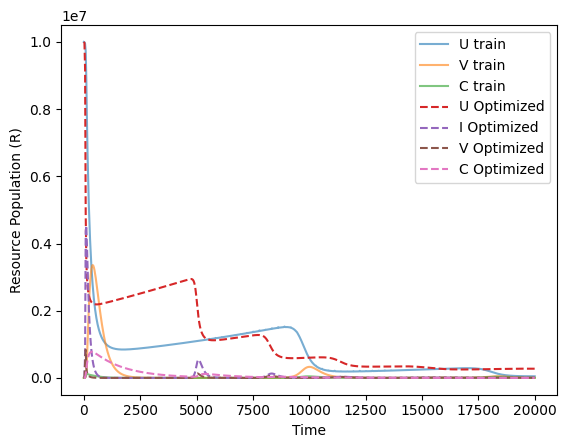

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, opt_solution4[:,0], label="U Optimized", linestyle="--")
plt.plot(t, opt_solution4[:,1], label="I Optimized", linestyle="--")
plt.plot(t, opt_solution4[:,2], label="V Optimized", linestyle="--")
plt.plot(t, opt_solution4[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

## Supermodel

In [ ]:
def viral_infection_surrogate_model(y, t, beta, d, p, cp, cd, ck, U_max):
    U, I, V, C = y
    dU_dt = -beta * U * V + 1e-4 * (1 - (U+I)/U_max) * U
    dI_dt = beta * U * V - d * I
    dV_dt = p * I - 1.09*600*1e-4 * V - ck * C * V
    dC_dt = cp * I**1.3 - cd * C
    return [dU_dt, dI_dt, dV_dt, dC_dt]

def simulate_model(params):
    beta, d, p, cp, cd, ck = params
    solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
    return solution

def objective_function(x,ltb,utb,step,observed_data_):
    simulated = simulate_model(x)[ltb:utb:step]
    residuals = observed_data_ - simulated[:,[0,2,3]]
    return np.sum(residuals**2)

In [ ]:
model_teacher = [1.07700000e-08, 2.52025242e-03, 1.93411275e-01, 1.26535473e-05,
 4.38697930e-04, 3.37085292e-06]

In [ ]:
from SALib.sample import sobol
multiplier = 1.2
problem = {
    'num_vars': 8,
    'names': ['U0','V0','beta', 'd', 'p', 'cp', 'cd', 'ck'],
    'bounds': [
        [U0/multiplier,U0*multiplier],
        [1000/multiplier,1000*multiplier],
        [model_teacher[0]/multiplier, model_teacher[0]*multiplier],
        [model_teacher[1]/multiplier, model_teacher[1]*multiplier],
        [model_teacher[2]/multiplier, model_teacher[2]*multiplier],
        [model_teacher[3]/multiplier, model_teacher[3]*multiplier],
        [model_teacher[4]/multiplier, model_teacher[4]*multiplier],
        [model_teacher[5]/multiplier, model_teacher[5]*multiplier],
    ]
}

In [ ]:
param_values_sobol = sobol.sample(problem, 512, calc_second_order=False)
t = np.linspace(0, 10000, 360)

In [ ]:
def evaluate_model(params):
    U0,V0, beta, d, p, cp, cd, ck = params
    y0 = [U0,0,V0,0]
    solution = odeint(viral_infection_surrogate_model, y0, t, args=(beta, d, p, cp, cd, ck, U0))
    U,I,V,C = solution.T
    return U,I,V,C

In [ ]:
from tqdm import tqdm_notebook

Us, Is, Vs, Cs = [], [], [], []
for params in tqdm_notebook(param_values_sobol):
  U,I,V,C = evaluate_model(params)
  Us.append(U)
  Is.append(I)
  Vs.append(V)
  Cs.append(C)

<ipython-input-182-0859fcdb3ad8>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for params in tqdm_notebook(param_values_sobol):


  0%|          | 0/5120 [00:00<?, ?it/s]

In [ ]:
Us = np.array(Us)
Is = np.array(Is)
Vs = np.array(Vs)
Cs = np.array(Cs)

In [ ]:
from SALib.analyze import sobol

resultsU = []
resultsI = []
resultsV = []
resultsC = []
for time_ in range(1,360):
  resultsU.append(sobol.analyze(problem, Us[:,time_], calc_second_order=False))
  resultsI.append(sobol.analyze(problem, Is[:,time_], calc_second_order=False))
  resultsV.append(sobol.analyze(problem, Vs[:,time_], calc_second_order=False))
  resultsC.append(sobol.analyze(problem, Cs[:,time_], calc_second_order=False))

In [ ]:
S1MatrixU = np.array([result['S1'] for result in resultsU])
STMatrixU = np.array([result['ST'] for result in resultsU])
S1MatrixI = np.array([result['S1'] for result in resultsI])
STMatrixI = np.array([result['ST'] for result in resultsI])
S1MatrixV = np.array([result['S1'] for result in resultsV])
STMatrixV = np.array([result['ST'] for result in resultsV])
S1MatrixC = np.array([result['S1'] for result in resultsC])
STMatrixC = np.array([result['ST'] for result in resultsC])

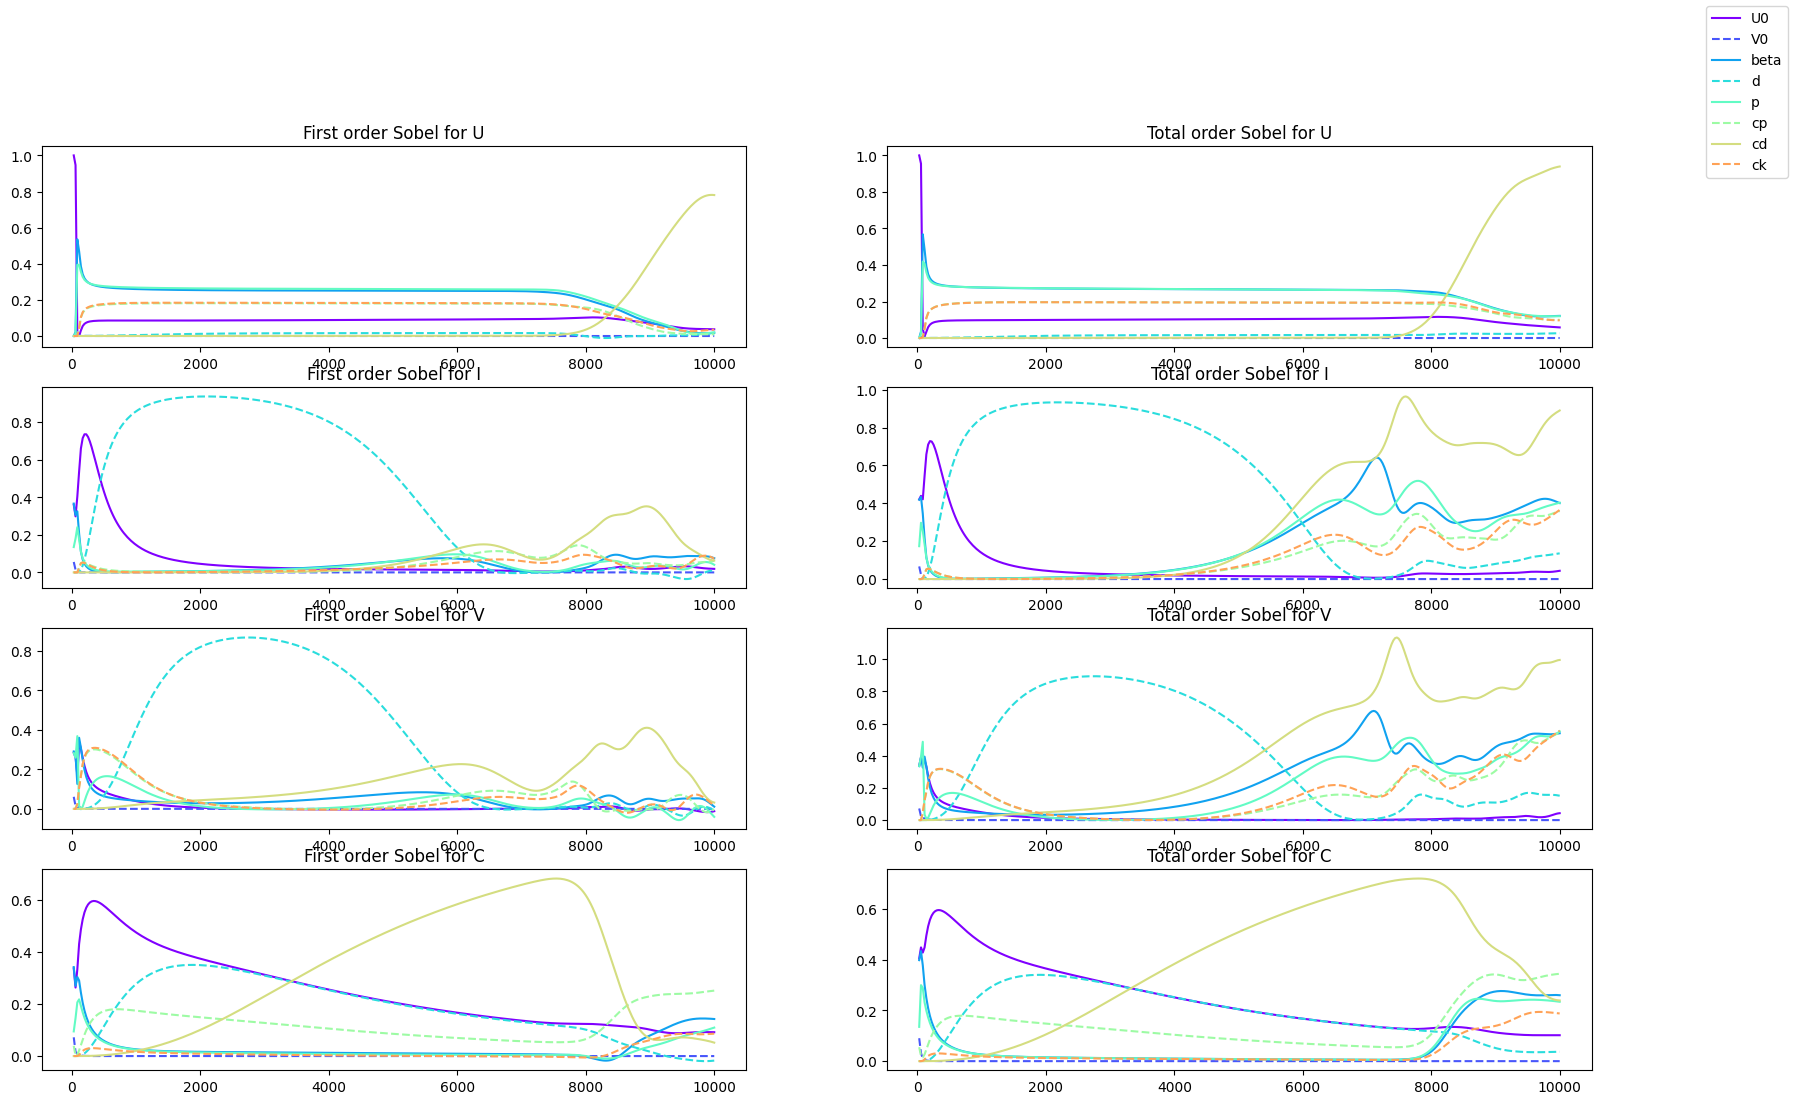

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 10))
fig, axes = plt.subplots(4,2)
matrices = [[S1MatrixU,STMatrixU],
            [S1MatrixI,STMatrixI],
            [S1MatrixV,STMatrixV],
            [S1MatrixC,STMatrixC]]

texts = ['First order Sobel for ', 'Total order Sobel for ']
variables = ['U','I','V','C']
fig.set_size_inches(20,12)

for row in range(4):
  for col in range(2):
    for name, col_, color_ in zip(problem['names'],range(8),color):
      axes[row,col].plot(t[1:], matrices[row][col][:,col_],'-'*(1+(col_ % 2)),label=name,c=color_)
      axes[row,col].grid()
      axes[row,col].set_title(texts[col] + variables[row])


handles, labels = axes[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [ ]:
class Supermodel:
  def __init__(self,params_set1,params_set2,params_set3):
    self.paramss = [params_set1,params_set2,params_set3]

  def _model(self,index,V_t,V1,V2,U,I,C,c1,c2):
      params = self.paramss[index]
      dU_dt = -params[0] * U * V_t + 1e-4 * (1 - (U+I)/1e7) * U
      dI_dt = params[0] * U * V_t - params[1] * I
      dV_dt = params[2] * I - 1.09*600*1e-4 * V_t - params[5] * C * V_t + c1*(V1-V_t) + c2*(V2-V_t)
      dC_dt = params[3] * I**1.3 - params[4] * C
      return [dU_dt, dI_dt, dV_dt,dC_dt]

  def simulate(self, y, t, c12,c13,c21,c23,c31,c32):
    U1, I1, V1, C1, U2, I2, V2, C2, U3, I3, V3, C3 = y
    outputs = []
    outputs.extend(self._model(0,V1,V2,V3,U1,I1,C1,c12,c13))
    outputs.extend(self._model(1,V2,V1,V3,U2,I2,C2,c21,c23))
    outputs.extend(self._model(2,V3,V1,V2,U3,I3,C3,c31,c32))
    return np.array(outputs)

In [ ]:
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize
t = np.linspace(0, 20000, 720)

def train_submodel(n_steps, paramss):
  LOWER_TIME_BOUND = 200
  UPPER_TIME_BOUND = 500
  STEP = 10

  # Time points
  t = np.linspace(0, 20000, 720)

  # Simulate synthetic "observed" data
  observed_data = solution[:,[0,3,4]]
  observed_data_ = observed_data[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP]  # Example: Observing only the resource population R
  observed_data_[:,0] += np.random.normal(np.mean(observed_data_[:,0]) / 100, np.std(observed_data_[:,0]) / 100, observed_data_.shape[0])
  observed_data_[:,1] += np.random.normal(np.mean(observed_data_[:,1]) / 100, np.std(observed_data_[:,1]) / 100,observed_data_.shape[0])
  observed_data_[:,2] += np.random.normal(np.mean(observed_data_[:,2]) / 100, np.std(observed_data_[:,2]) / 100,observed_data_.shape[0])

  # Create a pyPESTO objective
  objective = pypesto.Objective(fun=partial(objective_function,ltb=LOWER_TIME_BOUND,utb=UPPER_TIME_BOUND,step=STEP,observed_data_=observed_data_))

  # Define the parameter bounds and initial guess
  lb = paramss/4   # Lower bounds
  ub = paramss*4 # Upper bounds
  x0 = paramss  # Initial guess

  # Create a pyPESTO problem
  problem = pypesto.Problem(objective=objective, lb=lb, ub=ub, x_guesses=[x0.tolist()])

  # Run the optimizer
  result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(),n_starts=n_steps)

  # Extract and print the optimized parameters
  print("Optimized Parameters:")
  print(result.optimize_result.list[0]['x'])

  # Plot observed vs simulated data
  optimized_params14 = result.optimize_result.list[0]['x']
  optimized_solution14 = simulate_model(optimized_params14)

  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,0], label="U train", alpha=0.6)
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,1], label="V train", alpha=0.6)
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND:STEP], observed_data_[:,2], label="C train", alpha=0.6)
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,0], label="U Optimized", linestyle="--")
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,1], label="I Optimized", linestyle="--")
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,2], label="V Optimized", linestyle="--")
  plt.plot(t[LOWER_TIME_BOUND:UPPER_TIME_BOUND], optimized_solution14[LOWER_TIME_BOUND:UPPER_TIME_BOUND,3], label="C Optimized", linestyle="--")
  plt.xlabel("Time")
  plt.ylabel("Resource Population (R)")
  plt.legend()
  plt.show()

  return optimized_params14

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 10%|█         | 5/50 [00:00<00:07,  6.27it/s]<ipython-input-203-947943a3bfe0>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 34%|███▍      | 17/50 [00:53<04:17,  7.80s/it]<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_mode

Optimized Parameters:
[2.15622145e-08 4.80412026e-03 2.44608815e-01 4.59852313e-05
 4.32349286e-04 2.23321782e-06]


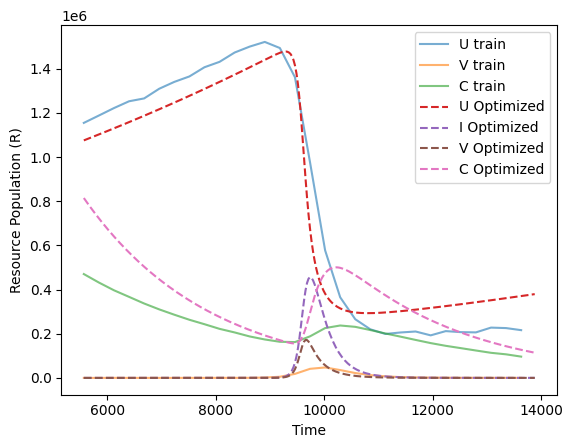

In [ ]:
paramss = np.array([beta, d, p, cp, cd, ck])
model1 = train_submodel(50,paramss)

In [ ]:
paramss

array([4.3080e-08, 4.1700e-03, 1.3644e-01, 4.0000e-05, 3.0000e-04,
       4.0000e-06])

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-203-947943a3bfe0>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  2%|▏         | 1/50 [00:00<00:16,  3.04it/s]<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
 18%|█▊        | 9/50 [00:05<00:22,  1.79it/s]<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model

Optimized Parameters:
[5.50676909e-08 8.52582093e-03 3.54172516e-01 7.45048743e-05
 9.36316802e-04 6.38167612e-06]


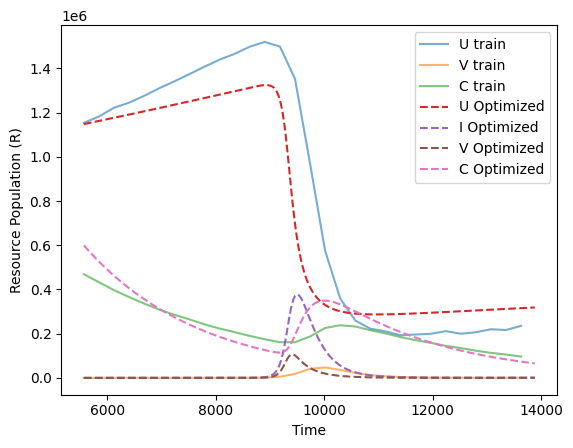

In [ ]:
paramss = np.array([beta - 3e-09, d+3e-04, p, cp*1.05, cd*1.01, ck*.99])
model2 = train_submodel(50,paramss)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-203-947943a3bfe0>:6: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = cp * I**1.3 - cd * C
<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd, ck, 1e7))
  2%|▏         | 1/50 [00:02<02:07,  2.59s/it]<ipython-input-203-947943a3bfe0>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=(beta, d, p, cp, cd,

Optimized Parameters:
[3.39628367e-08 8.96178003e-03 2.40781652e-01 5.18594835e-05
 8.72997685e-04 3.52163417e-06]


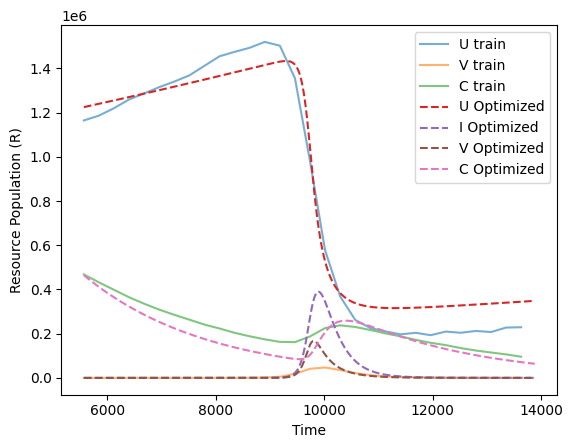

In [ ]:
paramss = np.array([beta * 0.98, d*1.07, p*1.01, cp*0.94, cd*1.01, ck*.99])
model3 = train_submodel(50,paramss)

In [ ]:
import numpy as np
from scipy.integrate import odeint
import pypesto
import pypesto.optimize as optimize
import matplotlib.pyplot as plt

def train_super_model(model_train, y0, paramss, ltb, utb, step, t_steps, paramss_lb = None, paramss_ub = None):
  y0_train = [*y0,*y0,*y0]
  # Time points
  t = np.linspace(0, 20000, 720)

  # Simulate synthetic "observed" data
  observed_data = solution[ltb:utb:step]
  observed_data_ = observed_data[:,[0,3,4]]  # Example: Observing only the resource population R

  # Define the objective function for pyPESTO
  def simulate_model(params):
      c12,c13,c21,c23,c31,c32 = params
      solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
      return solution  # Observing R

  def objective_function(x):
      simulated = simulate_model(x)
      mean_simulated = np.zeros((simulated.shape[0],3))
      mean_simulated[:,0] = simulated[:,[0,4,8]].mean(axis=1)
      mean_simulated[:,1] = simulated[:,[2,6,10]].mean(axis=1)
      mean_simulated[:,2] = simulated[:,[3,7,11]].mean(axis=1)
      residuals = observed_data_ - mean_simulated[ltb:utb:step]
      return np.sum(residuals**2)

  # Create a pyPESTO objective
  objective = pypesto.Objective(fun=objective_function)

  # Define the parameter bounds and initial guess
  paramss_lb = paramss - 2* np.abs(paramss) if paramss_lb is None else paramss_lb  # Lower bounds
  paramss_ub = paramss + 2* np.abs(paramss) if paramss_ub is None else paramss_ub# Upper bounds
  x0 = paramss  # Initial guess

  # Create a pyPESTO problem
  problem = pypesto.Problem(objective=objective, lb=paramss_lb, ub=paramss_ub, x_guesses=[x0.tolist()])

  # Run the optimizer
  result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(),n_starts=t_steps)

  # Extract and print the optimized parameters
  print("Optimized Parameters:")
  print(result.optimize_result.list[0]['x'])

  # Plot observed vs simulated data
  optimized_params = result.optimize_result.list[0]['x']
  optimized_solution = simulate_model(optimized_params)
  optimized_solution_ = np.zeros((optimized_solution.shape[0],4))
  optimized_solution_[:,0] = optimized_solution[:,[0,4,8]].mean(axis=1)
  optimized_solution_[:,1] = optimized_solution[:,[1,5,9]].mean(axis=1)
  optimized_solution_[:,2] = optimized_solution[:,[2,6,10]].mean(axis=1)
  optimized_solution_[:,3] = optimized_solution[:,[3,7,11]].mean(axis=1)

  plt.plot(t[ltb:utb:step], observed_data_[:,0], label="U train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data_[:,1], label="V train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data_[:,2], label="C train", alpha=0.6)
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,0], label="U Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,1], label="I Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,2], label="V Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,3], label="C Optimized", linestyle="--")
  plt.xlabel("Time")
  plt.ylabel("Resource Population (R)")
  plt.legend()
  plt.show()

  return optimized_params, optimized_solution_

In [ ]:
smodel = Supermodel(model1,model2,model3)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
 15%|█▌        | 3/20 [00:00<00:03,  5.27it/s]<ipython-input-279-a98ffae083f7>:10: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = params[3] * I**1.3 - params[4] * C
<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


Optimized Parameters:
[0.06327351 0.42417267 0.53430445 0.12628625 0.37839314 0.23335641]


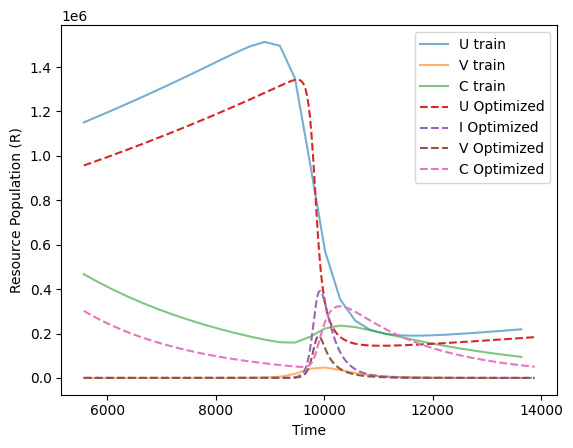

In [ ]:
from numpy.random import random

model_super, solutions = train_super_model(model_train=smodel.simulate,
 y0=[U0, 0, 1000,0],
 paramss=random(6),
 ltb=200,
 utb=500,
 step=10,
 t_steps=20)

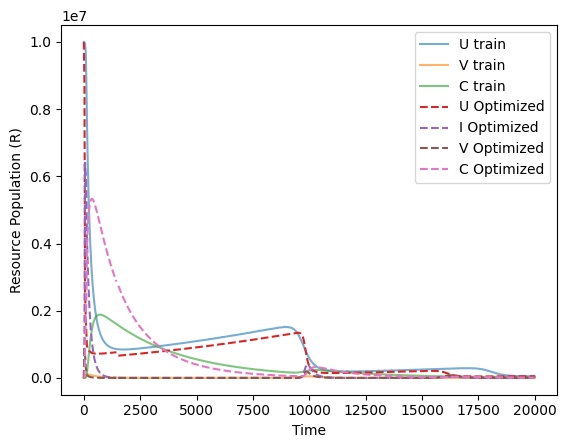

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, solutions[:,0], label="U Optimized", linestyle="--")
plt.plot(t, solutions[:,1], label="I Optimized", linestyle="--")
plt.plot(t, solutions[:,2], label="V Optimized", linestyle="--")
plt.plot(t, solutions[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
<ipython-input-297-a9e2bacd0881>:29: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
  2%|▎         | 5/200 [00:06<04:25,  1.36s/it]<ipython-input-279-a98ffae083f7>:10: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = params[3] * I**1.3 - params[4] * C
 36%|███▋      | 73/200 [00:44<0

Optimized Parameters:
[-0.1329116   0.52780199  0.14539137  1.24062043  0.07113424 -0.06617976]


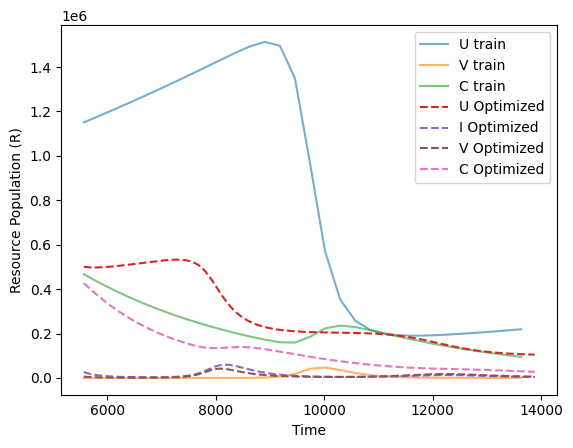

In [ ]:
from numpy.random import random

model_super2, solutions2 = train_super_model(model_train=smodel.simulate,
 y0=[U0, 0, 1000,0],
 paramss=random(6),
 ltb=200,
 utb=500,
 step=10,
 t_steps=200)

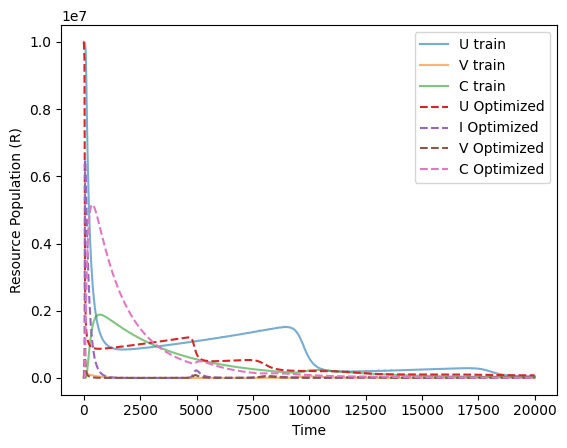

In [ ]:
plt.plot(t, observed_data[:,0], label="U train", alpha=0.6)
plt.plot(t, observed_data[:,1], label="V train", alpha=0.6)
plt.plot(t, observed_data[:,2], label="C train", alpha=0.6)
plt.plot(t, solutions2[:,0], label="U Optimized", linestyle="--")
plt.plot(t, solutions2[:,1], label="I Optimized", linestyle="--")
plt.plot(t, solutions2[:,2], label="V Optimized", linestyle="--")
plt.plot(t, solutions2[:,3], label="C Optimized", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Resource Population (R)")
plt.legend()
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
  0%|          | 1/200 [00:00<02:22,  1.40it/s]<ipython-input-279-a98ffae083f7>:10: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = params[3] * I**1.3 - params[4] * C
<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
  5%|▌         | 10/200 [00:01<00:18, 10.52it/s]<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
100%|█████████

Optimized Parameters:
[ 0.09671448  0.49796915  4.8400964  -0.06240692  3.34322    -1.43750362]


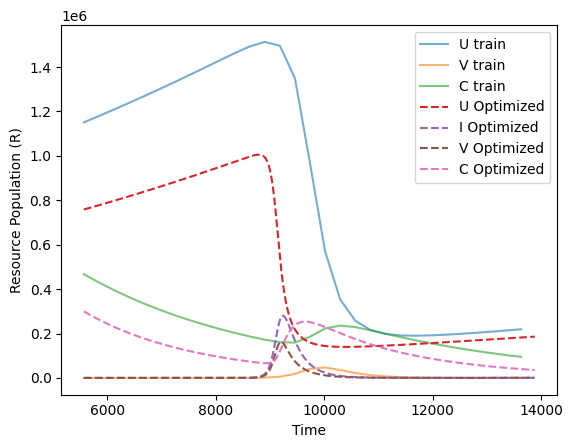

In [ ]:
from numpy.random import random

model_super3, solutions3 = train_super_model(model_train=smodel.simulate,
 y0=[U0, 0, 1000,0],
 paramss=random(6),
 ltb=200,
 utb=500,
 step=10,
 t_steps=200,
 paramss_lb=[-10]*6,
 paramss_ub=[10]*6)

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-279-a98ffae083f7>:10: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = params[3] * I**1.3 - params[4] * C
<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
  1%|          | 2/200 [01:03<1:44:34, 31.69s/it]<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
100%|██████████| 200/200 [07:19<00:00,  2.20s/it]


Optimized Parameters:
[ 3.60641173  7.44182805  5.46089285 -8.06953625  2.02215719  5.13174439]


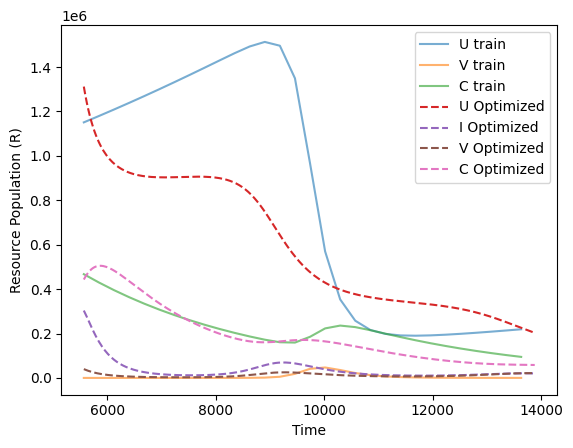

In [ ]:
from numpy.random import random

model_super4, solutions4 = train_super_model(model_train=smodel.simulate,
 y0=[U0, 0, 1000,0],
 paramss=random(6)*20 - 10,
 ltb=200,
 utb=500,
 step=10,
 t_steps=200,
 paramss_lb=[-10]*6,
 paramss_ub=[10]*6)

In [ ]:
import numpy as np
from scipy.integrate import odeint
import pypesto
import pypesto.optimize as optimize
import matplotlib.pyplot as plt

def train_super_model_single(model_train, y0, paramss, ltb, utb, step, t_steps, paramss_lb = None, paramss_ub = None):
  y0_train = [*y0,*y0,*y0]
  # Time points
  t = np.linspace(0, 20000, 720)

  # Simulate synthetic "observed" data
  observed_data = solution[ltb:utb:step]
  observed_data_ = observed_data[:,[0]]  # Example: Observing only the resource population R

  # Define the objective function for pyPESTO
  def simulate_model(params):
      c12,c13,c21,c23,c31,c32 = params
      solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
      return solution  # Observing R

  def objective_function(x):
      simulated = simulate_model(x)
      mean_simulated = simulated[:,[0,4,8]].mean(axis=1)
      residuals = observed_data_ - mean_simulated[ltb:utb:step]
      return np.sum(residuals**2)

  # Create a pyPESTO objective
  objective = pypesto.Objective(fun=objective_function)

  # Define the parameter bounds and initial guess
  paramss_lb = paramss - 2* np.abs(paramss) if paramss_lb is None else paramss_lb  # Lower bounds
  paramss_ub = paramss + 2* np.abs(paramss) if paramss_ub is None else paramss_ub# Upper bounds
  x0 = paramss  # Initial guess

  # Create a pyPESTO problem
  problem = pypesto.Problem(objective=objective, lb=paramss_lb, ub=paramss_ub, x_guesses=[x0.tolist()])

  # Run the optimizer
  result = optimize.minimize(problem, optimizer=optimize.ScipyOptimizer(),n_starts=t_steps)

  # Extract and print the optimized parameters
  print("Optimized Parameters:")
  print(result.optimize_result.list[0]['x'])

  # Plot observed vs simulated data
  optimized_params = result.optimize_result.list[0]['x']
  optimized_solution = simulate_model(optimized_params)
  optimized_solution_ = np.zeros((optimized_solution.shape[0],4))
  optimized_solution_[:,0] = optimized_solution[:,[0,4,8]].mean(axis=1)
  optimized_solution_[:,1] = optimized_solution[:,[1,5,9]].mean(axis=1)
  optimized_solution_[:,2] = optimized_solution[:,[2,6,10]].mean(axis=1)
  optimized_solution_[:,3] = optimized_solution[:,[3,7,11]].mean(axis=1)

  plt.plot(t[ltb:utb:step], observed_data[:,0], label="U train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[:,1], label="V train", alpha=0.6)
  plt.plot(t[ltb:utb:step], observed_data[:,2], label="C train", alpha=0.6)
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,0], label="U Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,1], label="I Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,2], label="V Optimized", linestyle="--")
  plt.plot(t[ltb:utb], optimized_solution_[ltb:utb,3], label="C Optimized", linestyle="--")
  plt.xlabel("Time")
  plt.ylabel("Resource Population (R)")
  plt.legend()
  plt.show()

  return optimized_params, optimized_solution_

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-312-67a07981e137>:19: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
<ipython-input-312-67a07981e137>:26: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-312-67a07981e137>:19: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
  0%|          | 1/200 [00:00<01:41,  1.96it/s]<ipython-input-279-a98ffae083f7>:10: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = params[3] * I**1.3 - params[4] * C
<ipython-input-312-67a07981e137>

Optimized Parameters:
[ 4.84389201  8.02822267  3.86463335  1.85230109 -1.78231955  8.27807688]


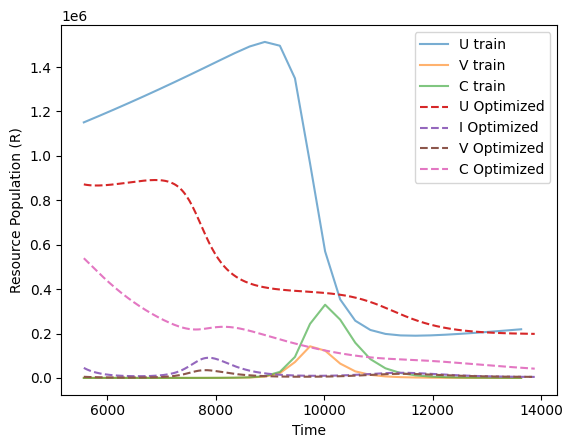

In [ ]:
model_super5, solutions5 = train_super_model_single(model_train=smodel.simulate,
 y0=[U0, 0, 1000,0],
 paramss=random(6),
 ltb=200,
 utb=500,
 step=10,
 t_steps=200,
 paramss_lb=[-10]*6,
 paramss_ub=[10]*6)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
  1%|          | 1/100 [00:00<00:36,  2.69it/s]<ipython-input-279-a98ffae083f7>:10: RuntimeWarning: invalid value encountered in scalar power
  dC_dt = params[3] * I**1.3 - params[4] * C
<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
  3%|▎         | 3/100 [00:00<00:27,  3.55it/s]<ipython-input-297-a9e2bacd0881>:19: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(model_train, y0_train, t, args=(c12,c13,c21,c23,c31,c32))
100%|██████████

Optimized Parameters:
[ 2.64595834 -2.30452675  8.23951449  6.95877253  1.81276893  1.70646095]


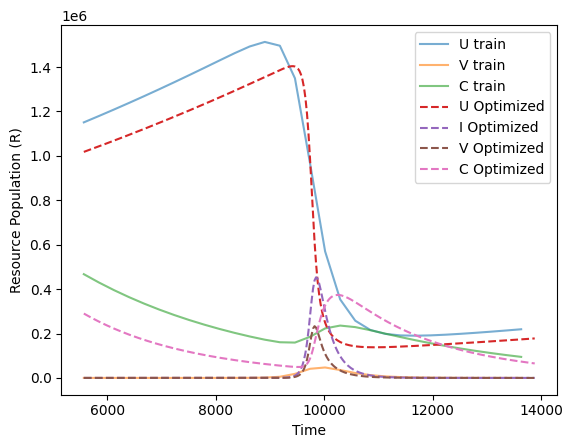

In [ ]:
model_super6, solutions6 = train_super_model(model_train=smodel.simulate,
 y0=[U0, 0, 1000,0],
 paramss=random(6)*20 - 10,
 ltb=200,
 utb=500,
 step=10,
 t_steps=100,
 paramss_lb=[-10]*6,
 paramss_ub=[10]*6)

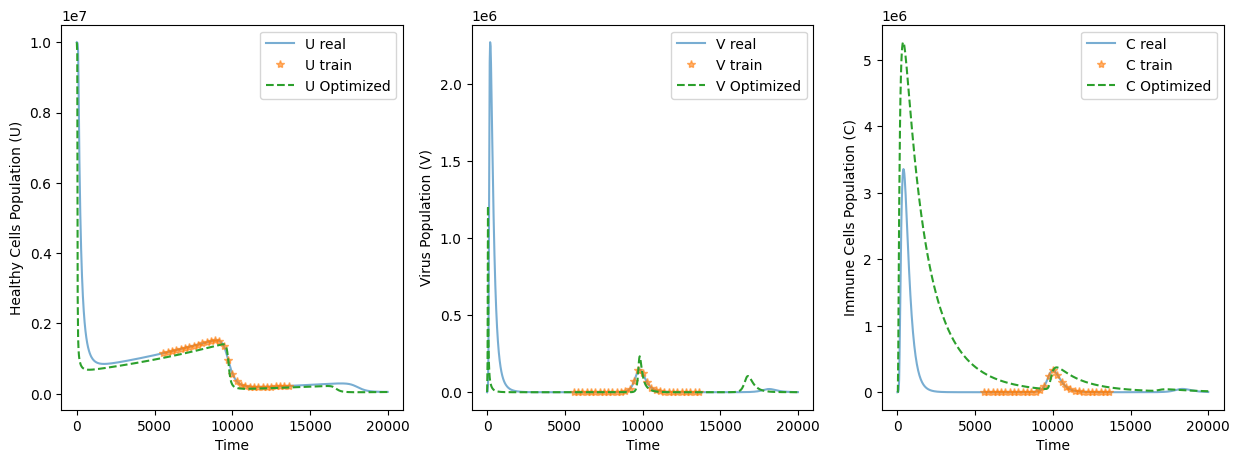

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,5)

axes[0].plot(t, solution[:,0], label="U real", alpha=0.6)
axes[1].plot(t, solution[:,1], label="V real", alpha=0.6)
axes[2].plot(t, solution[:,2], label="C real", alpha=0.6)
axes[0].plot(t[200:500:10], solution[200:500:10,0], '*',label="U train", alpha=0.6)
axes[1].plot(t[200:500:10], solution[200:500:10,1], '*',label="V train", alpha=0.6)
axes[2].plot(t[200:500:10], solution[200:500:10,2], '*',label="C train", alpha=0.6)
axes[0].plot(t, solutions6[:,0], label="U Optimized", linestyle="--")
axes[1].plot(t, solutions6[:,2], label="V Optimized", linestyle="--")
axes[2].plot(t, solutions6[:,3], label="C Optimized", linestyle="--")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")
axes[2].set_xlabel("Time")
axes[0].set_ylabel("Healthy Cells Population (U)")
axes[1].set_ylabel("Virus Population (V)")
axes[2].set_ylabel("Immune Cells Population (C)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

In [ ]:
def calculate_diff(true,pred):
  print(f"RMSE: {np.sqrt(np.mean((true-pred)**2))}")

In [ ]:
calculate_diff(solution[:200,0],solutions6[:200,0])

RMSE: 1350236.8660236557


In [ ]:
calculate_diff(solution[:200,3],solutions6[:200,2])

RMSE: 90905.78380635964


In [ ]:
calculate_diff(solution[:200,4],solutions6[:200,3])

RMSE: 1396995.858141673


In [ ]:
observed_data_gen_ = generate_result(y0,t,5.781984044016652e-08,0.015313636271641753,
                                       0.005531607325236635,0.18882178337606947,0.0693554120596835,
                                       0.00014890200078597916,5.261355994448002e-05,0.0002633066478521143,
                                       4.687055800442963e-06, U0)[:,[0,3,4]]

In [ ]:
calculate_diff(observed_data_gen_[:200,0],solutions6[:200,0])
calculate_diff(observed_data_gen_[:200,1],solutions6[:200,2])
calculate_diff(observed_data_gen_[:200,2],solutions6[:200,3])

RMSE: 933210.7002787276
RMSE: 86421.83872774479
RMSE: 1285650.2809772156


In [ ]:
calculate_diff(observed_data_gen_[200:500,0],solutions6[200:500,0])
calculate_diff(observed_data_gen_[200:500,1],solutions6[200:500,2])
calculate_diff(observed_data_gen_[200:500,2],solutions6[200:500,3])

RMSE: 319646.06596288946
RMSE: 35697.035733850214
RMSE: 158577.3141545915


In [ ]:
calculate_diff(solution[200:500,0],solutions6[200:500,0])
calculate_diff(solution[200:500,3],solutions6[200:500,2])
calculate_diff(solution[200:500,4],solutions6[200:500,3])

RMSE: 132176.13964630393
RMSE: 27662.095300601883
RMSE: 110063.12243916489


In [ ]:
calculate_diff(observed_data_gen_[500:,0],solutions6[500:,0])
calculate_diff(observed_data_gen_[500:,1],solutions6[500:,2])
calculate_diff(observed_data_gen_[500:,2],solutions6[500:,3])

RMSE: 181127.05468860257
RMSE: 32439.57616373835
RMSE: 45642.30791504333


In [ ]:
calculate_diff(solution[500:,0],solutions6[500:,0])
calculate_diff(solution[500:,3],solutions6[500:,2])
calculate_diff(solution[500:,4],solutions6[500:,3])

RMSE: 111952.21584118005
RMSE: 30804.911365800217
RMSE: 16392.925551079315


In [ ]:
model_surogate = [1.07700000e-08, 2.52025242e-03, 1.93411275e-01, 1.26535473e-05,
 4.38697930e-04, 3.37085292e-06]

In [ ]:
solution_sur = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=tuple(model_surogate+[1e7]))

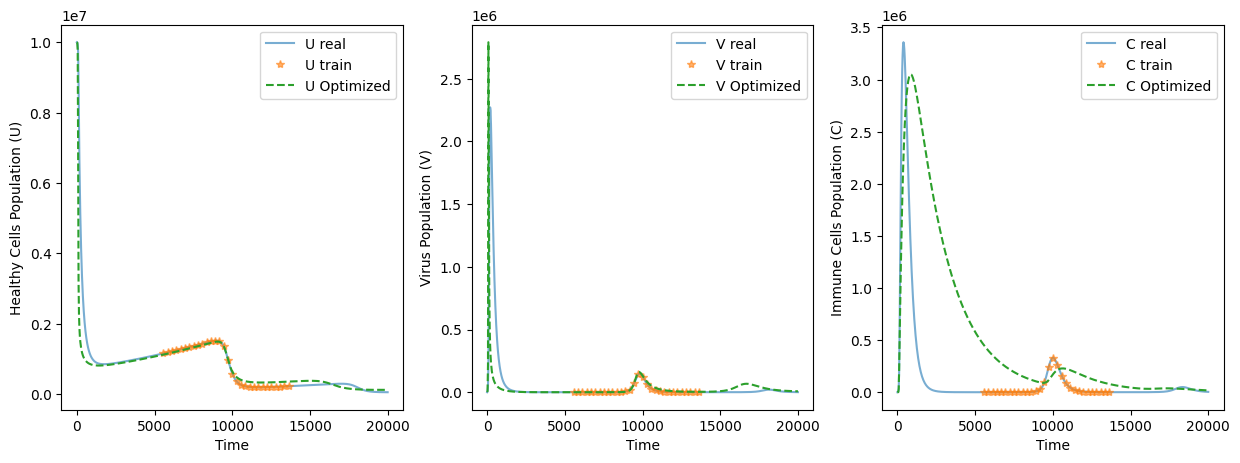

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,5)

axes[0].plot(t, solution[:,0], label="U real", alpha=0.6)
axes[1].plot(t, solution[:,1], label="V real", alpha=0.6)
axes[2].plot(t, solution[:,2], label="C real", alpha=0.6)
axes[0].plot(t[200:500:10], solution[200:500:10,0], '*',label="U train", alpha=0.6)
axes[1].plot(t[200:500:10], solution[200:500:10,1], '*',label="V train", alpha=0.6)
axes[2].plot(t[200:500:10], solution[200:500:10,2], '*',label="C train", alpha=0.6)
axes[0].plot(t, solution_sur[:,0], label="U Optimized", linestyle="--")
axes[1].plot(t, solution_sur[:,2], label="V Optimized", linestyle="--")
axes[2].plot(t, solution_sur[:,3], label="C Optimized", linestyle="--")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")
axes[2].set_xlabel("Time")
axes[0].set_ylabel("Healthy Cells Population (U)")
axes[1].set_ylabel("Virus Population (V)")
axes[2].set_ylabel("Immune Cells Population (C)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

In [ ]:
calculate_diff(observed_data_gen_[:200,0],solution_sur[:200,0])
calculate_diff(observed_data_gen_[:200,1],solution_sur[:200,2])
calculate_diff(observed_data_gen_[:200,2],solution_sur[:200,3])

RMSE: 461918.2003116231
RMSE: 223071.59826805207
RMSE: 574189.8318845055


In [ ]:
calculate_diff(solution[:200,0],solution_sur[:200,0])
calculate_diff(solution[:200,1],solution_sur[:200,2])
calculate_diff(solution[:200,2],solution_sur[:200,3])

RMSE: 918418.6473815788
RMSE: 433504.55552377336
RMSE: 1443185.225824915


In [ ]:
calculate_diff(observed_data_gen_[200:500,0],solution_sur[200:500,0])
calculate_diff(observed_data_gen_[200:500,1],solution_sur[200:500,2])
calculate_diff(observed_data_gen_[200:500,2],solution_sur[200:500,3])

RMSE: 249589.52013839709
RMSE: 37313.575489898394
RMSE: 103080.51988411207


In [ ]:
calculate_diff(solution[200:500,0],solution_sur[200:500,0])
calculate_diff(solution[200:500,3],solution_sur[200:500,2])
calculate_diff(solution[200:500,4],solution_sur[200:500,3])

RMSE: 93279.19711426004
RMSE: 30357.19000962392
RMSE: 45786.04539997711


In [ ]:
calculate_diff(solution[500:,0],solution_sur[500:,0])
calculate_diff(solution[500:,3],solution_sur[500:,2])
calculate_diff(solution[500:,4],solution_sur[500:,3])

RMSE: 90004.5199223802
RMSE: 30224.011232352663
RMSE: 11552.213001000113


In [ ]:
calculate_diff(observed_data_gen_[500:,0],solution_sur[500:,0])
calculate_diff(observed_data_gen_[500:,1],solution_sur[500:,2])
calculate_diff(observed_data_gen_[500:,2],solution_sur[500:,3])

RMSE: 129820.13649791546
RMSE: 32634.24248936587
RMSE: 41555.11100361416


In [ ]:
model_destil = [1.25150194e-08, 4.89491195e-03, 2.63823357e-01, 2.12216836e-05
 ,4.01238789e-04, 2.99396714e-06]

In [ ]:
solution_des = odeint(viral_infection_surrogate_model, [1e7,0,1000,0], t, args=tuple(model_destil+[1e7]))

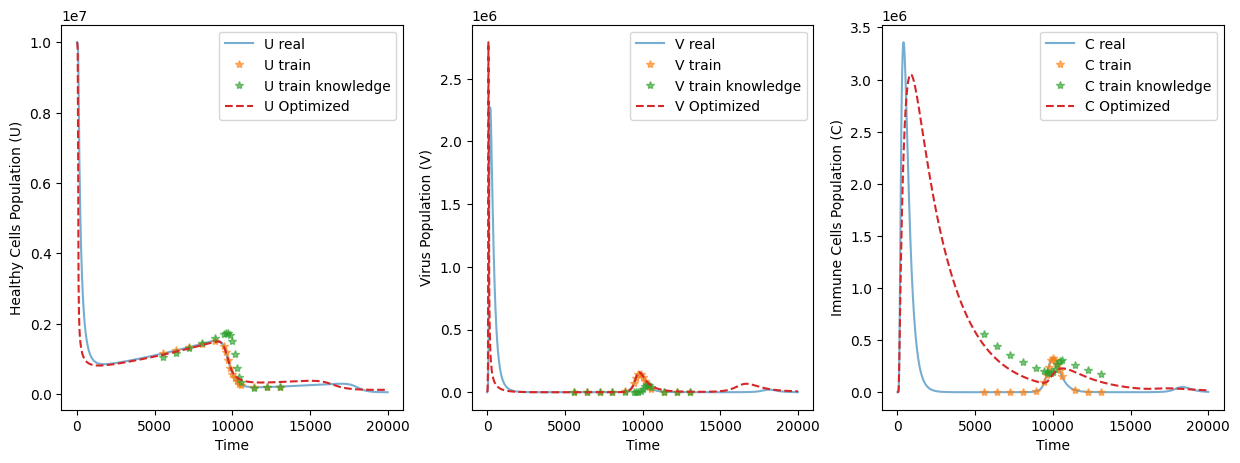

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,5)
indexes = [i for i in range(200,340,30)] + [i for i in range(340,380,5)] + [i for i in range(380,500,30)]

axes[0].plot(t, solution[:,0], label="U real", alpha=0.6)
axes[1].plot(t, solution[:,1], label="V real", alpha=0.6)
axes[2].plot(t, solution[:,2], label="C real", alpha=0.6)
axes[0].plot(t[indexes], solution[indexes,0], '*',label="U train", alpha=0.6)
axes[1].plot(t[indexes], solution[indexes,1], '*',label="V train", alpha=0.6)
axes[2].plot(t[indexes], solution[indexes,2], '*',label="C train", alpha=0.6)
axes[0].plot(t[indexes], observed_data_gen_[indexes,0], '*',label="U train knowledge", alpha=0.6)
axes[1].plot(t[indexes], observed_data_gen_[indexes,1], '*',label="V train knowledge", alpha=0.6)
axes[2].plot(t[indexes], observed_data_gen_[indexes,2], '*',label="C train knowledge", alpha=0.6)
axes[0].plot(t, solution_sur[:,0], label="U Optimized", linestyle="--")
axes[1].plot(t, solution_sur[:,2], label="V Optimized", linestyle="--")
axes[2].plot(t, solution_sur[:,3], label="C Optimized", linestyle="--")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")
axes[2].set_xlabel("Time")
axes[0].set_ylabel("Healthy Cells Population (U)")
axes[1].set_ylabel("Virus Population (V)")
axes[2].set_ylabel("Immune Cells Population (C)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

In [ ]:
calculate_diff(solution[:200,0],solution_des[:200,0])
calculate_diff(solution[:200,1],solution_des[:200,2])
calculate_diff(solution[:200,2],solution_des[:200,3])

RMSE: 1119819.150302407
RMSE: 447634.66552971484
RMSE: 1208303.4421369336


In [ ]:
calculate_diff(observed_data_gen_[:200,0],solution_des[:200,0])
calculate_diff(observed_data_gen_[:200,1],solution_des[:200,2])
calculate_diff(observed_data_gen_[:200,2],solution_des[:200,3])

RMSE: 693150.6709033279
RMSE: 182207.13281692023
RMSE: 436310.5075065273


In [ ]:
calculate_diff(observed_data_gen_[200:500,0],solution_des[200:500,0])
calculate_diff(observed_data_gen_[200:500,1],solution_des[200:500,2])
calculate_diff(observed_data_gen_[200:500,2],solution_des[200:500,3])

RMSE: 181899.46035522336
RMSE: 42849.19668460807
RMSE: 100537.72959007205


In [ ]:
calculate_diff(solution[200:500,0],solution_des[200:500,0])
calculate_diff(solution[200:500,3],solution_des[200:500,2])
calculate_diff(solution[200:500,4],solution_des[200:500,3])

RMSE: 222905.86490629913
RMSE: 40187.37576462887
RMSE: 50820.63100347949


In [ ]:
calculate_diff(solution[500:,0],solution_des[500:,0])
calculate_diff(solution[500:,3],solution_des[500:,2])
calculate_diff(solution[500:,4],solution_des[500:,3])

RMSE: 173247.51557961298
RMSE: 38836.56540299487
RMSE: 12526.289197849903


In [ ]:
calculate_diff(observed_data_gen_[500:,0],solution_des[500:,0])
calculate_diff(observed_data_gen_[500:,1],solution_des[500:,2])
calculate_diff(observed_data_gen_[500:,2],solution_des[500:,3])

RMSE: 182855.82487828482
RMSE: 39895.296303350806
RMSE: 35705.881531185536


### PINN

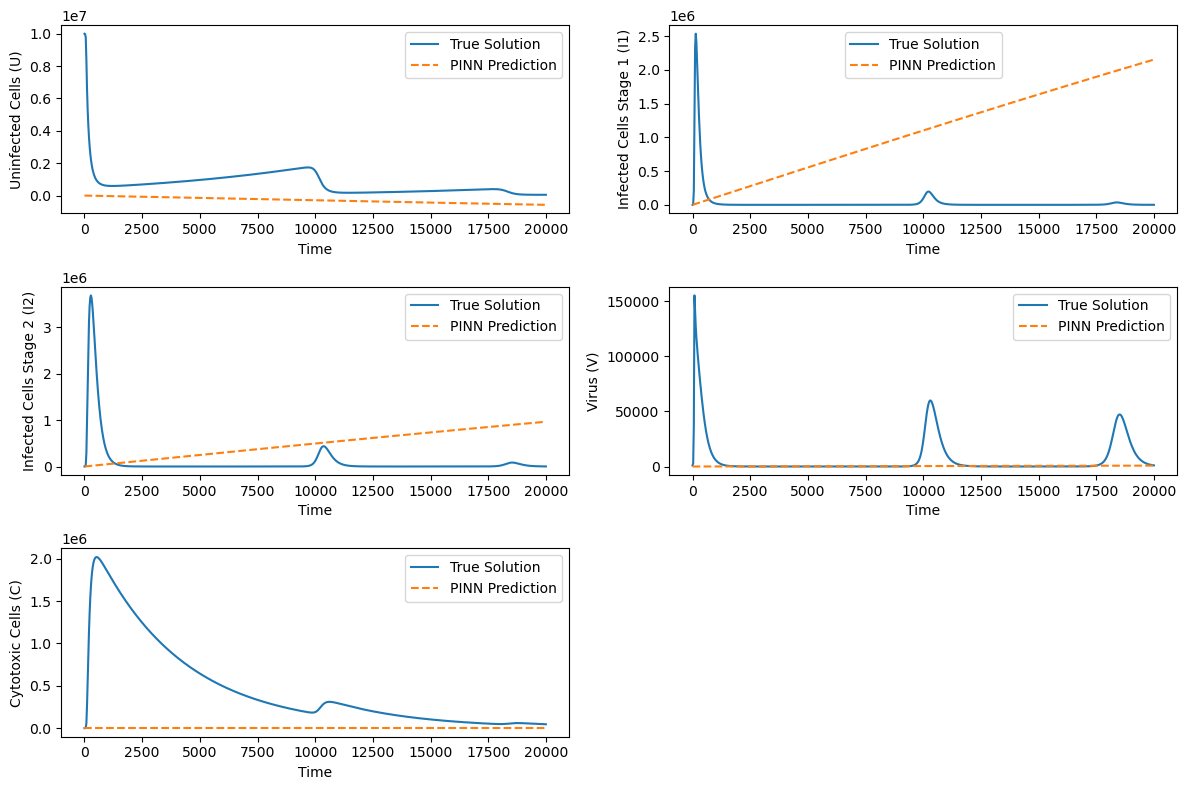

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

params = [5.782E-08, 1.531E-02, 5.532E-03, 1.888E-01, 6.936E-02, 
          5.261E-05, 2.633E-04, 4.687E-06, 1.489E-04, 1e7]

# Define the ODE system
def viral_infection_model(y, t, beta, k, d, p, c, cp, cd, ck, r, U_max):
    U, I1, I2, V, C = y
    dU_dt = -beta * U * V + r * (1 - (U + I1 + I2) / U_max) * U
    dI1_dt = beta * U * V - k * I1
    dI2_dt = k * I1 - d * I2
    dV_dt = p * I2 - c * V - ck * C * V
    dC_dt = cp * I1**1.3 - cd * C
    return [dU_dt, dI1_dt, dI2_dt, dV_dt, dC_dt]

class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = layers.Dense(300, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense2 = layers.Dense(300, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense3 = layers.Dense(300, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense4 = layers.Dense(300, activation='tanh', kernel_initializer='glorot_uniform')
        self.dense5 = layers.Dense(300, activation='tanh', kernel_initializer='glorot_uniform')
        self.output_layer = layers.Dense(5, kernel_initializer='glorot_uniform')

    def call(self, inputs):
        t = inputs[:, 0:1]
        hidden1 = self.dense1(t)
        hidden2 = self.dense2(hidden1)
        hidden3 = self.dense3(hidden2)
        hidden4 = self.dense4(hidden3)
        hidden5 = self.dense5(hidden4)
        output = self.output_layer(hidden5)
        return output

def normalize(t, y, t_max, y_max):
    t_normalized = t / t_max
    y_normalized = [yi / yi_max for yi, yi_max in zip(y, y_max)]
    return t_normalized, y_normalized

# Clamp function to prevent overflow/underflow
def clamp_values(x, min_val, max_val):
    return tf.clip_by_value(x, min_val, max_val)

# Define the combined loss function with data loss weight
def combined_loss(model, t, y_true, y_max, data_loss_weight=100.0):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        y_pred = model(t)
        U, I1, I2, V, C = [y * yi_max for y, yi_max in zip(tf.unstack(y_pred, axis=-1), y_max)]
        
    dU_dt = tape.gradient(U, t)
    dI1_dt = tape.gradient(I1, t)
    dI2_dt = tape.gradient(I2, t)
    dV_dt = tape.gradient(V, t)
    dC_dt = tape.gradient(C, t)
    del tape
    
    epsilon = 1e-7
    U_safe, I1_safe, I2_safe, V_safe, C_safe = [x + epsilon for x in [U, I1, I2, V, C]]
    I1_safe_clamped = clamp_values(I1_safe, epsilon, 1e2)
    
    beta, k, d, p, c, cp, cd, ck, r, U_max = params
    
    res_U = dU_dt + beta * U_safe * V_safe - r * (1 - (U_safe + I1_safe + I2_safe) / U_max) * U_safe
    res_I1 = dI1_dt - beta * U_safe * V_safe + k * I1_safe
    res_I2 = dI2_dt - k * I1_safe + d * I2_safe
    res_V = dV_dt - p * I2_safe + c * V_safe + ck * C_safe * V_safe
    res_C = dC_dt - cp * I1_safe_clamped**1.3 + cd * C_safe
    
    physics_loss_value = tf.reduce_mean(tf.square(res_U)) + \
                         tf.reduce_mean(tf.square(res_I1)) + \
                         tf.reduce_mean(tf.square(res_I2)) + \
                         tf.reduce_mean(tf.square(res_V)) + \
                         tf.reduce_mean(tf.square(res_C))
    
    data_loss_value = tf.reduce_mean(tf.square(y_true - y_pred))
    
    return physics_loss_value + data_loss_value * data_loss_weight

# Training loop
def train(model, t, y_true, epochs, optimizer, data_loss_weight, patience=200):
    t_tf = tf.convert_to_tensor(t, dtype=tf.float32)
    y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float32)
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss_value = combined_loss(model, t_tf, y_true_tf, y_max, data_loss_weight)
        gradients = tape.gradient(loss_value, model.trainable_variables)
        gradients = [tf.clip_by_norm(g, 1.0) for g in gradients]  # Gradient clipping
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss_value.numpy()}")
        
        # Early stopping
        if loss_value < best_loss:
            best_loss = loss_value
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"Early stopping at epoch {epoch}")
                break

# Initialize and train the PINN
t_max = 20000
t = np.linspace(0, t_max, 720).reshape(-1, 1)
y0 = [1e7, 0, 0, 1000, 0]
y_max = [1e7, 1e7, 1e7, 1e4, 1e4]

# Solve ODE to generate true data
solution = solve_ivp(lambda t, y: viral_infection_model(y, t, *params), [0, t_max], y0, t_eval=t.flatten())

# Normalize the true data
t_normalized, y0_normalized = normalize(t, y0, t_max, y_max)
y_true_normalized = [solution.y[i] / y_max[i] for i in range(5)]
y_true_normalized = np.stack(y_true_normalized, axis=-1)

# Initialize the PINN
pinn = PINN()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Train the PINN
train(pinn, t_normalized, y_true_normalized, epochs=1000, optimizer=optimizer, data_loss_weight=100.0)

# Predict and plot
t_tf = tf.convert_to_tensor(t_normalized, dtype=tf.float32)
pinn_predictions = pinn(t_tf).numpy()
variables = ['Uninfected Cells (U)', 'Infected Cells Stage 1 (I1)', 'Infected Cells Stage 2 (I2)', 'Virus (V)', 'Cytotoxic Cells (C)']
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.plot(t.flatten(), solution.y[i], label='True Solution')
    plt.plot(t.flatten(), pinn_predictions[:, i] * y_max[i], '--', label='PINN Prediction')
    plt.xlabel('Time')
    plt.ylabel(variables[i])
    plt.legend()
plt.tight_layout()
plt.show()


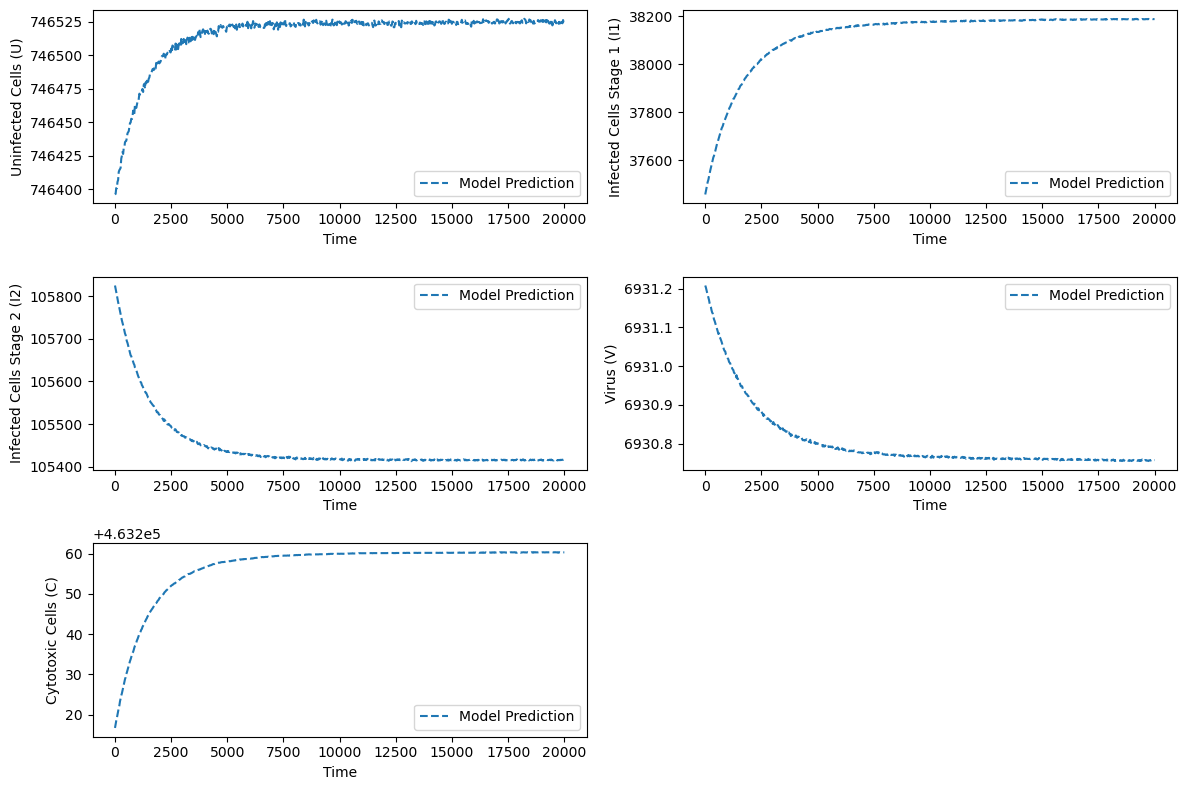

In [120]:
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(3, 2, i+1)
    # plt.plot(t.flatten(), solution.y[i], label='True Solution')
    plt.plot(t.flatten(), predictions[:, i] * y_max[i], '--', label='Model Prediction')
    plt.xlabel('Time')
    plt.ylabel(variables[i])
    plt.legend()
plt.tight_layout()
plt.show()